230
230
415
415
415
415
230
11000


AttributeError: 'function' object has no attribute 'write'

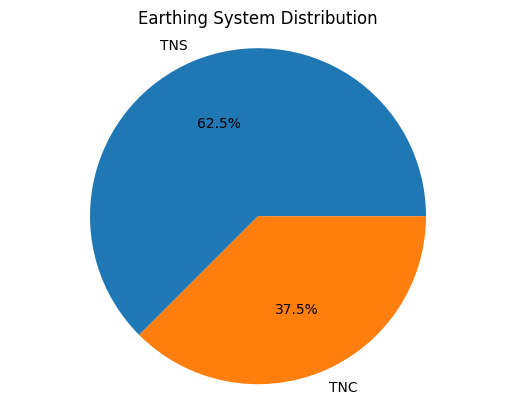

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import docx
from docx import Document
import csv
import io
from docx.shared import Inches
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from docx.shared import Pt, RGBColor

A = "floor.csv"
df = pd.read_csv(A)
B="Insulate.csv"
mf=pd.read_csv(B)


df['Applied Test Voltage (V)'] = pd.to_numeric(df['Applied Test Voltage (V)'], errors='coerce')
df['Measured Output Current (mA)'] = pd.to_numeric(df['Measured Output Current (mA)'], errors='coerce')

df['EffectiveResistance'] = df['Applied Test Voltage (V)'] / df['Measured Output Current (mA)']
df.to_csv('floorfinal.csv', index=False)


def resistanceresult(Nom_EVolt, ATV, Eff_Floor, Dist_loc):
    if Nom_EVolt <= 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 50:
            return "pass"
        else:
            return "fail"
    elif Nom_EVolt > 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 100:
            return "pass"
        else:
            return "fail"
    elif Dist_loc <= 1:
        return "fail"
    else:
        return "Invalid input"


def insulateresult(Nom_CVolt, T_Volt, Insu_R):
    if Nom_CVolt <= 50:
        if Insu_R >= 0.5 and T_Volt == 250:
            return "Satisfactory"
        else:
            return "Unsatisfactory"
    elif 50 < Nom_CVolt <= 500:
        if Insu_R >= 1 and T_Volt == 500:
            return "Satisfactory"
        else:
            return "Unsatisfactory"
    elif Nom_CVolt > 500:
        if Insu_R >= 1 and T_Volt == 1000:
            return "Satisfactory"
        else:
            return "Unsatisfactory"
    else:
        return "Invalid input"
    
def resistancerang(length):
    res1 = []
    for row in range(length):
        Nom_EVolt = df.iloc[row, 5]
        Dist_loc = df.iloc[row, 4]
        ATV = df.iloc[row, 6]
        Eff_Floor = df.iloc[row, 8]
        res1.append(resistanceresult(Nom_EVolt, ATV, Eff_Floor, Dist_loc))
    return res1

def insulationrang(length):
    res2 = []
    for row in range(length):  # Adjusted the range to start from 0
        Nom_CVolt = mf.iloc[row, 7]
        T_Volt = mf.iloc[row, 9]
        Insu_R = mf.iloc[row, 13]
        res2.append(insulateresult(Nom_CVolt, T_Volt, Insu_R))
        print(Nom_CVolt)
    return res2


def resistance_table(df, doc):
    table_data = df.iloc[:, :]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)
    table.style = "Table Grid"
    table.autofit = False

    column_widths = {
        0: 0.4,
        1: 0.6,
        2: 0.7,
        3: 0.65,
        4: 0.5,
        5: 0.5,
        6: 0.5,
        7: 0.5,
        8: 0.5,
        9: 0.5,
        10:0.7,
        11:0.6,
    }

    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])

    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            if isinstance(value, float):
                value = "{:.2f}".format(value)
            table.cell(i, j).text = str(value)

    Results = resistancerang(num_rows)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(0.6)
    for i in range(num_rows):
        table.cell(i + 1, num_cols).text = Results[i]
    table.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    font_size = 8

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)

    return doc

def insulation_table(mf, doc):
    table_data = mf.iloc[:, 0:]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)                        # Add +1 for the "Result" column
    table.style = "Table Grid"
    table.autofit = False
    column_widths = {
        0: 0.2,
        1: 0.51,
        2: 0.55,
        3: 0.54,
        4: 0.38,
        5: 0.4,
        6: 0.5,
        7: 0.48,
        8: 0.5,
        9: 0.43,
        10: 0.4,
        11: 0.4,
        12: 0.4,
        13: 0.4,
        num_cols: 0.8                                                                 # Width for the "Result" column
    }
    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i, j).text = str(value)
    Results = insulationrang(num_rows)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(column_widths[num_cols])  # Set width for the "Result" column
    for i in range(0, num_rows):
        res_index = i - 1
        table.cell(i + 1, num_cols).text = Results[res_index]
    font_size = 6.5

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)

    return doc

def resistance_graph(df):
    x = df["Distance from previous test location (m)"]
    y = df["EffectiveResistance"]
    plt.scatter(x, y)
    plt.xlabel("Distance from previous test location (m)")
    plt.ylabel("Effectivefloor")
    plt.title("Distance from previous test location (m) VS Effectivefloor")
    plt.savefig("scatter_graph.png")
    resistance_graph = io.BytesIO()
    plt.savefig(resistance_graph)
    plt.close()
    return resistance_graph

def insulation_graph(mf):
    x = mf["Location"]
    y = mf["Nominal Circuit Voltage"]
    plt.bar(x, y)
    plt.xlabel("Location")
    plt.ylabel("Nominal Circuit Voltage")
    plt.title("Nominal Circuit Voltage by Location")
    plt.savefig("chart.png")
    insulation_graph= io.BytesIO()
    plt.savefig(insulation_graph)
    plt.close()
    return insulation_graph

def resistance_pie(df):
    df['Result'] = resistancerang(df.shape[0])
    df_counts = df['Result'].value_counts()
    labels = df_counts.index.tolist()
    values = df_counts.values.tolist()
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title('Test Results')
    plt.savefig('pie_chart.png')
    resistance_pie= io.BytesIO()
    plt.savefig(resistance_pie)
    plt.close()
    return resistance_pie

def insulation_pie(mf):
    earthing_system_counts = mf["Earthing System"].value_counts()
    plt.pie(earthing_system_counts, labels=earthing_system_counts.index, autopct="%1.1f%%")
    plt.axis("equal")
    plt.title("Earthing System Distribution")
    insulation__pie = io.BytesIO()
    plt.savefig(insulation_pie)
    plt.close()
    return insulation_pie

def main():
    M = "floor.csv"
    df = pd.read_csv("floorfinal.csv")

    Y="Insulate.csv"
    mf=pd.read_csv("Insulate.csv")

    doc = docx.Document()
    doc.add_heading('TESTING REPORT', 0)

    doc = resistance_table(df, doc)
    doc.add_page_break()
    doc = insulation_table(mf, doc)

    resistance_graph = resistance_graph(df)
    doc.add_picture(resistance_graph, width=Inches(5), height=Inches(3))

    insulation_graph = insulation_graph(mf)
    doc.add_picture(insulation_graph,width=Inches(5), height=Inches(3))

    resistance_pie= resistance_pie(df)
    doc.add_picture(resistance_pie, width=Inches(5), height=Inches(3))
   
    ins_pie= insulation_pie(mf)
    doc.add_picture(ins_pie,width=Inches(5), height=Inches(3))
    
    doc.save("scriptreport.docx")


main()


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import docx
from docx import Document
import csv
import io
from docx.shared import Inches
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from docx.shared import Pt, RGBColor

A = "floor.csv"
df = pd.read_csv(A)
B="Insulate.csv"
mf=pd.read_csv(B)


df['Applied Test Voltage (V)'] = pd.to_numeric(df['Applied Test Voltage (V)'], errors='coerce')
df['Measured Output Current (mA)'] = pd.to_numeric(df['Measured Output Current (mA)'], errors='coerce')

df['EffectiveResistance'] = df['Applied Test Voltage (V)'] / df['Measured Output Current (mA)']
df.to_csv('floorfinal.csv', index=False)


def resistanceresult(Nom_EVolt, ATV, Eff_Floor, Dist_loc):
    if Nom_EVolt <= 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 50:
            return "pass"
        else:
            return "fail"
    elif Nom_EVolt > 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 100:
            return "pass"
        else:
            return "fail"
    elif Dist_loc <= 1:
        return "fail"
    else:
        return "Invalid input"


def insulateresult(Nom_CVolt, T_Volt, Insu_R):
    if Nom_CVolt <= 50:
        if Insu_R >= 0.5 and T_Volt == 250:
            return "Satisfactory"
        else:
            return "Unsatisfactory"
    elif 50 < Nom_CVolt <= 500:
        if Insu_R >= 1 and T_Volt == 500:
            return "Satisfactory"
        else:
            return "Unsatisfactory"
    elif Nom_CVolt > 500:
        if Insu_R >= 1 and T_Volt == 1000:
            return "Satisfactory"
        else:
            return "Unsatisfactory"
    else:
        return "Invalid input"
    
def resistancerang(length):
    res1 = []
    for row in range(length):
        Nom_EVolt = df.iloc[row, 5]
        Dist_loc = df.iloc[row, 4]
        ATV = df.iloc[row, 6]
        Eff_Floor = df.iloc[row, 8]
        res1.append(resistanceresult(Nom_EVolt, ATV, Eff_Floor, Dist_loc))
    return res1

def insulationrang(length):
    res2 = []
    for row in range(length):  # Adjusted the range to start from 0
        Nom_CVolt = mf.iloc[row, 7]
        T_Volt = mf.iloc[row, 9]
        Insu_R = mf.iloc[row, 13]
        res2.append(insulateresult(Nom_CVolt, T_Volt, Insu_R))
        print(Nom_CVolt)
    return res2


def resistance_table(df, doc):
    table_data = df.iloc[:, :]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)
    table.style = "Table Grid"
    table.autofit = False

    column_widths = {
        0: 0.4,
        1: 0.6,
        2: 0.7,
        3: 0.65,
        4: 0.5,
        5: 0.5,
        6: 0.5,
        7: 0.5,
        8: 0.5,
        9: 0.5,
        10:0.7,
        11:0.6,
    }

    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])

    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            if isinstance(value, float):
                value = "{:.2f}".format(value)
            table.cell(i, j).text = str(value)

    Results = resistancerang(num_rows)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(0.6)
    for i in range(num_rows):
        table.cell(i + 1, num_cols).text = Results[i]
    table.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    font_size = 8

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)

    return doc

def insulation_table(df, doc):
    table_data = df.iloc[:, 0:]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)                        # Add +1 for the "Result" column
    table.style = "Table Grid"
    table.autofit = False
    column_widths = {
        0: 0.2,
        1: 0.51,
        2: 0.55,
        3: 0.54,
        4: 0.38,
        5: 0.4,
        6: 0.5,
        7: 0.48,
        8: 0.5,
        9: 0.43,
        10: 0.4,
        11: 0.4,
        12: 0.4,
        13: 0.4,
        num_cols: 0.8                                                                 # Width for the "Result" column
    }
    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i, j).text = str(value)
    Results = insulationrang(num_rows)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(column_widths[num_cols])  # Set width for the "Result" column
    for i in range(0, num_rows):
        res_index = i - 1
        table.cell(i + 1, num_cols).text = Results[res_index]
    font_size = 6.5

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)

    return doc

def resistance_graph(df):
    x = df["Distance from previous test location (m)"]
    y = df["EffectiveResistance"]
    plt.scatter(x, y)
    plt.xlabel("Distance from previous test location (m)")
    plt.ylabel("Effectivefloor")
    plt.title("Distance from previous test location (m) VS Effectivefloor")
    plt.savefig("scatter_graph.png")
    graph1 = io.BytesIO()
    plt.savefig(graph1)
    plt.close()
    return graph1

def insulation_graph(mf):
    x = mf["Location"]
    y = mf["Nominal Circuit Voltage"]
    plt.bar(x, y)
    plt.xlabel("Location")
    plt.ylabel("Nominal Circuit Voltage")
    plt.title("Nominal Circuit Voltage by Location")
    plt.savefig("chart.png")
    graph2 = io.BytesIO()
    plt.savefig(graph2)
    plt.close()
    return graph2

def resistance_pie(df):
    df['Result'] = resistancerang(df.shape[0])
    df_counts = df['Result'].value_counts()
    labels = df_counts.index.tolist()
    values = df_counts.values.tolist()

    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title('Test Results')
    plt.savefig('pie_chart.png')
    graph3= io.BytesIO()
    plt.savefig(graph3)
    plt.close()
    return graph3

def insulation_pie(mf):
    earthing_system_counts = mf["Earthing System"].value_counts()
    plt.pie(earthing_system_counts, labels=earthing_system_counts.index, autopct="%1.1f%%")
    plt.axis("equal")
    plt.title("Earthing System Distribution")
    plt.savefig("pie_chart.png")
    graph4 = io.BytesIO()
    plt.savefig(graph4)
    plt.close()
    return graph4

def main():
    M = "floor.csv"
    df = pd.read_csv("floorfinal.csv")

    Y="Insulate.csv"
    mf=pd.read_csv("Insulate.csv")

    doc = docx.Document()
    doc.add_heading('TESTING REPORT', 0)

    doc = resistance_table(df, doc)
    doc.add_page_break()
    doc = insulation_table(mf, doc)

    graph_resistance = resistance_graph(df)
    doc.add_picture(graph_resistance, width=Inches(5), height=Inches(3))

    graph_insulation = insulation_graph(mf)
    doc.add_picture(graph_insulation,width=Inches(5), height=Inches(3))

    pie_resistance= resistance_pie(df)
    doc.add_picture(pie_resistance, width=Inches(5), height=Inches(3))
   
    pie_insulation= insulation_pie(mf)
    doc.add_picture(pie_insulation,width=Inches(5), height=Inches(3))
    
    doc.save("scriptreport.docx")


main()


230
230
415
415
415
415
230
11000


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import docx
from docx import Document
import csv
import io
from docx.shared import Inches
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from docx.shared import Pt, RGBColor

M = "floor.csv"
df = pd.read_csv(M)

df['Applied Test Voltage (V)'] = pd.to_numeric(df['Applied Test Voltage (V)'], errors='coerce')
df['Measured Output Current (mA)'] = pd.to_numeric(df['Measured Output Current (mA)'], errors='coerce')

df['EffectiveResistance'] = df['Applied Test Voltage (V)'] / df['Measured Output Current (mA)']
df.to_csv('floorfinal.csv', index=False)



def resistanceresult(Nom_EVolt, ATV, Eff_Floor, Dist_loc):
    if Nom_EVolt <= 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 50:
            return "pass"
        else:
            return "fail"
    elif Nom_EVolt > 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 100:
            return "pass"
        else:
            return "fail"
    elif Dist_loc <= 1:
        return "fail"
    else:
        return "Invalid input"


def resistancerang(length):
    res = []
    for row in range(length):
        Nom_EVolt = df.iloc[row, 5]
        Dist_loc = df.iloc[row, 4]
        ATV = df.iloc[row, 6]
        Eff_Floor = df.iloc[row, 8]
        res.append(resistanceresult(Nom_EVolt, ATV, Eff_Floor, Dist_loc))
    return res


def resistance_table(df, doc):
    table_data = df.iloc[:, :]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)
    table.style = "Table Grid"
    table.autofit = False

    column_widths = {
        0: 0.4,
        1: 0.6,
        2: 0.7,
        3: 0.65,
        4: 0.5,
        5: 0.5,
        6: 0.5,
        7: 0.5,
        8: 0.5,
        9: 0.5,
        10:0.7,
        11:0.6,
    }

    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])

    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            if isinstance(value, float):
                value = "{:.2f}".format(value)
            table.cell(i, j).text = str(value)

    Results = resistancerang(num_rows)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(0.6)
    for i in range(num_rows):
        table.cell(i + 1, num_cols).text = Results[i]
    table.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    font_size = 8

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)

    return doc



def resistance_graph(df):
    x = df["Distance from previous test location (m)"]
    y = df["EffectiveResistance"]
    plt.scatter(x, y)
    plt.xlabel("Distance from previous test location (m)")
    plt.ylabel("Effectivefloor")
    plt.title("Distance from previous test location (m) VS Effectivefloor")
    graph1 = io.BytesIO()
    plt.savefig(graph1)
    plt.close()
    return graph1


def resistance_pie(df):
    df['Result'] = resistancerang(df.shape[0])
    df_counts = df['Result'].value_counts()
    labels = df_counts.index.tolist()
    values = df_counts.values.tolist()

    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title('Test Results')
    graph3 = io.BytesIO()
    plt.savefig(graph3)
    plt.close()
    return graph3


def main():
    M = "floor.csv"
    df = pd.read_csv("floorfinal.csv")
    doc = docx.Document()
    doc.add_heading('FLOOR TEST', 0)
    doc = resistance_table(df, doc)
    graph_resistance = resistance_graph(df)
    doc.add_picture(resistance_graph, width=Inches(5), height=Inches(3))
    pie_resistance = resistance_pie(df)
    doc.add_picture(pie_resistance, width=Inches(5), height=Inches(3))
    doc.save("floor.docx")


main()


AttributeError: 'function' object has no attribute 'seek'

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import docx
from docx import Document
import csv
import io
from docx.shared import Inches
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from docx.shared import Pt, RGBColor

M = "floor.csv"
df = pd.read_csv(M)

df['Applied Test Voltage (V)'] = pd.to_numeric(df['Applied Test Voltage (V)'], errors='coerce')
df['Measured Output Current (mA)'] = pd.to_numeric(df['Measured Output Current (mA)'], errors='coerce')

df['EffectiveResistance'] = df['Applied Test Voltage (V)'] / df['Measured Output Current (mA)']
df.to_csv('floorfinal.csv', index=False)



def resistanceresult(Nom_EVolt, ATV, Eff_Floor, Dist_loc):
    if Nom_EVolt <= 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 50:
            return "pass"
        else:
            return "fail"
    elif Nom_EVolt > 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 100:
            return "pass"
        else:
            return "fail"
    elif Dist_loc <= 1:
        return "fail"
    else:
        return "Invalid input"


def resistancerang(length):
    res = []
    for row in range(length):
        Nom_EVolt = df.iloc[row, 5]
        Dist_loc = df.iloc[row, 4]
        ATV = df.iloc[row, 6]
        Eff_Floor = df.iloc[row, 8]
        res.append(resistanceresult(Nom_EVolt, ATV, Eff_Floor, Dist_loc))
    return res


def resistance_table(df, doc):
    table_data = df.iloc[:, :]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)
    table.style = "Table Grid"
    table.autofit = False

    column_widths = {
        0: 0.4,
        1: 0.6,
        2: 0.7,
        3: 0.65,
        4: 0.5,
        5: 0.5,
        6: 0.5,
        7: 0.5,
        8: 0.5,
        9: 0.5,
        10:0.7,
        11:0.6,
    }

    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])

    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            if isinstance(value, float):
                value = "{:.2f}".format(value)
            table.cell(i, j).text = str(value)

    Results = resistancerang(num_rows)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(0.6)
    for i in range(num_rows):
        table.cell(i + 1, num_cols).text = Results[i]
    table.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    font_size = 8

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)

    return doc



def resistance_graph(df):
    x = df["Distance from previous test location (m)"]
    y = df["EffectiveResistance"]
    plt.scatter(x, y)
    plt.xlabel("Distance from previous test location (m)")
    plt.ylabel("Effectivefloor")
    plt.title("Distance from previous test location (m) VS Effectivefloor")
    graph1 = io.BytesIO()
    plt.savefig(graph1)
    plt.close()
    return graph1


def resistance_pie(df):
    df['Result'] = resistancerang(df.shape[0])
    df_counts = df['Result'].value_counts()
    labels = df_counts.index.tolist()
    values = df_counts.values.tolist()

    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title('Test Results')
    graph3 = io.BytesIO()
    plt.savefig(graph3)
    plt.close()
    return graph3


def main():
    M = "floor.csv"
    df = pd.read_csv("floorfinal.csv")
    doc = docx.Document()
    doc.add_heading('FLOOR TEST', 0)
    doc = resistance_table(df, doc)
    graph_resistance = resistance_graph(df)
    doc.add_picture(graph_resistance, width=Inches(5), height=Inches(3))
    pie_resistance = resistance_pie(df)
    doc.add_picture(pie_resistance, width=Inches(5), height=Inches(3))
    doc.save("floor.docx")


main()


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import docx
from docx import Document
import csv
import io
from docx.shared import Inches
from docx.enum.section import WD_SECTION
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from docx.shared import Pt, RGBColor
import numpy as np
import datetime
from docx.oxml.ns import nsdecls
from docx.oxml import parse_xml
from docx.shared import RGBColor
from docx.oxml.ns import nsdecls
from docx.oxml import parse_xml

A = "floor.csv"                                                                   #all the csv files mentioned                                                 
df = pd.read_csv(A)
B = "Insulate.csv"
mf = pd.read_csv(B)
C = "phasesequence.csv"
pf = pd.read_csv("phasesequence.csv")
D = "pol.csv"
af = pd.read_csv("pol.csv")
E = "voltage.csv"
vf = pd.read_csv("voltage.csv")
F= "residual.csv"
rf = pd.read_csv("residual.csv")
G = "earthpit.csv"
ef = pd.read_csv(G)
H="threephase.csv"
tf=pd.read_csv("threephase.csv")
I="threephasevalue.csv"
tf2=pd.read_csv("threephasevalue.csv")
J="resistance.csv"
jf=pd.read_csv("resistance.csv")


df["EffectiveResistance"] = df["Applied Test Voltage (V)"] / df["Measured Output Current (mA)"]          #floor resistance calculation      
df.to_csv("floorfinal.csv", index=False)


vf["Calculated Voltage Drop (V)"] = (vf["Measured Voltage (V, L-N)[FROM]"] - vf["Measured Voltage (V, L-N)[TO]"])        #voltage drop calculation
vf["Voltage Drop %"] = (vf["Calculated Voltage Drop (V)"] / vf["Measured Voltage (V, L-N)[FROM]"]) * 100
vf["Voltage Drop %"] = vf["Voltage Drop %"].round(decimals=2)
vf.to_csv("voltage_upd.csv", index=False)

lim1 = 3
lim2 = 5
lim3 = 6
lim4 = 8


def alpha(Cond_T):                               # Function to calculate alpha value based on conductor typ      
    if Cond_T == "Al":
        return 0.0038
    elif Cond_T == "Cu":
        return 0.00429
    elif Cond_T == "GI":
        return 0.00641
    elif Cond_T == "SS":
        return 0.003
    else:
        return None

# Calculate Corrected Continuity Resistance
jf['Corrected Continuity Resistance (Ω)'] = jf['Continuity Resistance (?)'] - jf['Lead Internal Resistance (?)']

# Calculate Specific Conductor Resistance at 30°C
alpha_values = jf['Conductor Type'].apply(alpha)
jf['Specific Conductor Resistance (MΩ/m) at 30°C'] = jf['Corrected Continuity Resistance (Ω)'] / (
    1 + alpha_values * (jf['Conductor Temperature (°C)'] - 30))
jf['Specific Conductor Resistance (MΩ/m) at 30°C'] /= 1000000
jf['Specific Conductor Resistance (MΩ/m) at 30°C'] = jf['Specific Conductor Resistance (MΩ/m) at 30°C'].apply(
    lambda x: format(x, 'E'))
jf.to_csv('resistance_updated.csv', index=False)


def resistance_result(Nom_EVolt, ATV, Eff_Floor, Dist_loc):                                                     #floor and wall resistance result condition
    if Nom_EVolt <= 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 50:
            return "Pass"
        else:
            return "Fail"
    elif Nom_EVolt > 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 100:
            return "Pass"
        else:
            return "Fail"
    elif Dist_loc <= 1:
        return "Fail"
    else:
        return "Invalid input"


def insulate_result(Nom_CVolt, T_Volt, Insu_R):                                                                  #insulation result condition
    if Nom_CVolt <= 50:
        if Insu_R >= 0.5 and T_Volt == 250:
            return "Pass"
        else:
            return "Fail"
    elif 50 < Nom_CVolt <= 500:
        if Insu_R >= 1 and T_Volt == 500:
            return "Pass"
        else:
            return "Fail"
    elif Nom_CVolt > 500:
        if Insu_R >= 1 and T_Volt == 1000:
            return "Pass"
        else:
            return "Fail"
    else:
        return "Invalid input"


def rang(length):                                                                     #gives  floor and wall resistance result coloumn
    res1 = []
    for row in range(length):
        Nom_EVolt = df.iloc[row, 5]
        Dist_loc = df.iloc[row, 4]
        ATV = df.iloc[row, 6]
        Eff_Floor = df.iloc[row, 8]
        res1.append(resistance_result(Nom_EVolt, ATV, Eff_Floor, Dist_loc))
    res2 = []
    for row in range(length):  # Adjusted the range to start from 0
        Nom_CVolt = mf.iloc[row, 7]
        T_Volt = mf.iloc[row, 9]
        Insu_R = mf.iloc[row, 13]
        res2.append(insulate_result(Nom_CVolt, T_Volt, Insu_R))
        print(Nom_CVolt)
    return res1, res2


def resistance_table(df, doc):
    res_Results = ("Sample", "Resistance", "Status")
    num_rows = len(df) + 1
    num_cols = len(res_Results)
    table = doc.add_table(rows=num_rows, cols=num_cols)

    # Set table style and cell properties
    table.style = "Table Grid"
    table.allow_autofit = False

    # Set header row
    for i in range(num_cols):
        table.cell(0, i).text = res_Results[i]
        table.cell(0, i).paragraphs[0].paragraph_format.alignment = WD_PARAGRAPH_ALIGNMENT.CENTER

    # Populate data rows
    for i in range(num_rows - 1):
        if i < len(res_Results):
            table.cell(i + 1, 0).text = str(df["Sample"][i])
            table.cell(i + 1, 1).text = str(df["Resistance"][i])
            table.cell(i + 1, 2).text = str(df["Status"][i])

    # Adjust column widths
    for col in range(num_cols):
        table.cell(0, col).width = Inches(0.8)
        table.cell(num_rows, col).width = Inches(0.6)

    # Set alignment and font size
    table.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    font_size = 8
    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)

    return doc


def insulation_table(df, doc):                                                                #creates the insulation table with  result coloumn
    table_data = df.iloc[:, 0:]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)  # Add +1 for the "Result" column
    table.style = "Table Grid"
    table.autofit = False
    column_widths = {
        0: 0.2,
        1: 0.51,
        2: 0.55,
        3: 0.54,
        4: 0.38,
        5: 0.4,
        6: 0.5,
        7: 0.48,
        8: 0.5,
        9: 0.43,
        10: 0.4,
        11: 0.4,
        12: 0.4,
        13: 0.4,
        num_cols: 0.8,  # Width for the "Result" column
    }
    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i, j).text = str(value)
    ins_Results = rang(num_rows)
    table.cell(0, num_cols).text = "ins_Result"
    table.cell(0, num_cols).width = Inches(
        column_widths[num_cols]
    )  # Set width for the "Result" column
    for i in range(0, num_rows):
        res_index = i - 1
        table.cell(i + 1, num_cols).text = ins_Results[res_index]
        if ins_Results == "Pass":
            shading_elem = parse_xml(
                f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
                )
    font_size = 6.5

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)

    return doc

def resistance_graph(df):                                                       #produces  bar graph for floor resistance 
    x = df["Location"]
    y = df["Measured Output Current (mA)"]
    colors = ["#00FF00", "#FF0000","#0000FF"]                                    # Add more colors if needed
    plt.bar(x, y, color=colors)
    plt.xlabel("Location")
    plt.ylabel("Measured Output Current (mA)")
    plt.title("Location VS Measured Output Current (mA)")
    graph1 = io.BytesIO()
    plt.savefig(graph1)
    plt.close()
    df["res_Result"] = rang(df.shape[0])
    df_counts = df["Result"].value_counts()
    labels = df_counts.index.tolist()
    values = df_counts.values.tolist()
    colors = ["#00FF00", "#FF0000"]
    plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=90,colors=colors)
    plt.axis("equal")
    plt.title("Test Results")
    graph3 = io.BytesIO()
    plt.savefig(graph3)
    plt.close()
    return graph1,graph3

def insulation_graph(mf):                                                               #produces  bar graph for insulation
    x = mf["Location"]
    y = mf["Nominal Circuit Voltage"]
    colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00"]                                   # Add more colors if needed
    plt.bar(x, y, color=colors)
    plt.xlabel("Location")
    plt.ylabel("Nominal Circuit Voltage")
    plt.title("Nominal Circuit Voltage by Location")
    plt.savefig("chart.png")
    graph2 = io.BytesIO()
    plt.savefig(graph2)
    plt.close()
    earthing_system_counts = mf["Earthing System"].value_counts()
    colors = ["#00FF00", "#FF0000"]
    plt.pie(earthing_system_counts, labels=earthing_system_counts.index, autopct="%1.1f%%",startangle=90,colors=colors)
    plt.axis("equal")
    plt.title("Earthing System Distribution")
    graph6 = io.BytesIO()
    plt.savefig(graph6)
    plt.close()
    return graph2,graph6

def main():
    A = "floor.csv"
    df = pd.read_csv("floorfinal.csv")

    B = "Insulate.csv"
    mf = pd.read_csv("Insulate.csv")

    C = "phasesequence.csv"
    pf = pd.read_csv("phasesequence.csv")

    D = "pol.csv"
    af = pd.read_csv("pol.csv")

    E = "voltage.csv"
    vf = pd.read_csv("voltage_upd.csv")

    F = "residual.csv"
    rf = pd.read_csv("residual.csv")

    G = "earthpit.csv"
    ef = pd.read_csv(G)

    H="threephase.csv"
    tf=pd.read_csv("threephase.csv")
    I="threephasevalue.csv"
    tf2=pd.read_csv("threephasevalue.csv")

    J="resistance.csv"
    jf=pd.read_csv("resistance.csv")

    doc = Document()
    
    normal_style = doc.styles['Normal']
    normal_style.font.name = 'Calibri'
    normal_style.font.size = Pt(12)
    for section in doc.sections:
        section.left_margin = Inches(1)
    title = doc.add_heading("TESTING REPORT", 0)
    run = title.runs[0]
    run.font.color.rgb = RGBColor(0x6f, 0xa3, 0x15)

    section = doc.sections[0]
    header = section.header


    htable = header.add_table(1, 2, width=Inches(6))                                                  # Create a table with two cells for the pictures
    htable.alignment = WD_PARAGRAPH_ALIGNMENT.CENTER                                                   # Configure the table properties
    htable.autofit = False

   
    cell1 = htable.cell(0, 0)                                                                        # Get the first cell in the table
    cell1.width = Inches(4)                                                                        # Adjust the width of the first cell

    left_header_image_path = "efficienergy-logo.jpg"                                                # Add the first picture to the first cell
    cell1_paragraph = cell1.paragraphs[0]
    cell1_paragraph.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    cell1_run = cell1_paragraph.add_run()
    cell1_run.add_picture(left_header_image_path, width=Inches(1.5))

    # Get the second cell in the table
    cell2 = htable.cell(0, 1)
    cell2.width = Inches(4)                                                                     # Adjust the width of the second cell

    # Add the second picture to the second cell
    right_header_image_path = "secqr logo.png"                                              # Replace with the actual image file path
    cell2_paragraph = cell2.paragraphs[0]
    cell2_paragraph.alignment = WD_PARAGRAPH_ALIGNMENT.RIGHT
    cell2_run = cell2_paragraph.add_run()
    cell2_run.add_picture(right_header_image_path, width=Inches(1.3))

    footer = section.footer
    footer_paragraph = footer.paragraphs[0]
    footer_paragraph.text = "This Report is the Intellectual Property of M/s Efficienergi Consulting Pvt. Ltd. Plagiarism in Part or Full will be considered as theft of Intellectual property. The Information in this Report is to be treated as Confidential."
    for run in footer_paragraph.runs:
        run.font.name = "Calibri"                                                                                   # Replace with the desired font name
        run.font.size = Pt(7)                                                                                       # Replace with the desired font size

    doc.add_paragraph("FLOOR-RESISTANCE TEST")
    doc = resistance_table(df, doc)                                                                                     # Add a table of resistance data to the document
    graph_resistance = resistance_graph(df)                                                                             # Generate a graph of resistance data
    doc.add_picture(graph_resistance)                                                                                   # Add the resistance graph to the document                                                                                     # Add the resistance pie chart to the document

    doc.add_paragraph("INSULATION TEST")
    doc = insulation_table(mf, doc)                                                                                           # Add a table of insulation data to the document
    graph_insulation = insulation_graph(mf)                                                                                   # Generate a graph of insulation data
    doc.add_picture(graph_insulation, width=Inches(5), height=Inches(3))                                                     # Add the insulation graph to the document
    doc.save("practisereport.docx") 

main()




KeyError: 'Sample'

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import docx
from docx import Document
import csv
import io
from docx.shared import Inches
from docx.enum.section import WD_SECTION
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from docx.shared import Pt, RGBColor
import numpy as np
import datetime
from docx.oxml.ns import nsdecls
from docx.oxml import parse_xml
from docx.shared import RGBColor
from docx.oxml.ns import nsdecls
from docx.oxml import parse_xml

A = "floor.csv"                                                                   #all the csv files mentioned                                                 
df = pd.read_csv(A)
B = "Insulate.csv"
mf = pd.read_csv(B)
C = "phasesequence.csv"
pf = pd.read_csv("phasesequence.csv")
D = "pol.csv"
af = pd.read_csv("pol.csv")
E = "voltage.csv"
vf = pd.read_csv("voltage.csv")
F= "residual.csv"
rf = pd.read_csv("residual.csv")
G = "earthpit.csv"
ef = pd.read_csv(G)
H="threephase.csv"
tf=pd.read_csv("threephase.csv")
I="threephasevalue.csv"
tf2=pd.read_csv("threephasevalue.csv")
J="resistance.csv"
jf=pd.read_csv("resistance.csv")


df["EffectiveResistance"] = df["Applied Test Voltage (V)"] / df["Measured Output Current (mA)"]          #floor resistance calculation      
df.to_csv("floorfinal.csv", index=False)


vf["Calculated Voltage Drop (V)"] = (vf["Measured Voltage (V, L-N)[FROM]"] - vf["Measured Voltage (V, L-N)[TO]"])        #voltage drop calculation
vf["Voltage Drop %"] = (vf["Calculated Voltage Drop (V)"] / vf["Measured Voltage (V, L-N)[FROM]"]) * 100
vf["Voltage Drop %"] = vf["Voltage Drop %"].round(decimals=2)
vf.to_csv("voltage_upd.csv", index=False)

lim1 = 3
lim2 = 5
lim3 = 6
lim4 = 8


def alpha(Cond_T):                               # Function to calculate alpha value based on conductor typ      
    if Cond_T == "Al":
        return 0.0038
    elif Cond_T == "Cu":
        return 0.00429
    elif Cond_T == "GI":
        return 0.00641
    elif Cond_T == "SS":
        return 0.003
    else:
        return None

# Calculate Corrected Continuity Resistance
jf['Corrected Continuity Resistance (Ω)'] = jf['Continuity Resistance (?)'] - jf['Lead Internal Resistance (?)']

# Calculate Specific Conductor Resistance at 30°C
alpha_values = jf['Conductor Type'].apply(alpha)
jf['Specific Conductor Resistance (MΩ/m) at 30°C'] = jf['Corrected Continuity Resistance (Ω)'] / (
    1 + alpha_values * (jf['Conductor Temperature (°C)'] - 30))
jf['Specific Conductor Resistance (MΩ/m) at 30°C'] /= 1000000
jf['Specific Conductor Resistance (MΩ/m) at 30°C'] = jf['Specific Conductor Resistance (MΩ/m) at 30°C'].apply(
    lambda x: format(x, 'E'))
jf.to_csv('resistance_updated.csv', index=False)


def resistance_result(Nom_EVolt, ATV, Eff_Floor, Dist_loc):                                                     #floor and wall resistance result condition
    if Nom_EVolt <= 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 50:
            return "Pass"
        else:
            return "Fail"
    elif Nom_EVolt > 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 100:
            return "Pass"
        else:
            return "Fail"
    elif Dist_loc <= 1:
        return "Fail"
    else:
        return "Invalid input"


def insulate_result(Nom_CVolt, T_Volt, Insu_R):                                                                  #insulation result condition
    if Nom_CVolt <= 50:
        if Insu_R >= 0.5 and T_Volt == 250:
            return "Pass"
        else:
            return "Fail"
    elif 50 < Nom_CVolt <= 500:
        if Insu_R >= 1 and T_Volt == 500:
            return "Pass"
        else:
            return "Fail"
    elif Nom_CVolt > 500:
        if Insu_R >= 1 and T_Volt == 1000:
            return "Pass"
        else:
            return "Fail"
    else:
        return "Invalid input"


def rang(length):                                                                     #gives  floor and wall resistance result coloumn
    res1 = []
    for row in range(length):
        Nom_EVolt = df.iloc[row, 5]
        Dist_loc = df.iloc[row, 4]
        ATV = df.iloc[row, 6]
        Eff_Floor = df.iloc[row, 8]
        res1.append(resistance_result(Nom_EVolt, ATV, Eff_Floor, Dist_loc))
    res2 = []
    for row in range(length):  # Adjusted the range to start from 0
        Nom_CVolt = mf.iloc[row, 7]
        T_Volt = mf.iloc[row, 9]
        Insu_R = mf.iloc[row, 13]
        res2.append(insulate_result(Nom_CVolt, T_Volt, Insu_R))
        print(Nom_CVolt)
    return res1, res2


def resistance_table(df, doc):
    res_Results = ("Distance from previous test location (m)","Nominal Voltage to Earth of System (V)","Applied Test Voltage (V)","EffectiveResistance")
    num_rows = len(df) + 1
    num_cols = len(res_Results)
    table = doc.add_table(rows=num_rows, cols=num_cols)

    # Set table style and cell properties
    table.style = "Table Grid"
    table.allow_autofit = False

    # Set header row
    for i in range(num_cols):
        table.cell(0, i).text = res_Results[i]
        table.cell(0, i).paragraphs[0].paragraph_format.alignment = WD_PARAGRAPH_ALIGNMENT.CENTER

    # Populate data rows
    for i in range(num_rows - 1):
        if i < len(res_Results):
            table.cell(i + 1, 0).text = str(df["Distance from previous test location (m)"][i])
            table.cell(i + 1, 1).text = str(df["Nominal Voltage to Earth of System (V)"][i])
            table.cell(i + 1, 2).text = str(df["Applied Test Voltage (V)"][i])
            table.cell(i + 1, 3).text =str(df["EffectiveResistance"][i])

    # Adjust column widths
    for col in range(num_cols):
        table.cell(0, col).width = Inches(0.8)
        table.cell(num_rows, col).width = Inches(0.6)

    # Set alignment and font size
    table.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    font_size = 8
    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)

    return doc


def insulation_table(df, doc):                                                                #creates the insulation table with  result coloumn
    table_data = df.iloc[:, 0:]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)  # Add +1 for the "Result" column
    table.style = "Table Grid"
    table.autofit = False
    column_widths = {
        0: 0.2,
        1: 0.51,
        2: 0.55,
        3: 0.54,
        4: 0.38,
        5: 0.4,
        6: 0.5,
        7: 0.48,
        8: 0.5,
        9: 0.43,
        10: 0.4,
        11: 0.4,
        12: 0.4,
        13: 0.4,
        num_cols: 0.8,  # Width for the "Result" column
    }
    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i, j).text = str(value)
    ins_Results = rang(num_rows)
    table.cell(0, num_cols).text = "ins_Result"
    table.cell(0, num_cols).width = Inches(
        column_widths[num_cols]
    )  # Set width for the "Result" column
    for i in range(0, num_rows):
        res_index = i - 1
        table.cell(i + 1, num_cols).text = ins_Results[res_index]
        if ins_Results == "Pass":
            shading_elem = parse_xml(
                f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
                )
    font_size = 6.5

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)

    return doc

def resistance_graph(df):                                                       #produces  bar graph for floor resistance 
    x = df["Location"]
    y = df["Measured Output Current (mA)"]
    colors = ["#00FF00", "#FF0000","#0000FF"]                                    # Add more colors if needed
    plt.bar(x, y, color=colors)
    plt.xlabel("Location")
    plt.ylabel("Measured Output Current (mA)")
    plt.title("Location VS Measured Output Current (mA)")
    graph1 = io.BytesIO()
    plt.savefig(graph1)
    plt.close()
    df["res_Result"] = rang(df.shape[0])
    df_counts = df["Result"].value_counts()
    labels = df_counts.index.tolist()
    values = df_counts.values.tolist()
    colors = ["#00FF00", "#FF0000"]
    plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=90,colors=colors)
    plt.axis("equal")
    plt.title("Test Results")
    graph3 = io.BytesIO()
    plt.savefig(graph3)
    plt.close()
    return graph1,graph3

def insulation_graph(mf):                                                               #produces  bar graph for insulation
    x = mf["Location"]
    y = mf["Nominal Circuit Voltage"]
    colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00"]                                   # Add more colors if needed
    plt.bar(x, y, color=colors)
    plt.xlabel("Location")
    plt.ylabel("Nominal Circuit Voltage")
    plt.title("Nominal Circuit Voltage by Location")
    plt.savefig("chart.png")
    graph2 = io.BytesIO()
    plt.savefig(graph2)
    plt.close()
    earthing_system_counts = mf["Earthing System"].value_counts()
    colors = ["#00FF00", "#FF0000"]
    plt.pie(earthing_system_counts, labels=earthing_system_counts.index, autopct="%1.1f%%",startangle=90,colors=colors)
    plt.axis("equal")
    plt.title("Earthing System Distribution")
    graph6 = io.BytesIO()
    plt.savefig(graph6)
    plt.close()
    return graph2,graph6

def main():
    A = "floor.csv"
    df = pd.read_csv("floorfinal.csv")

    B = "Insulate.csv"
    mf = pd.read_csv("Insulate.csv")

    C = "phasesequence.csv"
    pf = pd.read_csv("phasesequence.csv")

    D = "pol.csv"
    af = pd.read_csv("pol.csv")

    E = "voltage.csv"
    vf = pd.read_csv("voltage_upd.csv")

    F = "residual.csv"
    rf = pd.read_csv("residual.csv")

    G = "earthpit.csv"
    ef = pd.read_csv(G)

    H="threephase.csv"
    tf=pd.read_csv("threephase.csv")
    I="threephasevalue.csv"
    tf2=pd.read_csv("threephasevalue.csv")

    J="resistance.csv"
    jf=pd.read_csv("resistance.csv")

    doc = Document()
    
    normal_style = doc.styles['Normal']
    normal_style.font.name = 'Calibri'
    normal_style.font.size = Pt(12)
    for section in doc.sections:
        section.left_margin = Inches(1)
    title = doc.add_heading("TESTING REPORT", 0)
    run = title.runs[0]
    run.font.color.rgb = RGBColor(0x6f, 0xa3, 0x15)

    section = doc.sections[0]
    header = section.header


    htable = header.add_table(1, 2, width=Inches(6))                                                  # Create a table with two cells for the pictures
    htable.alignment = WD_PARAGRAPH_ALIGNMENT.CENTER                                                   # Configure the table properties
    htable.autofit = False

   
    cell1 = htable.cell(0, 0)                                                                        # Get the first cell in the table
    cell1.width = Inches(4)                                                                        # Adjust the width of the first cell

    left_header_image_path = "efficienergy-logo.jpg"                                                # Add the first picture to the first cell
    cell1_paragraph = cell1.paragraphs[0]
    cell1_paragraph.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    cell1_run = cell1_paragraph.add_run()
    cell1_run.add_picture(left_header_image_path, width=Inches(1.5))

    # Get the second cell in the table
    cell2 = htable.cell(0, 1)
    cell2.width = Inches(4)                                                                     # Adjust the width of the second cell

    # Add the second picture to the second cell
    right_header_image_path = "secqr logo.png"                                              # Replace with the actual image file path
    cell2_paragraph = cell2.paragraphs[0]
    cell2_paragraph.alignment = WD_PARAGRAPH_ALIGNMENT.RIGHT
    cell2_run = cell2_paragraph.add_run()
    cell2_run.add_picture(right_header_image_path, width=Inches(1.3))

    footer = section.footer
    footer_paragraph = footer.paragraphs[0]
    footer_paragraph.text = "This Report is the Intellectual Property of M/s Efficienergi Consulting Pvt. Ltd. Plagiarism in Part or Full will be considered as theft of Intellectual property. The Information in this Report is to be treated as Confidential."
    for run in footer_paragraph.runs:
        run.font.name = "Calibri"                                                                                   # Replace with the desired font name
        run.font.size = Pt(7)                                                                                       # Replace with the desired font size

    doc.add_paragraph("FLOOR-RESISTANCE TEST")
    doc = resistance_table(df, doc)                                                                                     # Add a table of resistance data to the document
    graph_resistance = resistance_graph(df)                                                                             # Generate a graph of resistance data
    doc.add_picture(graph_resistance)                                                                                   # Add the resistance graph to the document                                                                                     # Add the resistance pie chart to the document

    doc.add_paragraph("INSULATION TEST")
    doc = insulation_table(mf, doc)                                                                                           # Add a table of insulation data to the document
    graph_insulation = insulation_graph(mf)                                                                                   # Generate a graph of insulation data
    doc.add_picture(graph_insulation, width=Inches(5), height=Inches(3))                                                     # Add the insulation graph to the document
    doc.save("practisereport.docx") 

main()




IndexError: list index out of range

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import docx
from docx import Document
import csv
import io
from docx.shared import Inches
from docx.enum.section import WD_SECTION
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from docx.shared import Pt, RGBColor
import numpy as np
import datetime
from docx.oxml.ns import nsdecls
from docx.oxml import parse_xml
from docx.shared import RGBColor
from docx.oxml.ns import nsdecls
from docx.oxml import parse_xml

A = "floor.csv"                                                                   #all the csv files mentioned                                                 
df = pd.read_csv(A)
B = "Insulate.csv"
mf = pd.read_csv(B)
C = "phasesequence.csv"
pf = pd.read_csv("phasesequence.csv")
D = "pol.csv"
af = pd.read_csv("pol.csv")
E = "voltage.csv"
vf = pd.read_csv("voltage.csv")
F= "residual.csv"
rf = pd.read_csv("residual.csv")
G = "earthpit.csv"
ef = pd.read_csv(G)
H="threephase.csv"
tf=pd.read_csv("threephase.csv")
I="threephasevalue.csv"
tf2=pd.read_csv("threephasevalue.csv")
J="resistance.csv"
jf=pd.read_csv("resistance.csv")


df["EffectiveResistance"] = df["Applied Test Voltage (V)"] / df["Measured Output Current (mA)"]          #floor resistance calculation      
df.to_csv("floorfinal.csv", index=False)


vf["Calculated Voltage Drop (V)"] = (vf["Measured Voltage (V, L-N)[FROM]"] - vf["Measured Voltage (V, L-N)[TO]"])        #voltage drop calculation
vf["Voltage Drop %"] = (vf["Calculated Voltage Drop (V)"] / vf["Measured Voltage (V, L-N)[FROM]"]) * 100
vf["Voltage Drop %"] = vf["Voltage Drop %"].round(decimals=2)
vf.to_csv("voltage_upd.csv", index=False)

lim1 = 3
lim2 = 5
lim3 = 6
lim4 = 8


def alpha(Cond_T):                               # Function to calculate alpha value based on conductor typ      
    if Cond_T == "Al":
        return 0.0038
    elif Cond_T == "Cu":
        return 0.00429
    elif Cond_T == "GI":
        return 0.00641
    elif Cond_T == "SS":
        return 0.003
    else:
        return None

# Calculate Corrected Continuity Resistance
jf['Corrected Continuity Resistance (Ω)'] = jf['Continuity Resistance (?)'] - jf['Lead Internal Resistance (?)']

# Calculate Specific Conductor Resistance at 30°C
alpha_values = jf['Conductor Type'].apply(alpha)
jf['Specific Conductor Resistance (MΩ/m) at 30°C'] = jf['Corrected Continuity Resistance (Ω)'] / (
    1 + alpha_values * (jf['Conductor Temperature (°C)'] - 30))
jf['Specific Conductor Resistance (MΩ/m) at 30°C'] /= 1000000
jf['Specific Conductor Resistance (MΩ/m) at 30°C'] = jf['Specific Conductor Resistance (MΩ/m) at 30°C'].apply(
    lambda x: format(x, 'E'))
jf.to_csv('resistance_updated.csv', index=False)


def resistance_result(Nom_EVolt, ATV, Eff_Floor, Dist_loc):                                                     #floor and wall resistance result condition
    if Nom_EVolt <= 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 50:
            return "Pass"
        else:
            return "Fail"
    elif Nom_EVolt > 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 100:
            return "Pass"
        else:
            return "Fail"
    elif Dist_loc <= 1:
        return "Fail"
    else:
        return "Invalid input"


def insulate_result(Nom_CVolt, T_Volt, Insu_R):                                                                  #insulation result condition
    if Nom_CVolt <= 50:
        if Insu_R >= 0.5 and T_Volt == 250:
            return "Pass"
        else:
            return "Fail"
    elif 50 < Nom_CVolt <= 500:
        if Insu_R >= 1 and T_Volt == 500:
            return "Pass"
        else:
            return "Fail"
    elif Nom_CVolt > 500:
        if Insu_R >= 1 and T_Volt == 1000:
            return "Pass"
        else:
            return "Fail"
    else:
        return "Invalid input"


def rang1(length):                                                                     #gives  floor and wall resistance result coloumn
    res1 = []
    for row in range(length):
        Nom_EVolt = df.iloc[row, 5]
        Dist_loc = df.iloc[row, 4]
        ATV = df.iloc[row, 6]
        Eff_Floor = df.iloc[row, 8]
        res1.append(resistance_result(Nom_EVolt, ATV, Eff_Floor, Dist_loc))
    return res1
def rang2(length):
    res2 = []
    for row in range(length):  # Adjusted the range to start from 0
        Nom_CVolt = mf.iloc[row, 7]
        T_Volt = mf.iloc[row, 9]
        Insu_R = mf.iloc[row, 13]
        res2.append(insulate_result(Nom_CVolt, T_Volt, Insu_R))
        print(Nom_CVolt)
    return res2


def resistance_table(df, doc):                                                                      #creates the floor and wall resistance table with  result coloumn
    table_data = df.iloc[:, :]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)
    table.style = "Table Grid"
    table.autofit = False

    column_widths = {
        0: 0.4,
        1: 0.6,
        2: 0.7,
        3: 0.65,
        4: 0.5,
        5: 0.5,
        6: 0.5,
        7: 0.5,
        8: 0.5,
        9: 0.5,
        10: 0.7,
        11: 0.6,
    }

    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            if isinstance(value, float):
                value = "{:.2f}".format(value)
            table.cell(i, j).text = str(value)

    res_Results = rang1(num_rows)
    table.cell(0, num_cols).text = "res_Result"
    table.cell(0, num_cols).width = Inches(0.6)
    for i in range(num_rows):
        table.cell(i + 1, num_cols).text = res_Results[i]
    table.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    font_size = 8

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)

    return doc


def insulation_table(df, doc):                                                                #creates the insulation table with  result coloumn
    table_data = df.iloc[:, 0:]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)  # Add +1 for the "Result" column
    table.style = "Table Grid"
    table.autofit = False
    column_widths = {
        0: 0.2,
        1: 0.51,
        2: 0.55,
        3: 0.54,
        4: 0.38,
        5: 0.4,
        6: 0.5,
        7: 0.48,
        8: 0.5,
        9: 0.43,
        10: 0.4,
        11: 0.4,
        12: 0.4,
        13: 0.4,
        num_cols: 0.8,  # Width for the "Result" column
    }
    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i, j).text = str(value)
    ins_Results = rang2(num_rows)
    table.cell(0, num_cols).text = "ins_Result"
    table.cell(0, num_cols).width = Inches(
        column_widths[num_cols]
    )  # Set width for the "Result" column
    for i in range(0, num_rows):
        res_index = i - 1
        table.cell(i + 1, num_cols).text = ins_Results[res_index]
        if ins_Results == "Pass":
            shading_elem = parse_xml(
                f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
                )
    font_size = 6.5

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)

    return doc

def resistance_graph(df):                                                       #produces  bar graph for floor resistance 
    x = df["Location"]
    y = df["Measured Output Current (mA)"]
    colors = ["#00FF00", "#FF0000","#0000FF"]                                    # Add more colors if needed
    plt.bar(x, y, color=colors)
    plt.xlabel("Location")
    plt.ylabel("Measured Output Current (mA)")
    plt.title("Location VS Measured Output Current (mA)")
    graph1 = io.BytesIO()
    plt.savefig(graph1)
    plt.close()
    df["res_Result"] = rang(df.shape[0])
    df_counts = df["Result"].value_counts()
    labels = df_counts.index.tolist()
    values = df_counts.values.tolist()
    colors = ["#00FF00", "#FF0000"]
    plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=90,colors=colors)
    plt.axis("equal")
    plt.title("Test Results")
    graph3 = io.BytesIO()
    plt.savefig(graph3)
    plt.close()
    return graph1,graph3

def insulation_graph(mf):                                                               #produces  bar graph for insulation
    x = mf["Location"]
    y = mf["Nominal Circuit Voltage"]
    colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00"]                                   # Add more colors if needed
    plt.bar(x, y, color=colors)
    plt.xlabel("Location")
    plt.ylabel("Nominal Circuit Voltage")
    plt.title("Nominal Circuit Voltage by Location")
    plt.savefig("chart.png")
    graph2 = io.BytesIO()
    plt.savefig(graph2)
    plt.close()
    earthing_system_counts = mf["Earthing System"].value_counts()
    colors = ["#00FF00", "#FF0000"]
    plt.pie(earthing_system_counts, labels=earthing_system_counts.index, autopct="%1.1f%%",startangle=90,colors=colors)
    plt.axis("equal")
    plt.title("Earthing System Distribution")
    graph6 = io.BytesIO()
    plt.savefig(graph6)
    plt.close()
    return graph2,graph6

def main():
    A = "floor.csv"
    df = pd.read_csv("floorfinal.csv")

    B = "Insulate.csv"
    mf = pd.read_csv("Insulate.csv")

    C = "phasesequence.csv"
    pf = pd.read_csv("phasesequence.csv")

    D = "pol.csv"
    af = pd.read_csv("pol.csv")

    E = "voltage.csv"
    vf = pd.read_csv("voltage_upd.csv")

    F = "residual.csv"
    rf = pd.read_csv("residual.csv")

    G = "earthpit.csv"
    ef = pd.read_csv(G)

    H="threephase.csv"
    tf=pd.read_csv("threephase.csv")
    I="threephasevalue.csv"
    tf2=pd.read_csv("threephasevalue.csv")

    J="resistance.csv"
    jf=pd.read_csv("resistance.csv")

    doc = Document()
    
    normal_style = doc.styles['Normal']
    normal_style.font.name = 'Calibri'
    normal_style.font.size = Pt(12)
    for section in doc.sections:
        section.left_margin = Inches(1)
    title = doc.add_heading("TESTING REPORT", 0)
    run = title.runs[0]
    run.font.color.rgb = RGBColor(0x6f, 0xa3, 0x15)

    section = doc.sections[0]
    header = section.header


    htable = header.add_table(1, 2, width=Inches(6))                                                  # Create a table with two cells for the pictures
    htable.alignment = WD_PARAGRAPH_ALIGNMENT.CENTER                                                   # Configure the table properties
    htable.autofit = False

   
    cell1 = htable.cell(0, 0)                                                                        # Get the first cell in the table
    cell1.width = Inches(4)                                                                        # Adjust the width of the first cell

    left_header_image_path = "efficienergy-logo.jpg"                                                # Add the first picture to the first cell
    cell1_paragraph = cell1.paragraphs[0]
    cell1_paragraph.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    cell1_run = cell1_paragraph.add_run()
    cell1_run.add_picture(left_header_image_path, width=Inches(1.5))

    # Get the second cell in the table
    cell2 = htable.cell(0, 1)
    cell2.width = Inches(4)                                                                     # Adjust the width of the second cell

    # Add the second picture to the second cell
    right_header_image_path = "secqr logo.png"                                              # Replace with the actual image file path
    cell2_paragraph = cell2.paragraphs[0]
    cell2_paragraph.alignment = WD_PARAGRAPH_ALIGNMENT.RIGHT
    cell2_run = cell2_paragraph.add_run()
    cell2_run.add_picture(right_header_image_path, width=Inches(1.3))

    footer = section.footer
    footer_paragraph = footer.paragraphs[0]
    footer_paragraph.text = "This Report is the Intellectual Property of M/s Efficienergi Consulting Pvt. Ltd. Plagiarism in Part or Full will be considered as theft of Intellectual property. The Information in this Report is to be treated as Confidential."
    for run in footer_paragraph.runs:
        run.font.name = "Calibri"                                                                                   # Replace with the desired font name
        run.font.size = Pt(7)                                                                                       # Replace with the desired font size

    doc.add_paragraph("FLOOR-RESISTANCE TEST")
    doc = resistance_table(df, doc)                                                                                     # Add a table of resistance data to the document
    graph_resistance = resistance_graph(df)                                                                             # Generate a graph of resistance data
    doc.add_picture(graph_resistance)                                                                                   # Add the resistance graph to the document                                                                                     # Add the resistance pie chart to the document

    doc.add_paragraph("INSULATION TEST")
    doc = insulation_table(mf, doc)                                                                                           # Add a table of insulation data to the document
    graph_insulation = insulation_graph(mf)                                                                                   # Generate a graph of insulation data
    doc.add_picture(graph_insulation, width=Inches(5), height=Inches(3))                                                     # Add the insulation graph to the document
    doc.save("practisereport.docx") 

main()




230
230
415


ValueError: Length of values (2) does not match length of index (3)

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import docx
from docx import Document
import csv
import io
from docx.shared import Inches
from docx.enum.section import WD_SECTION
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from docx.shared import Pt, RGBColor
import numpy as np
import datetime
from docx.oxml.ns import nsdecls
from docx.oxml import parse_xml
from docx.shared import RGBColor
from docx.oxml.ns import nsdecls
from docx.oxml import parse_xml

A = "floor.csv"                                                                   #all the csv files mentioned                                                 
df = pd.read_csv(A)
B = "Insulate.csv"
mf = pd.read_csv(B)
C = "phasesequence.csv"
pf = pd.read_csv("phasesequence.csv")
D = "pol.csv"
af = pd.read_csv("pol.csv")
E = "voltage.csv"
vf = pd.read_csv("voltage.csv")
F= "residual.csv"
rf = pd.read_csv("residual.csv")
G = "earthpit.csv"
ef = pd.read_csv(G)
H="threephase.csv"
tf=pd.read_csv("threephase.csv")
I="threephasevalue.csv"
tf2=pd.read_csv("threephasevalue.csv")
J="resistance.csv"
jf=pd.read_csv("resistance.csv")


df["EffectiveResistance"] = df["Applied Test Voltage (V)"] / df["Measured Output Current (mA)"]          #floor resistance calculation      
df.to_csv("floorfinal.csv", index=False)


vf["Calculated Voltage Drop (V)"] = (vf["Measured Voltage (V, L-N)[FROM]"] - vf["Measured Voltage (V, L-N)[TO]"])        #voltage drop calculation
vf["Voltage Drop %"] = (vf["Calculated Voltage Drop (V)"] / vf["Measured Voltage (V, L-N)[FROM]"]) * 100
vf["Voltage Drop %"] = vf["Voltage Drop %"].round(decimals=2)
vf.to_csv("voltage_upd.csv", index=False)

lim1 = 3
lim2 = 5
lim3 = 6
lim4 = 8


def alpha(Cond_T):                               # Function to calculate alpha value based on conductor typ      
    if Cond_T == "Al":
        return 0.0038
    elif Cond_T == "Cu":
        return 0.00429
    elif Cond_T == "GI":
        return 0.00641
    elif Cond_T == "SS":
        return 0.003
    else:
        return None

# Calculate Corrected Continuity Resistance
jf['Corrected Continuity Resistance (Ω)'] = jf['Continuity Resistance (?)'] - jf['Lead Internal Resistance (?)']

# Calculate Specific Conductor Resistance at 30°C
alpha_values = jf['Conductor Type'].apply(alpha)
jf['Specific Conductor Resistance (MΩ/m) at 30°C'] = jf['Corrected Continuity Resistance (Ω)'] / (
    1 + alpha_values * (jf['Conductor Temperature (°C)'] - 30))
jf['Specific Conductor Resistance (MΩ/m) at 30°C'] /= 1000000
jf['Specific Conductor Resistance (MΩ/m) at 30°C'] = jf['Specific Conductor Resistance (MΩ/m) at 30°C'].apply(
    lambda x: format(x, 'E'))
jf.to_csv('resistance_updated.csv', index=False)


def resistance_result(Nom_EVolt, ATV, Eff_Floor, Dist_loc):                                                     #floor and wall resistance result condition
    if Nom_EVolt <= 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 50:
            return "Pass"
        else:
            return "Fail"
    elif Nom_EVolt > 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 100:
            return "Pass"
        else:
            return "Fail"
    elif Dist_loc <= 1:
        return "Fail"
    else:
        return "Invalid input"


def insulate_result(Nom_CVolt, T_Volt, Insu_R):                                                                  #insulation result condition
    if Nom_CVolt <= 50:
        if Insu_R >= 0.5 and T_Volt == 250:
            return "Pass"
        else:
            return "Fail"
    elif 50 < Nom_CVolt <= 500:
        if Insu_R >= 1 and T_Volt == 500:
            return "Pass"
        else:
            return "Fail"
    elif Nom_CVolt > 500:
        if Insu_R >= 1 and T_Volt == 1000:
            return "Pass"
        else:
            return "Fail"
    else:
        return "Invalid input"
    
def resistance_rang(length):                                                                     #gives  floor and wall resistance result coloumn
    res1 = []
    for row in range(length):
        Nom_EVolt = df.iloc[row, 5]
        Dist_loc = df.iloc[row, 4]
        ATV = df.iloc[row, 6]
        Eff_Floor = df.iloc[row, 8]
        res1.append(resistance_result(Nom_EVolt, ATV, Eff_Floor, Dist_loc))
    return res1


def insulation_rang(length):                                                                   #gives insulation result coloumn
    res2 = []
    for row in range(length):  # Adjusted the range to start from 0
        Nom_CVolt = mf.iloc[row, 7]
        T_Volt = mf.iloc[row, 9]
        Insu_R = mf.iloc[row, 13]
        res2.append(insulate_result(Nom_CVolt, T_Volt, Insu_R))
        print(Nom_CVolt)
    return res2

def resistance_table(df, doc):                                                                      #creates the floor and wall resistance table with  result coloumn
    table_data = df.iloc[:, :]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)
    table.style = "Table Grid"
    table.autofit = False

    column_widths = {
        0: 0.4,
        1: 0.6,
        2: 0.7,
        3: 0.65,
        4: 0.5,
        5: 0.5,
        6: 0.5,
        7: 0.5,
        8: 0.5,
        9: 0.5,
        10: 0.7,
        11: 0.6,
    }

    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            if isinstance(value, float):
                value = "{:.2f}".format(value)
            table.cell(i, j).text = str(value)

    Results = resistance_rang(num_rows)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(0.6)
    for i in range(num_rows):
        table.cell(i + 1, num_cols).text = Results[i]
    table.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    font_size = 8

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)

    return doc


def insulation_table(df, doc):                                                                #creates the insulation table with  result coloumn
    table_data = df.iloc[:, 0:]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)  # Add +1 for the "Result" column
    table.style = "Table Grid"
    table.autofit = False
    column_widths = {
        0: 0.2,
        1: 0.51,
        2: 0.55,
        3: 0.54,
        4: 0.38,
        5: 0.4,
        6: 0.5,
        7: 0.48,
        8: 0.5,
        9: 0.43,
        10: 0.4,
        11: 0.4,
        12: 0.4,
        13: 0.4,
        num_cols: 0.8,  # Width for the "Result" column
    }
    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i, j).text = str(value)
    Results = insulation_rang(num_rows)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(
        column_widths[num_cols]
    )  # Set width for the "Result" column
    for i in range(0, num_rows):
        res_index = i - 1
        table.cell(i + 1, num_cols).text = Results[res_index]
        if Results == "Pass":
            shading_elem = parse_xml(
                f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
                )
    font_size = 6.5

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)

    return doc






def resistance_graph(df):                                                       #produces  bar graph for floor resistance 
    x = df["Location"]
    y = df["Measured Output Current (mA)"]
    colors = ["#00FF00", "#FF0000","#0000FF"]                                    # Add more colors if needed
    plt.bar(x, y, color=colors)
    plt.xlabel("Location")
    plt.ylabel("Measured Output Current (mA)")
    plt.title("Location VS Measured Output Current (mA)")
    graph1 = io.BytesIO()
    plt.savefig(graph1)
    plt.close()
    df["Result"] = resistance_rang(df.shape[0])
    df_counts = df["Result"].value_counts()
    labels = df_counts.index.tolist()
    values = df_counts.values.tolist()
    colors = ["#00FF00", "#FF0000"]
    plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=90,colors=colors)
    plt.axis("equal")
    plt.title("Test Results")
    graph3 = io.BytesIO()
    plt.savefig(graph3)
    plt.close()
    return graph1,graph3

def insulation_graph(mf):                                                               #produces  bar graph for insulation
    x = mf["Location"]
    y = mf["Nominal Circuit Voltage"]
    colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00"]                                   # Add more colors if needed
    plt.bar(x, y, color=colors)
    plt.xlabel("Location")
    plt.ylabel("Nominal Circuit Voltage")
    plt.title("Nominal Circuit Voltage by Location")
    plt.savefig("chart.png")
    graph2 = io.BytesIO()
    plt.savefig(graph2)
    plt.close()
    earthing_system_counts = mf["Earthing System"].value_counts()
    colors = ["#00FF00", "#FF0000"]
    plt.pie(earthing_system_counts, labels=earthing_system_counts.index, autopct="%1.1f%%",startangle=90,colors=colors)
    plt.axis("equal")
    plt.title("Earthing System Distribution")
    graph6 = io.BytesIO()
    plt.savefig(graph6)
    plt.close()
    return graph2,graph6

def main():
    A = "floor.csv"
    df = pd.read_csv("floorfinal.csv")

    B = "Insulate.csv"
    mf = pd.read_csv("Insulate.csv")

    C = "phasesequence.csv"
    pf = pd.read_csv("phasesequence.csv")

    D = "pol.csv"
    af = pd.read_csv("pol.csv")

    E = "voltage.csv"
    vf = pd.read_csv("voltage_upd.csv")

    F = "residual.csv"
    rf = pd.read_csv("residual.csv")

    G = "earthpit.csv"
    ef = pd.read_csv(G)

    H="threephase.csv"
    tf=pd.read_csv("threephase.csv")
    I="threephasevalue.csv"
    tf2=pd.read_csv("threephasevalue.csv")

    J="resistance.csv"
    jf=pd.read_csv("resistance.csv")

    doc = Document()
    
    normal_style = doc.styles['Normal']
    normal_style.font.name = 'Calibri'
    normal_style.font.size = Pt(12)
    for section in doc.sections:
        section.left_margin = Inches(1)
    title = doc.add_heading("TESTING REPORT", 0)
    run = title.runs[0]
    run.font.color.rgb = RGBColor(0x6f, 0xa3, 0x15)

    section = doc.sections[0]
    header = section.header


    htable = header.add_table(1, 2, width=Inches(6))                                                  # Create a table with two cells for the pictures
    htable.alignment = WD_PARAGRAPH_ALIGNMENT.CENTER                                                   # Configure the table properties
    htable.autofit = False

   
    cell1 = htable.cell(0, 0)                                                                        # Get the first cell in the table
    cell1.width = Inches(4)                                                                        # Adjust the width of the first cell

    left_header_image_path = "efficienergy-logo.jpg"                                                # Add the first picture to the first cell
    cell1_paragraph = cell1.paragraphs[0]
    cell1_paragraph.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    cell1_run = cell1_paragraph.add_run()
    cell1_run.add_picture(left_header_image_path, width=Inches(1.5))

    # Get the second cell in the table
    cell2 = htable.cell(0, 1)
    cell2.width = Inches(4)                                                                     # Adjust the width of the second cell

    # Add the second picture to the second cell
    right_header_image_path = "secqr logo.png"                                              # Replace with the actual image file path
    cell2_paragraph = cell2.paragraphs[0]
    cell2_paragraph.alignment = WD_PARAGRAPH_ALIGNMENT.RIGHT
    cell2_run = cell2_paragraph.add_run()
    cell2_run.add_picture(right_header_image_path, width=Inches(1.3))

    footer = section.footer
    footer_paragraph = footer.paragraphs[0]
    footer_paragraph.text = "This Report is the Intellectual Property of M/s Efficienergi Consulting Pvt. Ltd. Plagiarism in Part or Full will be considered as theft of Intellectual property. The Information in this Report is to be treated as Confidential."
    for run in footer_paragraph.runs:
        run.font.name = "Calibri"                                                                                   # Replace with the desired font name
        run.font.size = Pt(7)                                                                                       # Replace with the desired font size

    doc.add_paragraph("FLOOR-RESISTANCE TEST")
    doc = resistance_table(df, doc)                                                                                     # Add a table of resistance data to the document
    graph_resistance = resistance_graph(df)                                                                             # Generate a graph of resistance data
    doc.add_picture(graph_resistance)                                                                                   # Add the resistance graph to the document                                                                                     # Add the resistance pie chart to the document

    doc.add_paragraph("INSULATION TEST")
    doc = insulation_table(mf, doc)                                                                                           # Add a table of insulation data to the document
    graph_insulation = insulation_graph(mf)                                                                                   # Generate a graph of insulation data
    doc.add_picture(graph_insulation, width=Inches(5), height=Inches(3))                                                     # Add the insulation graph to the document
    doc.save("practisereport.docx") 

main()




AttributeError: 'tuple' object has no attribute 'seek'

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import docx
from docx import Document
import csv
import io
from docx.shared import Inches
from docx.enum.section import WD_SECTION
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from docx.shared import Pt, RGBColor
import numpy as np
import datetime
from docx.oxml.ns import nsdecls
from docx.oxml import parse_xml
from docx.shared import RGBColor
from docx.oxml.ns import nsdecls
from docx.oxml import parse_xml

A = "floor.csv"                                                                   #all the csv files mentioned                                                 
df = pd.read_csv(A)
B = "Insulate.csv"
mf = pd.read_csv(B)
C = "phasesequence.csv"
pf = pd.read_csv("phasesequence.csv")
D = "pol.csv"
af = pd.read_csv("pol.csv")
E = "voltage.csv"
vf = pd.read_csv("voltage.csv")
F= "residual.csv"
rf = pd.read_csv("residual.csv")
G = "earthpit.csv"
ef = pd.read_csv(G)
H="threephase.csv"
tf=pd.read_csv("threephase.csv")
I="threephasevalue.csv"
tf2=pd.read_csv("threephasevalue.csv")
J="resistance.csv"
jf=pd.read_csv("resistance.csv")


df["EffectiveResistance"] = df["Applied Test Voltage (V)"] / df["Measured Output Current (mA)"]          #floor resistance calculation      
df.to_csv("floorfinal.csv", index=False)


vf["Calculated Voltage Drop (V)"] = (vf["Measured Voltage (V, L-N)[FROM]"] - vf["Measured Voltage (V, L-N)[TO]"])        #voltage drop calculation
vf["Voltage Drop %"] = (vf["Calculated Voltage Drop (V)"] / vf["Measured Voltage (V, L-N)[FROM]"]) * 100
vf["Voltage Drop %"] = vf["Voltage Drop %"].round(decimals=2)
vf.to_csv("voltage_upd.csv", index=False)

lim1 = 3
lim2 = 5
lim3 = 6
lim4 = 8


def alpha(Cond_T):                               # Function to calculate alpha value based on conductor typ      
    if Cond_T == "Al":
        return 0.0038
    elif Cond_T == "Cu":
        return 0.00429
    elif Cond_T == "GI":
        return 0.00641
    elif Cond_T == "SS":
        return 0.003
    else:
        return None

# Calculate Corrected Continuity Resistance
jf['Corrected Continuity Resistance (Ω)'] = jf['Continuity Resistance (?)'] - jf['Lead Internal Resistance (?)']

# Calculate Specific Conductor Resistance at 30°C
alpha_values = jf['Conductor Type'].apply(alpha)
jf['Specific Conductor Resistance (MΩ/m) at 30°C'] = jf['Corrected Continuity Resistance (Ω)'] / (
    1 + alpha_values * (jf['Conductor Temperature (°C)'] - 30))
jf['Specific Conductor Resistance (MΩ/m) at 30°C'] /= 1000000
jf['Specific Conductor Resistance (MΩ/m) at 30°C'] = jf['Specific Conductor Resistance (MΩ/m) at 30°C'].apply(
    lambda x: format(x, 'E'))
jf.to_csv('resistance_updated.csv', index=False)


def resistance_result(Nom_EVolt, ATV, Eff_Floor, Dist_loc):                                                     #floor and wall resistance result condition
    if Nom_EVolt <= 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 50:
            return "Pass"
        else:
            return "Fail"
    elif Nom_EVolt > 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 100:
            return "Pass"
        else:
            return "Fail"
    elif Dist_loc <= 1:
        return "Fail"
    else:
        return "Invalid input"


def insulate_result(Nom_CVolt, T_Volt, Insu_R):                                                                  #insulation result condition
    if Nom_CVolt <= 50:
        if Insu_R >= 0.5 and T_Volt == 250:
            return "Pass"
        else:
            return "Fail"
    elif 50 < Nom_CVolt <= 500:
        if Insu_R >= 1 and T_Volt == 500:
            return "Pass"
        else:
            return "Fail"
    elif Nom_CVolt > 500:
        if Insu_R >= 1 and T_Volt == 1000:
            return "Pass"
        else:
            return "Fail"
    else:
        return "Invalid input"


def phase_result(phase_seq):                                                                          #phase sequence result condition
    if phase_seq == "RYB":
        return "CLOCKWISE"
    else:
        return "ANTICLOCKWISE"


def polarity_result(line_neutral):                                                                      #polarity result condition
    if line_neutral == 230:
        return "OK"
    else:
        return "REVERSE"


def voltage_result(VD, Type_ISS, PoS, Dist):                                                             #voltage drop result condition
    if Dist <= 0:
        if VD <= lim1:
            if Type_ISS == "Public" and PoS == "Lighting":
                return "Pass"
            else:
                return "Fail"
        elif VD <= lim2:
            if Type_ISS == "Public" and PoS == "Other":
                return "Pass"
            else:
                return "Fail"
        elif VD <= lim3:
            if Type_ISS == "Private" and PoS == "Lighting":
                return "Pass"
            else:
                return "Fail"
        elif VD <= lim4:
            if Type_ISS == "Private" and PoS == "Other":
                return "Pass"
            else:
                return "Fail"
        else:
            return "Fail"

    elif 0 < Dist <= 100:
        if VD <= (lim1 + (Dist * 0.005)):
            if Type_ISS == "Public" and PoS == "Lighting":
                return "Pass"
            else:
                return "Fail"
        elif VD <= (lim2 + (Dist * 0.005)):
            if Type_ISS == "Public" and PoS == "Other":
                return "Pass"
            else:
                return "Fail"
        elif VD <= (lim3 + (Dist * 0.005)):
            if Type_ISS == "Private" and PoS == "Lighting":
                return "Pass"
            else:
                return "Fail"
        elif VD <= (lim4 + (Dist * 0.005)):
            if Type_ISS == "Private" and PoS == "Other":
                return "Pass"
            else:
                return "Fail"
        else:
            return "Fail"

    elif Dist > 100:
        if VD <= (lim1 + 0.5):
            if Type_ISS == "Public" and PoS == "Lighting":
                return "Pass"
            else:
                return "Fail"
        elif VD <= (lim2 + 0.5):
            if Type_ISS == "Public" and PoS == "Other":
                return "Pass"
            else:
                return "Fail"
        elif VD <= (lim3 + 0.5):
            if Type_ISS == "Private" and PoS == "Lighting":
                return "Pass"
            else:
                return "Fail"
        elif VD <= (lim4 + 0.5):
            if Type_ISS == "Private" and PoS == "Other":
                return "Pass"
            else:
                return "Fail"
        else:
            return "Fail"


def resi_result(Type, Test_Current, Rated_OpCurrent, D_Tripped, Trip_Time):                                    #residual test result condition
    if Type == "AC":
        if Test_Current == 0.5 * Rated_OpCurrent:
                if D_Tripped == "No":
                    return "Pass"
                else:
                    return "Fail"
        elif Test_Current == 1 * Rated_OpCurrent and D_Tripped == "Yes":
            if Trip_Time <= 300:
                return "Pass"
            else:
                return "Fail"
        elif Test_Current == 2 * Rated_OpCurrent and D_Tripped == "Yes":
            if Trip_Time <= 150:
                return "Pass"
            else:
                return "Fail"
        elif Test_Current == 5 * Rated_OpCurrent and D_Tripped == "Yes":
            if Trip_Time <= 40:
                return "Pass"
            else:
                return "Fail"
        else:
            return "/="
    elif Type == "A":
        if Test_Current == 0.5 * Rated_OpCurrent:
            if D_Tripped == "No":
                return "Pass"
            else:
                return "Fail"
        elif Test_Current == 1 * Rated_OpCurrent and D_Tripped == "Yes":
            if 130 <= Trip_Time <= 500:
                return "Pass"
            else:
                return "Fail"
        elif Test_Current == 2 * Rated_OpCurrent and D_Tripped == "Yes":
            if 60 <= Trip_Time <= 200:
                return "Pass"
            else:
                return "Fail"
        elif Test_Current == 5 * Rated_OpCurrent and D_Tripped == "Yes":
            if 50 <= Trip_Time <= 150:
                return "Pass"
            else:
                return "Fail"
        else:
            return "Fail"
    else:
        return "Pass"


def earth_result(Elec_DistRatio, Mea_EarthResist):                                                      #earth residual test condition
    if Mea_EarthResist <= 2 and Elec_DistRatio >= 1:
        return "PASS"
    elif Mea_EarthResist <= 2 and Elec_DistRatio < 1:
        return "PASS"
    elif Mea_EarthResist > 2 and Elec_DistRatio >= 1:
        return "FAIL"
    elif Mea_EarthResist > 2 and Elec_DistRatio < 1:
        return "FAIL"
    else:
        return "Invalid"
    
def earth_remark_result(Elec_DistRatio, Mea_EarthResist):                                                      #earth residual test condition
    if Mea_EarthResist <= 2 and Elec_DistRatio >= 1:
        return "Test Electrodes are properly placed"
    elif Mea_EarthResist <= 2 and Elec_DistRatio < 1:
        return "Test Electrodes are not properly placed"
    elif Mea_EarthResist > 2 and Elec_DistRatio >= 1:
        return "Test Electrodes are properly placed"
    elif Mea_EarthResist > 2 and Elec_DistRatio < 1:
        return "Test Electrodes are not properly placed"
    else:
        return "Invalid"
    
def threephase_result(tf, tf2):                                                                             #three phase symmetry result condition
    tf["Rated Line Voltage (V)"] = tf2["Rated Line Voltage (V)"]
    tf["Average Line Voltage (V)"] = round(
        (tf2["Voltage-L1L2 (V)"] + tf2["Voltage-L2L3 (V)"] + tf2["Voltage-L3L1 (V)"]) / 3, 2
    )

    tf["Average Phase Voltage (V)"] = (
        tf2["Voltage-L1N (V)"] + tf2["Voltage-L2N (V)"] + tf2["Voltage-L3N (V)"]
    ) / 3
    tf["Voltage Unbalance %"] = round(
        (
            (tf2["Voltage-L1N (V)"] - tf["Average Line Voltage (V)"])
            .abs()
            .where(
                (tf2["Voltage-L1N (V)"] - tf["Average Line Voltage (V)"]) > 0,
                (tf["Average Line Voltage (V)"] - tf2["Voltage-L1N (V)"]).abs(),
            )
            .max(axis=0)
            / tf["Average Line Voltage (V)"]
        )
        * 100,
        2,
    )
    tf["Voltage Result"] = np.where(tf["Voltage Unbalance %"] <= 10, "PASS", "FAIL")
    tf["Rated Phase Current (A)"] = tf2["Rated Phase Current (A)"]
    tf["Average Phase Current (A)"] = round(
        (tf2["Current-L1 (A)"] + tf2["Current-L2 (A)"] + tf2["Current-L3 (A)"]) / 3, 2
    )
    tf["Current Unbalance %"] = round(
        (
            (tf2["Current-L1 (A)"] - tf["Average Phase Current (A)"])
            .abs()
            .where(
                (tf2["Current-L1 (A)"] - tf["Average Phase Current (A)"]) > 0,
                (tf["Average Phase Current (A)"] - tf2["Current-L1 (A)"]).abs(),
            )
            .max(axis=0)
            / tf["Average Line Voltage (V)"]
        )
        * 100,
        2,
    )
    tf["Current Result"] = np.where(tf["Current Unbalance %"] <= 10, "PASS", "FAIL")
    tf["Voltage-NE (V)"] = tf2["Voltage-NE (V)"]
    tf["NEV Result"] = np.where(tf["Voltage-NE (V)"] <= 2, "PASS", "FAIL")
    tf["Zero Sum Current (mA)"] = tf2["Zero Sum Current (mA)"]
    tf["ZeroSum Result"] = np.where(
        tf["Zero Sum Current (mA)"] <= (tf["Rated Phase Current (A)"] / 5000 * 1000),
        "PASS",
        "FAIL",
    )
    return tf

def resc_result(Conti, C_ContR):
    if C_ContR <= 1:
        if Conti == "Yes":
            return "Pass"
        elif Conti == "No":
            return "Check Again"
        else:
            return "Invalid"
    elif C_ContR > 1:
        if Conti == "Yes":
            return "Fail"
        else:
            return "Fail"
        
def resistance_rang(length):                                                                     #gives  floor and wall resistance result coloumn
    res1 = []
    for row in range(length):
        Nom_EVolt = df.iloc[row, 5]
        Dist_loc = df.iloc[row, 4]
        ATV = df.iloc[row, 6]
        Eff_Floor = df.iloc[row, 8]
        res1.append(resistance_result(Nom_EVolt, ATV, Eff_Floor, Dist_loc))
    return res1


def insulation_rang(length):                                                                   #gives insulation result coloumn
    res2 = []
    for row in range(length):  # Adjusted the range to start from 0
        Nom_CVolt = mf.iloc[row, 7]
        T_Volt = mf.iloc[row, 9]
        Insu_R = mf.iloc[row, 13]
        res2.append(insulate_result(Nom_CVolt, T_Volt, Insu_R))
        print(Nom_CVolt)
    return res2


def phase_rang(pf):                                                                              #gives phase sequence result coloumn
    res3 = []
    phase_seqs = pf["Phase Sequence"]
    for seq in phase_seqs:
        if seq == "RYB":
            res3.append("CLOCKWISE")
        elif seq == "RBY":
            res3.append("ANTICLOCKWISE")
        else:
            res3.append("UNKNOWN")
    return res3


def polarity_rang(length):                                                                         #gives polarity result coloumn
    res4 = []
    for row in range(0, length):
        line_neutral = af.iloc[row, 5]
        res4.append(polarity_result(line_neutral))
    return res4


def voltage_rang(length):                                                                         #gives voltage result coloumn
    res = []
    for row in range(0, length):
        VD_val = vf.iloc[row, 12]
        Type_ISS_val = vf.iloc[row, 6]
        PoS_val = vf.iloc[row, 7]
        Dist = vf.iloc[row, 8] - 100  # Calculate Dist for each row
        res.append(voltage_result(VD_val, Type_ISS_val, PoS_val, Dist))
    return res

def resc_rang(rf):
    res5 = []
    for row in range(0, len(rf)):
        Conti = jf.iloc[row]['Is Continuity found?']
        C_ContR = jf.iloc[row]['Corrected Continuity Resistance (Ω)']
        res5.append(resc_result(Conti, C_ContR))
    return res5


def resistance_table(df, doc):                                                                      #creates the floor and wall resistance table with  result coloumn
    table_data = df.iloc[:, :]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)
    table.style = "Table Grid"
    table.autofit = False

    column_widths = {
        0: 0.4,
        1: 0.6,
        2: 0.7,
        3: 0.65,
        4: 0.5,
        5: 0.5,
        6: 0.5,
        7: 0.5,
        8: 0.5,
        9: 0.5,
        10: 0.7,
        11: 0.6,
    }

    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            if isinstance(value, float):
                value = "{:.2f}".format(value)
            table.cell(i, j).text = str(value)

    Results = resistance_rang(num_rows)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(0.6)
    for i in range(num_rows):
        table.cell(i + 1, num_cols).text = Results[i]
    table.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    font_size = 8

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)

    return doc


def insulation_table(df, doc):                                                                #creates the insulation table with  result coloumn
    table_data = df.iloc[:, 0:]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)  # Add +1 for the "Result" column
    table.style = "Table Grid"
    table.autofit = False
    column_widths = {
        0: 0.2,
        1: 0.51,
        2: 0.55,
        3: 0.54,
        4: 0.38,
        5: 0.4,
        6: 0.5,
        7: 0.48,
        8: 0.5,
        9: 0.43,
        10: 0.4,
        11: 0.4,
        12: 0.4,
        13: 0.4,
        num_cols: 0.8,  # Width for the "Result" column
    }
    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i, j).text = str(value)
    Results = insulation_rang(num_rows)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(
        column_widths[num_cols]
    )  # Set width for the "Result" column
    for i in range(0, num_rows):
        res_index = i - 1
        table.cell(i + 1, num_cols).text = Results[res_index]
        if Results == "Pass":
            shading_elem = parse_xml(
                f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
                )
    font_size = 6.5

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)

    return doc


def phase_table(df, doc):                                                                                #creates the phase sequence table with  result coloumn
    table_data = df.iloc[:, :]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)
    table.style = "Table Grid"
    table.autofit = False

    column_widths = {
        0: 0.2,
        1: 0.4,
        2: 0.4,
        3: 0.4,
        4: 0.6,
        5: 0.3,
        6: 0.3,
        7: 0.4,
        8: 0.4,
        9: 0.4,
        10: 0.4,
        11: 0.4,
        12: 0.6,
    }
    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)
    for i, row in enumerate(table_data.itertuples(), start=0):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i + 1, j).text = str(value)
    results = phase_rang(pf)

    table.cell(0, num_cols).text = "Result"
    for i, result in enumerate(results, start=1):
        table.cell(i, num_cols).text = result
        table.cell(i, num_cols).width = Inches(0.8)

    font_size = 8
    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)
    return doc


def polarity_table(af, doc):                                              #creates the polairty table with  result coloumn
    table_data = af.iloc[:, 0:]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)
    table.style = "Table Grid"
    table.autofit = False
    column_widths = {
        0: 0.2,
        1: 0.51,
        2: 0.55,
        3: 0.54,
        4: 0.38,
        5: 0.56,
        6: 0.5,
        7: 0.48,
        8: 0.71,
    }
    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i, j).text = str(value)
    Results = polarity_rang(num_rows)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(0.8)
    for i in range(num_rows):
        res_index = i
        table.cell(i + 1, num_cols).text = Results[res_index]
    font_size = 7

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)
    return doc


def voltage_table(vf, doc):                                                                      #creates the voltage table with  result coloumn
    table_data = vf.iloc[:, 0:]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)
    table.style = "Table Grid"
    table.autofit = False
    column_widths = {
        0: 0.2,
        1: 0.51,
        2: 0.55,
        3: 0.54,
        4: 0.38,
        5: 0.56,
        6: 0.5,
        7: 0.48,
        8: 0.71,
        9: 0.43,
        10: 0.56,
        11: 0.56,
        12: 0.5,
    }
    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i, j).text = str(value)
    Results = voltage_rang(num_rows)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(0.8)
    for i in range(num_rows):
        res_index = i
        table.cell(i + 1, num_cols).text = Results[res_index]
    font_size = 7

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)
    return doc


def residual_table(rf, doc):                                                             #creates the residual  table with  result coloumn
    rf["Result"] = np.NaN
    for index, row in rf.iterrows():
        trip_time_str = row["Trip Time (ms)"]
        if trip_time_str.isnumeric():
            trip_time = int(trip_time_str)
            result_val = resi_result(
                row["Type"],
                row["Test Current (mA)"],
                row["Rated Residual Operating Current,I?n (mA)"],
                row["Device Tripped"],
                trip_time,
            )
            rf.loc[index, "Result"] = result_val
        elif trip_time_str == "-":
            rf.loc[index, "Result"] = "Pass"
        else:
            rf.loc[index, "Result"] = "invalid"

    table_data = rf.iloc[:, 0:]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols)
    table.style = "Table Grid"
    table.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    table.autofit = False
    column_widths = {
        0: 0.3,
        1: 0.5,
        2: 0.5,
        3: 0.3,
        4: 0.3,
        5: 0.3,
        6: 0.3,
        7: 0.3,
        8: 0.37,
        9: 0.3,
        10: 0.3,
        11: 0.3,
        12: 0.48,
        13: 0.4,
        14: 0.49,
        15: 0.5,
        16: 0.4,  # Width for Result column
    }
    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i, j).text = str(value)

    font_size = 5
    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)
    return doc


def earthpit_table(ef, doc):                                                                      #creates the earthpit table with  result coloumn
    ef["Electrode Distance Ratio"] = round(
        ef["Nearest Electrode Distance"] / ef["Earth Electrode Depth"], 2
    )
    ef["Calculated Earth Resistance - Individual (Ω)"] = (
        ef["Measured Earth Resistance - Individual"] * ef["No. of Parallel Electrodes"]
    )

    ef["Result"] = ef.apply(
        lambda row: earth_result(
            row["Electrode Distance Ratio"], row["Measured Earth Resistance - Individual"]
        ),
        axis=1,
    )
    ef["Result"] = ef.apply(
        lambda row: earth_remark_result(
            row["Electrode Distance Ratio"], row["Measured Earth Resistance - Individual"]
        ),
        axis=1,
    )

    table_data = ef.iloc[:, 0:]
    num_rows, num_cols = table_data.shape[0], table_data.shape[1]
    table = doc.add_table(rows=num_rows + 1, cols=num_cols)
    table.style = "Table Grid"
    table.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    table.autofit = False

    column_widths = {
        0: 0.25,
        1: 0.54,
        2: 0.55,
        3: 0.59,
        4: 0.48,
        5: 0.56,
        6: 0.54,
        7: 0.59,
        8: 0.37,
        9: 0.55,
        10: 0.5,
        11: 0.8
    }

    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths.get(j, 1))
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)

    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i, j).text = str(value)

    font_size = 7
    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)

    return doc

def threephase_table(tf, doc):                                                                 #creates the three phase table with  result coloumn
    table_data = tf.values
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols)
    table.style = "Table Grid"
    table.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    table.autofit = False
    column_widths = {
        0: 0.2,
        1: 0.51,
        2: 0.5,
        3: 0.54,
        4: 0.42,
        5: 0.56,
        6: 0.5,
        7: 0.55,
        8: 0.46,
        9: 0.43,
        10: 0.52,
        11: 0.56,
        12: 0.46,
        13: 0.5,
        14: 0.46,
        15: 0.48,
        16: 0.5,
    }
    for j, col in enumerate(tf.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    for i, row in enumerate(table_data, start=1):
        for j, value in enumerate(row):
            table.cell(i, j).text = str(value)
        font_size = 6
    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)
    return doc

def resc_table(jf, doc):
    table_data = jf.iloc[:, 0:]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)
    table.style = "Table Grid"
    table.autofit = False
    column_widths = {
        0: 0.2,
        1: 0.51,
        2: 0.55,
        3: 0.54,
        4: 0.38,
        5: 0.56,
        6: 0.5,
        7: 0.48,
        8: 0.71,
        9: 0.43,
        10: 0.56,
        11: 0.56, 
        12:0.5   # Add this line
    }
    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i, j).text = str(value)
    Results = resc_rang(rf)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(0.8)
    for i in range(num_rows):
        res_index = i
        table.cell(i + 1, num_cols).text = Results[res_index]
    font_size = 6.5

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)
    return doc


def resistance_graph(df):                                                       #produces  bar graph for floor resistance 
    x = df["Location"]
    y = df["Measured Output Current (mA)"]
    colors = ["#00FF00", "#FF0000","#0000FF"]                                    # Add more colors if needed
    plt.bar(x, y, color=colors)
    plt.xlabel("Location")
    plt.ylabel("Measured Output Current (mA)")
    plt.title("Location VS Measured Output Current (mA)")
    graph1 = io.BytesIO()
    plt.savefig(graph1)
    plt.close()
    return graph1


def insulation_graph(mf):                                                               #produces  bar graph for insulation
    x = mf["Location"]
    y = mf["Nominal Circuit Voltage"]
    colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00"]                                   # Add more colors if needed
    plt.bar(x, y, color=colors)
    plt.xlabel("Location")
    plt.ylabel("Nominal Circuit Voltage")
    plt.title("Nominal Circuit Voltage by Location")
    plt.savefig("chart.png")
    graph2 = io.BytesIO()
    plt.savefig(graph2)
    plt.close()
    return graph2


def phase_graph(df):                                                                     #produces  bar graph for phase sequence
    x = df["Phase Sequence"]
    y = df["V-L3-N"]
    colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00"]                                # Add more colors if needed

    plt.bar(x, y, color=colors)
    plt.xlabel("Phase Sequence")
    plt.ylabel("V-L3-N")
    plt.title("Phase Sequence by V-L3-N")
    graph4 = io.BytesIO()
    plt.savefig(graph4)
    plt.close()
    return graph4


def polarity_graph(af):                                                                           #produces  bar graph for polarity                                                           
    x = af["Type of Supply"]
    y = af["Line to Neutral Voltage (V)"]
    colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00"]                                          # Add more colors if needed
    plt.bar(x, y, color=colors)
    plt.xlabel("Type of Supply")
    plt.ylabel("Line to Neutral Voltage (V)")
    plt.title("Type of Supply Type of Supply VS  Line to Neutral Voltage (V)")
    graph7 = io.BytesIO()
    plt.savefig(graph7)
    plt.close()
    return graph7


def voltage_graph(vf):                                                                                           #produces  bar graph for voltage  
    x = vf["Voltage Drop %"]
    y = vf["Calculated Voltage Drop (V)"]
    colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00"]                                                            # Add more colors if needed
    plt.bar(x, y, color=colors)
    plt.xlabel("Voltage Drop %")
    plt.ylabel("Calculated Voltage Drop (V)")
    plt.title("Calculated Voltage Drop (V) by Voltage Drop %")
    graph = io.BytesIO()
    plt.savefig(graph)
    plt.close()
    return graph


def residual_graph(rf):                                                                                             #produces  bar graph for residual 
    result_counts = rf["Result"].value_counts()
    colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00"]                                                             # Add more colors if needed
    plt.bar(result_counts.index, result_counts.values,color=colors)
    plt.xlabel("Result")
    plt.ylabel("Count")
    plt.title("Residual Current Device Test Results")
    graph1 = io.BytesIO()
    plt.savefig(graph1)
    plt.close()
    return graph1

def Earth_graph(ef):
    plt.figure(figsize=(15, 10))
    result_counts = ef["Result"].value_counts()
    colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00"]  # Add more colors if needed
    plt.bar(result_counts.index, result_counts.values,color=colors)
    plt.xlabel("Result")
    plt.ylabel("Count")
    plt.title("Earth Pit Electrode Test Results")
    graph = io.BytesIO()
    plt.savefig(graph)
    plt.close()
    return graph

def threephase_graph(tf):
    result_counts = tf["ZeroSum Result"].value_counts()
    colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00"]
    plt.bar(result_counts.index, result_counts.values, color=colors)
    plt.xlabel("Result")
    plt.ylabel("Count")
    plt.title("Earth Pit Electrode Test Results")
    graph = io.BytesIO()
    plt.savefig(graph)
    plt.close()
    return graph

def resc_graph(jf):
    x = jf["Conductor Type"]
    y = jf['Continuity Resistance (?)']
    plt.bar(x, y)
    plt.xlabel("Conductor Type")
    plt.ylabel("Continuity Resistance (?)")
    plt.title("Conductor Type VS Continuity Resistance (?)")
    graph8= io.BytesIO()
    plt.savefig(graph8)
    plt.close()
    return graph8


def resistance_pie(df):
    df["Result"] = resistance_rang(df.shape[0])
    df_counts = df["Result"].value_counts()
    labels = df_counts.index.tolist()
    values = df_counts.values.tolist()
    colors = ["#00FF00", "#FF0000"]
    plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=90,colors=colors)
    plt.axis("equal")
    plt.title("Test Results")
    graph3 = io.BytesIO()
    plt.savefig(graph3)
    plt.close()
    return graph3


def insulation_pie(mf):
    earthing_system_counts = mf["Earthing System"].value_counts()
    colors = ["#00FF00", "#FF0000"]
    plt.pie(earthing_system_counts, labels=earthing_system_counts.index, autopct="%1.1f%%",startangle=90,colors=colors)
    plt.axis("equal")
    plt.title("Earthing System Distribution")
    graph6 = io.BytesIO()
    plt.savefig(graph6)
    plt.close()
    return graph6


def phase_pie(pf):
    pf["Result"] = phase_rang(pf)
    pf_counts = pf["Result"].value_counts()
    labels = pf_counts.index.tolist()
    values = pf_counts.values.tolist()
    colors = ["#00FF00", "#FF0000"]
    plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=90,colors=colors)
    plt.axis("equal")
    plt.title("Test Results")
    graph5 = io.BytesIO()
    plt.savefig(graph5)
    plt.close()
    return graph5


def polarity_pie(af):
    af["Result"] = polarity_rang(af.shape[0])
    af_counts = af["Result"].value_counts()
    labels = af_counts.index.tolist()
    values = af_counts.values.tolist()
    colors = ["#00FF00", "#FF0000"]
    plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=90,colors=colors)
    plt.axis("equal")
    plt.title("Polarity Results")
    graph = io.BytesIO()
    plt.savefig(graph)
    plt.close()
    return graph


def voltage_pie(vf):
    vf["Result"] = voltage_rang(len(vf))
    vf_counts = vf["Result"].value_counts()
    labels = vf_counts.index.tolist()
    values = vf_counts.values.tolist()
    colors = ["#00FF00", "#FF0000"]
    plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=90,colors=colors)
    plt.axis("equal")
    plt.title("Test Results")
    graph = io.BytesIO()
    plt.savefig(graph)
    plt.close()
    return graph


def resi_pie(rf):
    plt.figure(figsize=(6, 6))
    result_counts = rf["Result"].value_counts()
    labels = result_counts.index
    values = result_counts.values
    colors = ["#00FF00", "#FF0000"]
    plt.pie(values, labels=labels, autopct="%1.1f%%", shadow=False, startangle=90,colors=colors)
    plt.title("Residual Test Results")
    plt.axis("equal")                                                                     # Equal aspect ratio ensures that the pie is drawn as a circle
    graph = io.BytesIO()
    plt.savefig(graph)
    plt.close()
    return graph

def earth_pie(rf):
    plt.figure(figsize=(6, 6))
    result_counts = rf["Result"].value_counts()
    labels = result_counts.index
    values = result_counts.values
    colors = ["#00FF00", "#FF0000"]
    plt.pie(values, labels=labels, autopct="%1.1f%%", shadow=False, startangle=90,colors=colors)
    plt.title("Earth Pit Electrode Test Results")
    plt.axis("equal")                                                                    # Equal aspect ratio ensures that the pie is drawn as a circle
    graph = io.BytesIO()
    plt.savefig(graph)
    plt.close()
    return graph

def threephase_pie(tf):
    plt.figure(figsize=(6, 6))
    result_counts = tf["ZeroSum Result"].value_counts()
    labels = result_counts.index
    values = result_counts.values
    colors = ["blue", "orange"]

    plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title("Three Phase Symmetry Test Results")
    plt.axis('equal')                                                                 # Equal aspect ratio ensures that the pie is drawn as a circle
    graph = io.BytesIO()
    plt.savefig(graph)
    plt.close()
    return graph

def resc_pie(rf):
    jf['Result'] = resc_rang(rf)
    jf_counts = jf['Result'].value_counts()
    labels = jf_counts.index.tolist()
    values = jf_counts.values.tolist()

    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title('Test Results')
    graph9 = io.BytesIO()
    plt.savefig(graph9)
    plt.close()
    return graph9


def main():
    A = "floor.csv"
    df = pd.read_csv("floorfinal.csv")

    B = "Insulate.csv"
    mf = pd.read_csv("Insulate.csv")

    C = "phasesequence.csv"
    pf = pd.read_csv("phasesequence.csv")

    D = "pol.csv"
    af = pd.read_csv("pol.csv")

    E = "voltage.csv"
    vf = pd.read_csv("voltage_upd.csv")

    F = "residual.csv"
    rf = pd.read_csv("residual.csv")

    G = "earthpit.csv"
    ef = pd.read_csv(G)

    H="threephase.csv"
    tf=pd.read_csv("threephase.csv")
    I="threephasevalue.csv"
    tf2=pd.read_csv("threephasevalue.csv")

    J="resistance.csv"
    jf=pd.read_csv("resistance.csv")

    doc = Document()
    
    normal_style = doc.styles['Normal']
    normal_style.font.name = 'Calibri'
    normal_style.font.size = Pt(12)
    for section in doc.sections:
        section.left_margin = Inches(1)
    title = doc.add_heading("TESTING REPORT", 0)
    run = title.runs[0]
    run.font.color.rgb = RGBColor(0x6f, 0xa3, 0x15)

    section = doc.sections[0]
    header = section.header


    htable = header.add_table(1, 2, width=Inches(6))                                                  # Create a table with two cells for the pictures
    htable.alignment = WD_PARAGRAPH_ALIGNMENT.CENTER                                                   # Configure the table properties
    htable.autofit = False

   
    cell1 = htable.cell(0, 0)                                                                        # Get the first cell in the table
    cell1.width = Inches(4)                                                                        # Adjust the width of the first cell

    left_header_image_path = "efficienergy-logo.jpg"                                                # Add the first picture to the first cell
    cell1_paragraph = cell1.paragraphs[0]
    cell1_paragraph.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    cell1_run = cell1_paragraph.add_run()
    cell1_run.add_picture(left_header_image_path, width=Inches(1.5))

    # Get the second cell in the table
    cell2 = htable.cell(0, 1)
    cell2.width = Inches(4)                                                                     # Adjust the width of the second cell

    # Add the second picture to the second cell
    right_header_image_path = "secqr logo.png"                                              # Replace with the actual image file path
    cell2_paragraph = cell2.paragraphs[0]
    cell2_paragraph.alignment = WD_PARAGRAPH_ALIGNMENT.RIGHT
    cell2_run = cell2_paragraph.add_run()
    cell2_run.add_picture(right_header_image_path, width=Inches(1.3))

    footer = section.footer
    footer_paragraph = footer.paragraphs[0]
    footer_paragraph.text = "This Report is the Intellectual Property of M/s Efficienergi Consulting Pvt. Ltd. Plagiarism in Part or Full will be considered as theft of Intellectual property. The Information in this Report is to be treated as Confidential."
    for run in footer_paragraph.runs:
        run.font.name = "Calibri"                                                                                   # Replace with the desired font name
        run.font.size = Pt(7)                                                                                       # Replace with the desired font size

    doc.add_paragraph("FLOOR-RESISTANCE TEST")
    doc = resistance_table(df, doc)                                                                                     # Add a table of resistance data to the document
    graph_resistance = resistance_graph(df)                                                                             # Generate a graph of resistance data
    doc.add_picture(graph_resistance)                                                                                   # Add the resistance graph to the document
    pie_resistance = resistance_pie(df)                                                                                 # Generate a pie chart of resistance data
    doc.add_picture(pie_resistance)                                                                                      # Add the resistance pie chart to the document

    doc.add_paragraph("INSULATION TEST")
    doc = insulation_table(mf, doc)                                                                                           # Add a table of insulation data to the document
    graph_insulation = insulation_graph(mf)                                                                                   # Generate a graph of insulation data
    doc.add_picture(graph_insulation, width=Inches(5), height=Inches(3))                                                      # Add the insulation graph to the document
    pie_insulation = insulation_pie(mf)                                                                                       # Generate a pie chart of insulation data
    doc.add_picture(pie_insulation, width=Inches(5), height=Inches(3))                                                         # Add the insulation pie chart to the document

    doc.add_paragraph("PHASE SEQUENCE TEST")
    doc = phase_table(pf, doc)                                                                                                   # Add a table of phase sequence data to the document
    graph_phase = phase_graph(pf)                                                                                                # Generate a graph of phase sequence data
    doc.add_picture(graph_phase, width=Inches(5), height=Inches(3))                                                              # Add the phase sequence graph to the document
    pie_phase = phase_pie(pf)                                                                                                    # Generate a pie chart of phase sequence data
    doc.add_picture(pie_phase, width=Inches(5), height=Inches(3))                                                                # Add the phase sequence pie chart to the document

    doc.add_paragraph("POLARITY TEST")
    doc = polarity_table(af, doc)                                                                                                        # Add a table of polarity data to the document
    graph_polarity = polarity_graph(af)                                                                                                  # Generate a graph of polarity data
    doc.add_picture(graph_polarity, width=Inches(6))                                                                                     # Add the polarity graph to the document
    pie_polarity = polarity_pie(af)                                                                                                      # Generate a pie chart of polarity data
    doc.add_picture(pie_polarity, width=Inches(5), height=Inches(3))                                                                     # Add the polarity pie chart to the document

    doc.add_page_break()

    doc.add_paragraph("VOLTAGE DROP TEST")
    doc = voltage_table(vf, doc)                                                                                                   # Add a table of voltage drop data to the document
    graph_voltage = voltage_graph(vf)                                                                                              # Generate a graph of voltage drop data
    doc.add_picture(graph_voltage, width=Inches(6))                                                                                # Add the voltage drop graph to the document
    pie_voltage = voltage_pie(vf)                                                                                                  # Generate a pie chart of voltage drop data
    doc.add_picture(pie_voltage, width=Inches(5), height=Inches(3))                                                                # Add the voltage drop pie chart to the document

    doc.add_paragraph("Residual Current Device Test")
    doc = residual_table(rf, doc)                                                                                                     # Add a table of residual current device data to the document
    graph_resi = residual_graph(rf)                                                                                                              # Generate a graph of residual current device data
    doc.add_picture(graph_resi, width=Inches(6), height=Inches(3))                                                                    # Add the residual current device graph to the document
    pie_resi = resi_pie(vf)                                                                                                           # Generate a pie chart of residual current device data
    doc.add_picture(pie_resi, width=Inches(5), height=Inches(3))                                                                       # Add the residual current device pie chart to the document

    doc.add_paragraph("EARTH PIT  RESISTANCE TEST")
    doc = earthpit_table(ef, doc)                                                                                                        # Add a table of earth pit resistance data to the document
    graph_earth = voltage_graph(vf)                                                                                                      # Generate a graph of earth pit resistance data
    doc.add_picture(graph_earth, width=Inches(6))                                                                                        # Add the earth pit resistance graph to the document
    graph_pie = earth_pie(ef)                                                                                                            # Generate a pie chart of earth pit resistance data
    doc.add_picture(graph_pie, width=Inches(6))                                                                                          # Add the earth pit resistance pie chart to the document

    doc.add_paragraph("THREE PHASE SYMMETRY TEST")
    doc = threephase_table(tf, doc)                                                                                                      # Add a table of three-phase symmetry data to the document
    graph = threephase_graph(tf)                                                                                                         # Generate a graph of three-phase symmetry data
    doc.add_picture(graph)                                                                                                                # Add the three-phase symmetry graph to the document
    pie = threephase_pie(tf)                                                                                                            # Generate a pie chart of three-phase symmetry data
    doc.add_picture(pie)                                                                                                                # Add the three-phase symmetry pie chart to the document

    doc.add_paragraph("RESISTANCE CONDUCTOR TEST")
    doc = resc_table(jf, doc)                                                                                                      # Add a table of three-phase symmetry data to the document
    graph_resc = resc_graph(jf)                                                                                                         # Generate a graph of three-phase symmetry data
    doc.add_picture(graph_resc)                                                                                                                # Add the three-phase symmetry graph to the document
    pie_resc = resc_pie(jf)                                                                                                                # Generate a pie chart of three-phase symmetry data
    doc.add_picture(pie_resc)  

    doc.save("scriptreport.docx")                                                                                                        # Save the Word document with all the added content

   

main()

230
230
415
415
415
415
230
11000


IndexError: single positional indexer is out-of-bounds

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import docx
from docx import Document
import csv
import io
from docx.shared import Inches
from docx.enum.section import WD_SECTION
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from docx.shared import Pt, RGBColor
import numpy as np
import datetime
from docx.oxml.ns import nsdecls
from docx.oxml import parse_xml
from docx.shared import RGBColor
from docx.oxml.ns import nsdecls
from docx.oxml import parse_xml

A = "floor.csv"                                                                   #all the csv files mentioned                                                 
df = pd.read_csv(A)
B = "Insulate.csv"
mf = pd.read_csv(B)
C = "phasesequence.csv"
pf = pd.read_csv("phasesequence.csv")
D = "pol.csv"
af = pd.read_csv("pol.csv")
E = "voltage.csv"
vf = pd.read_csv("voltage.csv")
F= "residual.csv"
rf = pd.read_csv("residual.csv")
G = "earthpit.csv"
ef = pd.read_csv(G)
H="threephase.csv"
tf=pd.read_csv("threephase.csv")
I="threephasevalue.csv"
tf2=pd.read_csv("threephasevalue.csv")
J="resistance.csv"
jf=pd.read_csv("resistance.csv")


df["EffectiveResistance"] = df["Applied Test Voltage (V)"] / df["Measured Output Current (mA)"]          #floor resistance calculation      
df.to_csv("floorfinal.csv", index=False)


vf["Calculated Voltage Drop (V)"] = (vf["Measured Voltage (V, L-N)[FROM]"] - vf["Measured Voltage (V, L-N)[TO]"])        #voltage drop calculation
vf["Voltage Drop %"] = (vf["Calculated Voltage Drop (V)"] / vf["Measured Voltage (V, L-N)[FROM]"]) * 100
vf["Voltage Drop %"] = vf["Voltage Drop %"].round(decimals=2)
vf.to_csv("voltage_upd.csv", index=False)

lim1 = 3
lim2 = 5
lim3 = 6
lim4 = 8


def alpha(Cond_T):                               # Function to calculate alpha value based on conductor typ      
    if Cond_T == "Al":
        return 0.0038
    elif Cond_T == "Cu":
        return 0.00429
    elif Cond_T == "GI":
        return 0.00641
    elif Cond_T == "SS":
        return 0.003
    else:
        return None

# Calculate Corrected Continuity Resistance
jf['Corrected Continuity Resistance (Ω)'] = jf['Continuity Resistance (?)'] - jf['Lead Internal Resistance (?)']

# Calculate Specific Conductor Resistance at 30°C
alpha_values = jf['Conductor Type'].apply(alpha)
jf['Specific Conductor Resistance (MΩ/m) at 30°C'] = jf['Corrected Continuity Resistance (Ω)'] / (
    1 + alpha_values * (jf['Conductor Temperature (°C)'] - 30))
jf['Specific Conductor Resistance (MΩ/m) at 30°C'] /= 1000000
jf['Specific Conductor Resistance (MΩ/m) at 30°C'] = jf['Specific Conductor Resistance (MΩ/m) at 30°C'].apply(
    lambda x: format(x, 'E'))
jf.to_csv('resistance_updated.csv', index=False)


def resistance_result(Nom_EVolt, ATV, Eff_Floor, Dist_loc):                                                     #floor and wall resistance result condition
    if Nom_EVolt <= 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 50:
            return "Pass"
        else:
            return "Fail"
    elif Nom_EVolt > 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 100:
            return "Pass"
        else:
            return "Fail"
    elif Dist_loc <= 1:
        return "Fail"
    else:
        return "Invalid input"


def insulate_result(Nom_CVolt, T_Volt, Insu_R):                                                                  #insulation result condition
    if Nom_CVolt <= 50:
        if Insu_R >= 0.5 and T_Volt == 250:
            return "Pass"
        else:
            return "Fail"
    elif 50 < Nom_CVolt <= 500:
        if Insu_R >= 1 and T_Volt == 500:
            return "Pass"
        else:
            return "Fail"
    elif Nom_CVolt > 500:
        if Insu_R >= 1 and T_Volt == 1000:
            return "Pass"
        else:
            return "Fail"
    else:
        return "Invalid input"


def phase_result(phase_seq):                                                                          #phase sequence result condition
    if phase_seq == "RYB":
        return "CLOCKWISE"
    else:
        return "ANTICLOCKWISE"


def polarity_result(line_neutral):                                                                      #polarity result condition
    if line_neutral == 230:
        return "OK"
    else:
        return "REVERSE"


def voltage_result(VD, Type_ISS, PoS, Dist):                                                             #voltage drop result condition
    if Dist <= 0:
        if VD <= lim1:
            if Type_ISS == "Public" and PoS == "Lighting":
                return "Pass"
            else:
                return "Fail"
        elif VD <= lim2:
            if Type_ISS == "Public" and PoS == "Other":
                return "Pass"
            else:
                return "Fail"
        elif VD <= lim3:
            if Type_ISS == "Private" and PoS == "Lighting":
                return "Pass"
            else:
                return "Fail"
        elif VD <= lim4:
            if Type_ISS == "Private" and PoS == "Other":
                return "Pass"
            else:
                return "Fail"
        else:
            return "Fail"

    elif 0 < Dist <= 100:
        if VD <= (lim1 + (Dist * 0.005)):
            if Type_ISS == "Public" and PoS == "Lighting":
                return "Pass"
            else:
                return "Fail"
        elif VD <= (lim2 + (Dist * 0.005)):
            if Type_ISS == "Public" and PoS == "Other":
                return "Pass"
            else:
                return "Fail"
        elif VD <= (lim3 + (Dist * 0.005)):
            if Type_ISS == "Private" and PoS == "Lighting":
                return "Pass"
            else:
                return "Fail"
        elif VD <= (lim4 + (Dist * 0.005)):
            if Type_ISS == "Private" and PoS == "Other":
                return "Pass"
            else:
                return "Fail"
        else:
            return "Fail"

    elif Dist > 100:
        if VD <= (lim1 + 0.5):
            if Type_ISS == "Public" and PoS == "Lighting":
                return "Pass"
            else:
                return "Fail"
        elif VD <= (lim2 + 0.5):
            if Type_ISS == "Public" and PoS == "Other":
                return "Pass"
            else:
                return "Fail"
        elif VD <= (lim3 + 0.5):
            if Type_ISS == "Private" and PoS == "Lighting":
                return "Pass"
            else:
                return "Fail"
        elif VD <= (lim4 + 0.5):
            if Type_ISS == "Private" and PoS == "Other":
                return "Pass"
            else:
                return "Fail"
        else:
            return "Fail"


def resi_result(Type, Test_Current, Rated_OpCurrent, D_Tripped, Trip_Time):                                    #residual test result condition
    if Type == "AC":
        if Test_Current == 0.5 * Rated_OpCurrent:
                if D_Tripped == "No":
                    return "Pass"
                else:
                    return "Fail"
        elif Test_Current == 1 * Rated_OpCurrent and D_Tripped == "Yes":
            if Trip_Time <= 300:
                return "Pass"
            else:
                return "Fail"
        elif Test_Current == 2 * Rated_OpCurrent and D_Tripped == "Yes":
            if Trip_Time <= 150:
                return "Pass"
            else:
                return "Fail"
        elif Test_Current == 5 * Rated_OpCurrent and D_Tripped == "Yes":
            if Trip_Time <= 40:
                return "Pass"
            else:
                return "Fail"
        else:
            return "/="
    elif Type == "A":
        if Test_Current == 0.5 * Rated_OpCurrent:
            if D_Tripped == "No":
                return "Pass"
            else:
                return "Fail"
        elif Test_Current == 1 * Rated_OpCurrent and D_Tripped == "Yes":
            if 130 <= Trip_Time <= 500:
                return "Pass"
            else:
                return "Fail"
        elif Test_Current == 2 * Rated_OpCurrent and D_Tripped == "Yes":
            if 60 <= Trip_Time <= 200:
                return "Pass"
            else:
                return "Fail"
        elif Test_Current == 5 * Rated_OpCurrent and D_Tripped == "Yes":
            if 50 <= Trip_Time <= 150:
                return "Pass"
            else:
                return "Fail"
        else:
            return "Fail"
    else:
        return "Pass"


def earth_result(Elec_DistRatio, Mea_EarthResist):                                                      #earth residual test condition
    if Mea_EarthResist <= 2 and Elec_DistRatio >= 1:
        return "PASS"
    elif Mea_EarthResist <= 2 and Elec_DistRatio < 1:
        return "PASS"
    elif Mea_EarthResist > 2 and Elec_DistRatio >= 1:
        return "FAIL"
    elif Mea_EarthResist > 2 and Elec_DistRatio < 1:
        return "FAIL"
    else:
        return "Invalid"
    
def earth_remark_result(Elec_DistRatio, Mea_EarthResist):                                                      #earth residual test condition
    if Mea_EarthResist <= 2 and Elec_DistRatio >= 1:
        return "Test Electrodes are properly placed"
    elif Mea_EarthResist <= 2 and Elec_DistRatio < 1:
        return "Test Electrodes are not properly placed"
    elif Mea_EarthResist > 2 and Elec_DistRatio >= 1:
        return "Test Electrodes are properly placed"
    elif Mea_EarthResist > 2 and Elec_DistRatio < 1:
        return "Test Electrodes are not properly placed"
    else:
        return "Invalid"
    
def threephase_result(tf, tf2):                                                                             #three phase symmetry result condition
    tf["Rated Line Voltage (V)"] = tf2["Rated Line Voltage (V)"]
    tf["Average Line Voltage (V)"] = round(
        (tf2["Voltage-L1L2 (V)"] + tf2["Voltage-L2L3 (V)"] + tf2["Voltage-L3L1 (V)"]) / 3, 2
    )

    tf["Average Phase Voltage (V)"] = (
        tf2["Voltage-L1N (V)"] + tf2["Voltage-L2N (V)"] + tf2["Voltage-L3N (V)"]
    ) / 3
    tf["Voltage Unbalance %"] = round(
        (
            (tf2["Voltage-L1N (V)"] - tf["Average Line Voltage (V)"])
            .abs()
            .where(
                (tf2["Voltage-L1N (V)"] - tf["Average Line Voltage (V)"]) > 0,
                (tf["Average Line Voltage (V)"] - tf2["Voltage-L1N (V)"]).abs(),
            )
            .max(axis=0)
            / tf["Average Line Voltage (V)"]
        )
        * 100,
        2,
    )
    tf["Voltage Result"] = np.where(tf["Voltage Unbalance %"] <= 10, "PASS", "FAIL")
    tf["Rated Phase Current (A)"] = tf2["Rated Phase Current (A)"]
    tf["Average Phase Current (A)"] = round(
        (tf2["Current-L1 (A)"] + tf2["Current-L2 (A)"] + tf2["Current-L3 (A)"]) / 3, 2
    )
    tf["Current Unbalance %"] = round(
        (
            (tf2["Current-L1 (A)"] - tf["Average Phase Current (A)"])
            .abs()
            .where(
                (tf2["Current-L1 (A)"] - tf["Average Phase Current (A)"]) > 0,
                (tf["Average Phase Current (A)"] - tf2["Current-L1 (A)"]).abs(),
            )
            .max(axis=0)
            / tf["Average Line Voltage (V)"]
        )
        * 100,
        2,
    )
    tf["Current Result"] = np.where(tf["Current Unbalance %"] <= 10, "PASS", "FAIL")
    tf["Voltage-NE (V)"] = tf2["Voltage-NE (V)"]
    tf["NEV Result"] = np.where(tf["Voltage-NE (V)"] <= 2, "PASS", "FAIL")
    tf["Zero Sum Current (mA)"] = tf2["Zero Sum Current (mA)"]
    tf["ZeroSum Result"] = np.where(
        tf["Zero Sum Current (mA)"] <= (tf["Rated Phase Current (A)"] / 5000 * 1000),
        "PASS",
        "FAIL",
    )
    return tf

def resc_result(Conti, C_ContR):
    if C_ContR <= 1:
        if Conti == "Yes":
            return "Pass"
        elif Conti == "No":
            return "Check Again"
        else:
            return "Invalid"
    elif C_ContR > 1:
        if Conti == "Yes":
            return "Fail"
        else:
            return "Fail"
        
def resistance_rang(length):                                                                     #gives  floor and wall resistance result coloumn
    res1 = []
    for row in range(length):
        Nom_EVolt = df.iloc[row, 5]
        Dist_loc = df.iloc[row, 4]
        ATV = df.iloc[row, 6]
        Eff_Floor = df.iloc[row, 8]
        res1.append(resistance_result(Nom_EVolt, ATV, Eff_Floor, Dist_loc))
    return res1


def insulation_rang(length):                                                                   #gives insulation result coloumn
    res2 = []
    for row in range(length):  # Adjusted the range to start from 0
        Nom_CVolt = mf.iloc[row, 7]
        T_Volt = mf.iloc[row, 9]
        Insu_R = mf.iloc[row, 13]
        res2.append(insulate_result(Nom_CVolt, T_Volt, Insu_R))
        print(Nom_CVolt)
    return res2


def phase_rang(pf):                                                                              #gives phase sequence result coloumn
    res3 = []
    phase_seqs = pf["Phase Sequence"]
    for seq in phase_seqs:
        if seq == "RYB":
            res3.append("CLOCKWISE")
        elif seq == "RBY":
            res3.append("ANTICLOCKWISE")
        else:
            res3.append("UNKNOWN")
    return res3


def polarity_rang(length):                                                                         #gives polarity result coloumn
    res4 = []
    for row in range(0, length):
        line_neutral = af.iloc[row, 5]
        res4.append(polarity_result(line_neutral))
    return res4


def voltage_rang(length):                                                                         #gives voltage result coloumn
    res = []
    for row in range(0, length):
        VD_val = vf.iloc[row, 12]
        Type_ISS_val = vf.iloc[row, 6]
        PoS_val = vf.iloc[row, 7]
        Dist = vf.iloc[row, 8] - 100  # Calculate Dist for each row
        res.append(voltage_result(VD_val, Type_ISS_val, PoS_val, Dist))
    return res

def resc_rang(rf):
    res5 = []
    for row in range(0, len(rf)):
        Conti = rf.iloc[row]['Is Continuity found?']
        C_ContR = rf.iloc[row]['Corrected Continuity Resistance (Ω)']
        res5.append(resc_result(Conti, C_ContR))
    return res5


def resistance_table(df, doc):                                                                      #creates the floor and wall resistance table with  result coloumn
    table_data = df.iloc[:, :]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)
    table.style = "Table Grid"
    table.autofit = False

    column_widths = {
        0: 0.4,
        1: 0.6,
        2: 0.7,
        3: 0.65,
        4: 0.5,
        5: 0.5,
        6: 0.5,
        7: 0.5,
        8: 0.5,
        9: 0.5,
        10: 0.7,
        11: 0.6,
    }

    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            if isinstance(value, float):
                value = "{:.2f}".format(value)
            table.cell(i, j).text = str(value)

    Results = resistance_rang(num_rows)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(0.6)
    for i in range(num_rows):
        table.cell(i + 1, num_cols).text = Results[i]
    table.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    font_size = 8

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)

    return doc


def insulation_table(df, doc):                                                                #creates the insulation table with  result coloumn
    table_data = df.iloc[:, 0:]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)  # Add +1 for the "Result" column
    table.style = "Table Grid"
    table.autofit = False
    column_widths = {
        0: 0.2,
        1: 0.51,
        2: 0.55,
        3: 0.54,
        4: 0.38,
        5: 0.4,
        6: 0.5,
        7: 0.48,
        8: 0.5,
        9: 0.43,
        10: 0.4,
        11: 0.4,
        12: 0.4,
        13: 0.4,
        num_cols: 0.8,  # Width for the "Result" column
    }
    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i, j).text = str(value)
    Results = insulation_rang(num_rows)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(
        column_widths[num_cols]
    )  # Set width for the "Result" column
    for i in range(0, num_rows):
        res_index = i - 1
        table.cell(i + 1, num_cols).text = Results[res_index]
        if Results == "Pass":
            shading_elem = parse_xml(
                f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
                )
    font_size = 6.5

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)

    return doc


def phase_table(df, doc):                                                                                #creates the phase sequence table with  result coloumn
    table_data = df.iloc[:, :]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)
    table.style = "Table Grid"
    table.autofit = False

    column_widths = {
        0: 0.2,
        1: 0.4,
        2: 0.4,
        3: 0.4,
        4: 0.6,
        5: 0.3,
        6: 0.3,
        7: 0.4,
        8: 0.4,
        9: 0.4,
        10: 0.4,
        11: 0.4,
        12: 0.6,
    }
    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)
    for i, row in enumerate(table_data.itertuples(), start=0):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i + 1, j).text = str(value)
    results = phase_rang(pf)

    table.cell(0, num_cols).text = "Result"
    for i, result in enumerate(results, start=1):
        table.cell(i, num_cols).text = result
        table.cell(i, num_cols).width = Inches(0.8)

    font_size = 8
    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)
    return doc


def polarity_table(af, doc):                                              #creates the polairty table with  result coloumn
    table_data = af.iloc[:, 0:]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)
    table.style = "Table Grid"
    table.autofit = False
    column_widths = {
        0: 0.2,
        1: 0.51,
        2: 0.55,
        3: 0.54,
        4: 0.38,
        5: 0.56,
        6: 0.5,
        7: 0.48,
        8: 0.71,
    }
    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i, j).text = str(value)
    Results = polarity_rang(num_rows)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(0.8)
    for i in range(num_rows):
        res_index = i
        table.cell(i + 1, num_cols).text = Results[res_index]
    font_size = 7

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)
    return doc


def voltage_table(vf, doc):                                                                      #creates the voltage table with  result coloumn
    table_data = vf.iloc[:, 0:]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)
    table.style = "Table Grid"
    table.autofit = False
    column_widths = {
        0: 0.2,
        1: 0.51,
        2: 0.55,
        3: 0.54,
        4: 0.38,
        5: 0.56,
        6: 0.5,
        7: 0.48,
        8: 0.71,
        9: 0.43,
        10: 0.56,
        11: 0.56,
        12: 0.5,
    }
    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i, j).text = str(value)
    Results = voltage_rang(num_rows)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(0.8)
    for i in range(num_rows):
        res_index = i
        table.cell(i + 1, num_cols).text = Results[res_index]
    font_size = 7

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)
    return doc


def residual_table(rf, doc):                                                             #creates the residual  table with  result coloumn
    rf["Result"] = np.NaN
    for index, row in rf.iterrows():
        trip_time_str = row["Trip Time (ms)"]
        if trip_time_str.isnumeric():
            trip_time = int(trip_time_str)
            result_val = resi_result(
                row["Type"],
                row["Test Current (mA)"],
                row["Rated Residual Operating Current,I?n (mA)"],
                row["Device Tripped"],
                trip_time,
            )
            rf.loc[index, "Result"] = result_val
        elif trip_time_str == "-":
            rf.loc[index, "Result"] = "Pass"
        else:
            rf.loc[index, "Result"] = "invalid"

    table_data = rf.iloc[:, 0:]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols)
    table.style = "Table Grid"
    table.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    table.autofit = False
    column_widths = {
        0: 0.3,
        1: 0.5,
        2: 0.5,
        3: 0.3,
        4: 0.3,
        5: 0.3,
        6: 0.3,
        7: 0.3,
        8: 0.37,
        9: 0.3,
        10: 0.3,
        11: 0.3,
        12: 0.48,
        13: 0.4,
        14: 0.49,
        15: 0.5,
        16: 0.4,  # Width for Result column
    }
    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i, j).text = str(value)

    font_size = 5
    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)
    return doc


def earthpit_table(ef, doc):                                                                      #creates the earthpit table with  result coloumn
    ef["Electrode Distance Ratio"] = round(
        ef["Nearest Electrode Distance"] / ef["Earth Electrode Depth"], 2
    )
    ef["Calculated Earth Resistance - Individual (Ω)"] = (
        ef["Measured Earth Resistance - Individual"] * ef["No. of Parallel Electrodes"]
    )

    ef["Result"] = ef.apply(
        lambda row: earth_result(
            row["Electrode Distance Ratio"], row["Measured Earth Resistance - Individual"]
        ),
        axis=1,
    )
    ef["Result"] = ef.apply(
        lambda row: earth_remark_result(
            row["Electrode Distance Ratio"], row["Measured Earth Resistance - Individual"]
        ),
        axis=1,
    )

    table_data = ef.iloc[:, 0:]
    num_rows, num_cols = table_data.shape[0], table_data.shape[1]
    table = doc.add_table(rows=num_rows + 1, cols=num_cols)
    table.style = "Table Grid"
    table.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    table.autofit = False

    column_widths = {
        0: 0.25,
        1: 0.54,
        2: 0.55,
        3: 0.59,
        4: 0.48,
        5: 0.56,
        6: 0.54,
        7: 0.59,
        8: 0.37,
        9: 0.55,
        10: 0.5,
        11: 0.8
    }

    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths.get(j, 1))
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)

    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i, j).text = str(value)

    font_size = 7
    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)

    return doc

def threephase_table(tf, doc):                                                                 #creates the three phase table with  result coloumn
    table_data = tf.values
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols)
    table.style = "Table Grid"
    table.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    table.autofit = False
    column_widths = {
        0: 0.2,
        1: 0.51,
        2: 0.5,
        3: 0.54,
        4: 0.42,
        5: 0.56,
        6: 0.5,
        7: 0.55,
        8: 0.46,
        9: 0.43,
        10: 0.52,
        11: 0.56,
        12: 0.46,
        13: 0.5,
        14: 0.46,
        15: 0.48,
        16: 0.5,
    }
    for j, col in enumerate(tf.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    for i, row in enumerate(table_data, start=1):
        for j, value in enumerate(row):
            table.cell(i, j).text = str(value)
        font_size = 6
    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)
    return doc

def resc_table(jf, doc):
    table_data = jf.iloc[:, 0:]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)
    table.style = "Table Grid"
    table.autofit = False
    column_widths = {
        0: 0.2,
        1: 0.51,
        2: 0.55,
        3: 0.54,
        4: 0.38,
        5: 0.56,
        6: 0.5,
        7: 0.48,
        8: 0.71,
        9: 0.43,
        10: 0.56,
        11: 0.56, 
        12:0.5   # Add this line
    }
    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i, j).text = str(value)
    Results = resc_rang(rf)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(0.8)
    for i in range(num_rows):
        res_index = i
        table.cell(i + 1, num_cols).text = Results[res_index]
    font_size = 6.5

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)
    return doc


def resistance_graph(df):                                                       #produces  bar graph for floor resistance 
    x = df["Location"]
    y = df["Measured Output Current (mA)"]
    colors = ["#00FF00", "#FF0000","#0000FF"]                                    # Add more colors if needed
    plt.bar(x, y, color=colors)
    plt.xlabel("Location")
    plt.ylabel("Measured Output Current (mA)")
    plt.title("Location VS Measured Output Current (mA)")
    graph1 = io.BytesIO()
    plt.savefig(graph1)
    plt.close()
    return graph1


def insulation_graph(mf):                                                               #produces  bar graph for insulation
    x = mf["Location"]
    y = mf["Nominal Circuit Voltage"]
    colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00"]                                   # Add more colors if needed
    plt.bar(x, y, color=colors)
    plt.xlabel("Location")
    plt.ylabel("Nominal Circuit Voltage")
    plt.title("Nominal Circuit Voltage by Location")
    plt.savefig("chart.png")
    graph2 = io.BytesIO()
    plt.savefig(graph2)
    plt.close()
    return graph2


def phase_graph(df):                                                                     #produces  bar graph for phase sequence
    x = df["Phase Sequence"]
    y = df["V-L3-N"]
    colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00"]                                # Add more colors if needed

    plt.bar(x, y, color=colors)
    plt.xlabel("Phase Sequence")
    plt.ylabel("V-L3-N")
    plt.title("Phase Sequence by V-L3-N")
    graph4 = io.BytesIO()
    plt.savefig(graph4)
    plt.close()
    return graph4


def polarity_graph(af):                                                                           #produces  bar graph for polarity                                                           
    x = af["Type of Supply"]
    y = af["Line to Neutral Voltage (V)"]
    colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00"]                                          # Add more colors if needed
    plt.bar(x, y, color=colors)
    plt.xlabel("Type of Supply")
    plt.ylabel("Line to Neutral Voltage (V)")
    plt.title("Type of Supply Type of Supply VS  Line to Neutral Voltage (V)")
    graph7 = io.BytesIO()
    plt.savefig(graph7)
    plt.close()
    return graph7


def voltage_graph(vf):                                                                                           #produces  bar graph for voltage  
    x = vf["Voltage Drop %"]
    y = vf["Calculated Voltage Drop (V)"]
    colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00"]                                                            # Add more colors if needed
    plt.bar(x, y, color=colors)
    plt.xlabel("Voltage Drop %")
    plt.ylabel("Calculated Voltage Drop (V)")
    plt.title("Calculated Voltage Drop (V) by Voltage Drop %")
    graph = io.BytesIO()
    plt.savefig(graph)
    plt.close()
    return graph


def residual_graph(rf):                                                                                             #produces  bar graph for residual 
    result_counts = rf["Result"].value_counts()
    colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00"]                                                             # Add more colors if needed
    plt.bar(result_counts.index, result_counts.values,color=colors)
    plt.xlabel("Result")
    plt.ylabel("Count")
    plt.title("Residual Current Device Test Results")
    graph1 = io.BytesIO()
    plt.savefig(graph1)
    plt.close()
    return graph1

def Earth_graph(ef):
    plt.figure(figsize=(15, 10))
    result_counts = ef["Result"].value_counts()
    colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00"]  # Add more colors if needed
    plt.bar(result_counts.index, result_counts.values,color=colors)
    plt.xlabel("Result")
    plt.ylabel("Count")
    plt.title("Earth Pit Electrode Test Results")
    graph = io.BytesIO()
    plt.savefig(graph)
    plt.close()
    return graph

def threephase_graph(tf):
    result_counts = tf["ZeroSum Result"].value_counts()
    colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00"]
    plt.bar(result_counts.index, result_counts.values, color=colors)
    plt.xlabel("Result")
    plt.ylabel("Count")
    plt.title("Earth Pit Electrode Test Results")
    graph = io.BytesIO()
    plt.savefig(graph)
    plt.close()
    return graph

def resc_graph(jf):
    x = jf["Conductor Type"]
    y = jf['Continuity Resistance (?)']
    plt.bar(x, y)
    plt.xlabel("Conductor Type")
    plt.ylabel("Continuity Resistance (?)")
    plt.title("Conductor Type VS Continuity Resistance (?)")
    graph8= io.BytesIO()
    plt.savefig(graph8)
    plt.close()
    return graph8


def resistance_pie(df):
    df["Result"] = resistance_rang(df.shape[0])
    df_counts = df["Result"].value_counts()
    labels = df_counts.index.tolist()
    values = df_counts.values.tolist()
    colors = ["#00FF00", "#FF0000"]
    plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=90,colors=colors)
    plt.axis("equal")
    plt.title("Test Results")
    graph3 = io.BytesIO()
    plt.savefig(graph3)
    plt.close()
    return graph3


def insulation_pie(mf):
    earthing_system_counts = mf["Earthing System"].value_counts()
    colors = ["#00FF00", "#FF0000"]
    plt.pie(earthing_system_counts, labels=earthing_system_counts.index, autopct="%1.1f%%",startangle=90,colors=colors)
    plt.axis("equal")
    plt.title("Earthing System Distribution")
    graph6 = io.BytesIO()
    plt.savefig(graph6)
    plt.close()
    return graph6


def phase_pie(pf):
    pf["Result"] = phase_rang(pf)
    pf_counts = pf["Result"].value_counts()
    labels = pf_counts.index.tolist()
    values = pf_counts.values.tolist()
    colors = ["#00FF00", "#FF0000"]
    plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=90,colors=colors)
    plt.axis("equal")
    plt.title("Test Results")
    graph5 = io.BytesIO()
    plt.savefig(graph5)
    plt.close()
    return graph5


def polarity_pie(af):
    af["Result"] = polarity_rang(af.shape[0])
    af_counts = af["Result"].value_counts()
    labels = af_counts.index.tolist()
    values = af_counts.values.tolist()
    colors = ["#00FF00", "#FF0000"]
    plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=90,colors=colors)
    plt.axis("equal")
    plt.title("Polarity Results")
    graph = io.BytesIO()
    plt.savefig(graph)
    plt.close()
    return graph


def voltage_pie(vf):
    vf["Result"] = voltage_rang(len(vf))
    vf_counts = vf["Result"].value_counts()
    labels = vf_counts.index.tolist()
    values = vf_counts.values.tolist()
    colors = ["#00FF00", "#FF0000"]
    plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=90,colors=colors)
    plt.axis("equal")
    plt.title("Test Results")
    graph = io.BytesIO()
    plt.savefig(graph)
    plt.close()
    return graph


def resi_pie(rf):
    plt.figure(figsize=(6, 6))
    result_counts = rf["Result"].value_counts()
    labels = result_counts.index
    values = result_counts.values
    colors = ["#00FF00", "#FF0000"]
    plt.pie(values, labels=labels, autopct="%1.1f%%", shadow=False, startangle=90,colors=colors)
    plt.title("Residual Test Results")
    plt.axis("equal")                                                                     # Equal aspect ratio ensures that the pie is drawn as a circle
    graph = io.BytesIO()
    plt.savefig(graph)
    plt.close()
    return graph

def earth_pie(rf):
    plt.figure(figsize=(6, 6))
    result_counts = rf["Result"].value_counts()
    labels = result_counts.index
    values = result_counts.values
    colors = ["#00FF00", "#FF0000"]
    plt.pie(values, labels=labels, autopct="%1.1f%%", shadow=False, startangle=90,colors=colors)
    plt.title("Earth Pit Electrode Test Results")
    plt.axis("equal")                                                                    # Equal aspect ratio ensures that the pie is drawn as a circle
    graph = io.BytesIO()
    plt.savefig(graph)
    plt.close()
    return graph

def threephase_pie(tf):
    plt.figure(figsize=(6, 6))
    result_counts = tf["ZeroSum Result"].value_counts()
    labels = result_counts.index
    values = result_counts.values
    colors = ["blue", "orange"]

    plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title("Three Phase Symmetry Test Results")
    plt.axis('equal')                                                                 # Equal aspect ratio ensures that the pie is drawn as a circle
    graph = io.BytesIO()
    plt.savefig(graph)
    plt.close()
    return graph

def resc_pie(rf):
    jf['Result'] = resc_rang(rf)
    jf_counts = jf['Result'].value_counts()
    labels = jf_counts.index.tolist()
    values = jf_counts.values.tolist()

    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title('Test Results')
    graph9 = io.BytesIO()
    plt.savefig(graph9)
    plt.close()
    return graph9


def main():
    A = "floor.csv"
    df = pd.read_csv("floorfinal.csv")

    B = "Insulate.csv"
    mf = pd.read_csv("Insulate.csv")

    C = "phasesequence.csv"
    pf = pd.read_csv("phasesequence.csv")

    D = "pol.csv"
    af = pd.read_csv("pol.csv")

    E = "voltage.csv"
    vf = pd.read_csv("voltage_upd.csv")

    F = "residual.csv"
    rf = pd.read_csv("residual.csv")

    G = "earthpit.csv"
    ef = pd.read_csv(G)

    H="threephase.csv"
    tf=pd.read_csv("threephase.csv")
    I="threephasevalue.csv"
    tf2=pd.read_csv("threephasevalue.csv")

    J="resistance.csv"
    jf=pd.read_csv("resistance.csv")

    doc = Document()
    
    normal_style = doc.styles['Normal']
    normal_style.font.name = 'Calibri'
    normal_style.font.size = Pt(12)
    for section in doc.sections:
        section.left_margin = Inches(1)
    title = doc.add_heading("TESTING REPORT", 0)
    run = title.runs[0]
    run.font.color.rgb = RGBColor(0x6f, 0xa3, 0x15)

    section = doc.sections[0]
    header = section.header


    htable = header.add_table(1, 2, width=Inches(6))                                                  # Create a table with two cells for the pictures
    htable.alignment = WD_PARAGRAPH_ALIGNMENT.CENTER                                                   # Configure the table properties
    htable.autofit = False

   
    cell1 = htable.cell(0, 0)                                                                        # Get the first cell in the table
    cell1.width = Inches(4)                                                                        # Adjust the width of the first cell

    left_header_image_path = "efficienergy-logo.jpg"                                                # Add the first picture to the first cell
    cell1_paragraph = cell1.paragraphs[0]
    cell1_paragraph.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    cell1_run = cell1_paragraph.add_run()
    cell1_run.add_picture(left_header_image_path, width=Inches(1.5))

    # Get the second cell in the table
    cell2 = htable.cell(0, 1)
    cell2.width = Inches(4)                                                                     # Adjust the width of the second cell

    # Add the second picture to the second cell
    right_header_image_path = "secqr logo.png"                                              # Replace with the actual image file path
    cell2_paragraph = cell2.paragraphs[0]
    cell2_paragraph.alignment = WD_PARAGRAPH_ALIGNMENT.RIGHT
    cell2_run = cell2_paragraph.add_run()
    cell2_run.add_picture(right_header_image_path, width=Inches(1.3))

    footer = section.footer
    footer_paragraph = footer.paragraphs[0]
    footer_paragraph.text = "This Report is the Intellectual Property of M/s Efficienergi Consulting Pvt. Ltd. Plagiarism in Part or Full will be considered as theft of Intellectual property. The Information in this Report is to be treated as Confidential."
    for run in footer_paragraph.runs:
        run.font.name = "Calibri"                                                                                   # Replace with the desired font name
        run.font.size = Pt(7)                                                                                       # Replace with the desired font size

    doc.add_paragraph("FLOOR-RESISTANCE TEST")
    doc = resistance_table(df, doc)                                                                                     # Add a table of resistance data to the document
    graph_resistance = resistance_graph(df)                                                                             # Generate a graph of resistance data
    doc.add_picture(graph_resistance)                                                                                   # Add the resistance graph to the document
    pie_resistance = resistance_pie(df)                                                                                 # Generate a pie chart of resistance data
    doc.add_picture(pie_resistance)                                                                                      # Add the resistance pie chart to the document

    doc.add_paragraph("INSULATION TEST")
    doc = insulation_table(mf, doc)                                                                                           # Add a table of insulation data to the document
    graph_insulation = insulation_graph(mf)                                                                                   # Generate a graph of insulation data
    doc.add_picture(graph_insulation, width=Inches(5), height=Inches(3))                                                      # Add the insulation graph to the document
    pie_insulation = insulation_pie(mf)                                                                                       # Generate a pie chart of insulation data
    doc.add_picture(pie_insulation, width=Inches(5), height=Inches(3))                                                         # Add the insulation pie chart to the document

    doc.add_paragraph("PHASE SEQUENCE TEST")
    doc = phase_table(pf, doc)                                                                                                   # Add a table of phase sequence data to the document
    graph_phase = phase_graph(pf)                                                                                                # Generate a graph of phase sequence data
    doc.add_picture(graph_phase, width=Inches(5), height=Inches(3))                                                              # Add the phase sequence graph to the document
    pie_phase = phase_pie(pf)                                                                                                    # Generate a pie chart of phase sequence data
    doc.add_picture(pie_phase, width=Inches(5), height=Inches(3))                                                                # Add the phase sequence pie chart to the document

    doc.add_paragraph("POLARITY TEST")
    doc = polarity_table(af, doc)                                                                                                        # Add a table of polarity data to the document
    graph_polarity = polarity_graph(af)                                                                                                  # Generate a graph of polarity data
    doc.add_picture(graph_polarity, width=Inches(6))                                                                                     # Add the polarity graph to the document
    pie_polarity = polarity_pie(af)                                                                                                      # Generate a pie chart of polarity data
    doc.add_picture(pie_polarity, width=Inches(5), height=Inches(3))                                                                     # Add the polarity pie chart to the document

    doc.add_page_break()

    doc.add_paragraph("VOLTAGE DROP TEST")
    doc = voltage_table(vf, doc)                                                                                                   # Add a table of voltage drop data to the document
    graph_voltage = voltage_graph(vf)                                                                                              # Generate a graph of voltage drop data
    doc.add_picture(graph_voltage, width=Inches(6))                                                                                # Add the voltage drop graph to the document
    pie_voltage = voltage_pie(vf)                                                                                                  # Generate a pie chart of voltage drop data
    doc.add_picture(pie_voltage, width=Inches(5), height=Inches(3))                                                                # Add the voltage drop pie chart to the document

    doc.add_paragraph("Residual Current Device Test")
    doc = residual_table(rf, doc)                                                                                                     # Add a table of residual current device data to the document
    graph_resi = residual_graph(rf)                                                                                                              # Generate a graph of residual current device data
    doc.add_picture(graph_resi, width=Inches(6), height=Inches(3))                                                                    # Add the residual current device graph to the document
    pie_resi = resi_pie(vf)                                                                                                           # Generate a pie chart of residual current device data
    doc.add_picture(pie_resi, width=Inches(5), height=Inches(3))                                                                       # Add the residual current device pie chart to the document

    doc.add_paragraph("EARTH PIT  RESISTANCE TEST")
    doc = earthpit_table(ef, doc)                                                                                                        # Add a table of earth pit resistance data to the document
    graph_earth = voltage_graph(vf)                                                                                                      # Generate a graph of earth pit resistance data
    doc.add_picture(graph_earth, width=Inches(6))                                                                                        # Add the earth pit resistance graph to the document
    graph_pie = earth_pie(ef)                                                                                                            # Generate a pie chart of earth pit resistance data
    doc.add_picture(graph_pie, width=Inches(6))                                                                                          # Add the earth pit resistance pie chart to the document

    doc.add_paragraph("THREE PHASE SYMMETRY TEST")
    doc = threephase_table(tf, doc)                                                                                                      # Add a table of three-phase symmetry data to the document
    graph = threephase_graph(tf)                                                                                                         # Generate a graph of three-phase symmetry data
    doc.add_picture(graph)                                                                                                                # Add the three-phase symmetry graph to the document
    pie = threephase_pie(tf)                                                                                                            # Generate a pie chart of three-phase symmetry data
    doc.add_picture(pie)                                                                                                                # Add the three-phase symmetry pie chart to the document

    doc.add_paragraph("RESISTANCE CONDUCTOR TEST")
    doc = resc_table(jf, doc)                                                                                                      # Add a table of three-phase symmetry data to the document
    graph_resc = resc_graph(jf)                                                                                                         # Generate a graph of three-phase symmetry data
    doc.add_picture(graph_resc)                                                                                                                # Add the three-phase symmetry graph to the document
    pie_resc = resc_pie(jf)                                                                                                                # Generate a pie chart of three-phase symmetry data
    doc.add_picture(pie_resc)  

    doc.save("scriptreport.docx")                                                                                                        # Save the Word document with all the added content

   

main()

230
230
415
415
415
415
230
11000


KeyError: 'Is Continuity found?'

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import docx
from docx import Document
import csv
import io
from docx.shared import Inches
from docx.enum.section import WD_SECTION
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from docx.shared import Pt, RGBColor
import numpy as np
import datetime
from docx.oxml.ns import nsdecls
from docx.oxml import parse_xml
from docx.shared import RGBColor
from docx.oxml.ns import nsdecls
from docx.oxml import parse_xml

A = "floor.csv"                                                                   #all the csv files mentioned                                                 
df = pd.read_csv(A)
B = "Insulate.csv"
mf = pd.read_csv(B)
C = "phasesequence.csv"
pf = pd.read_csv("phasesequence.csv")
D = "pol.csv"
af = pd.read_csv("pol.csv")
E = "voltage.csv"
vf = pd.read_csv("voltage.csv")
F= "residual.csv"
rf = pd.read_csv("residual.csv")
G = "earthpit.csv"
ef = pd.read_csv(G)
H="threephase.csv"
tf=pd.read_csv("threephase.csv")
I="threephasevalue.csv"
tf2=pd.read_csv("threephasevalue.csv")
J="resistance.csv"
jf=pd.read_csv("resistance.csv")


df["EffectiveResistance"] = df["Applied Test Voltage (V)"] / df["Measured Output Current (mA)"]          #floor resistance calculation      
df.to_csv("floorfinal.csv", index=False)


vf["Calculated Voltage Drop (V)"] = (vf["Measured Voltage (V, L-N)[FROM]"] - vf["Measured Voltage (V, L-N)[TO]"])        #voltage drop calculation
vf["Voltage Drop %"] = (vf["Calculated Voltage Drop (V)"] / vf["Measured Voltage (V, L-N)[FROM]"]) * 100
vf["Voltage Drop %"] = vf["Voltage Drop %"].round(decimals=2)
vf.to_csv("voltage_upd.csv", index=False)

lim1 = 3
lim2 = 5
lim3 = 6
lim4 = 8


def alpha(Cond_T):                               # Function to calculate alpha value based on conductor typ      
    if Cond_T == "Al":
        return 0.0038
    elif Cond_T == "Cu":
        return 0.00429
    elif Cond_T == "GI":
        return 0.00641
    elif Cond_T == "SS":
        return 0.003
    else:
        return None

# Calculate Corrected Continuity Resistance
jf['Corrected Continuity Resistance (Ω)'] = jf['Continuity Resistance (?)'] - jf['Lead Internal Resistance (?)']

# Calculate Specific Conductor Resistance at 30°C
alpha_values = jf['Conductor Type'].apply(alpha)
jf['Specific Conductor Resistance (MΩ/m) at 30°C'] = jf['Corrected Continuity Resistance (Ω)'] / (
    1 + alpha_values * (jf['Conductor Temperature (°C)'] - 30))
jf['Specific Conductor Resistance (MΩ/m) at 30°C'] /= 1000000
jf['Specific Conductor Resistance (MΩ/m) at 30°C'] = jf['Specific Conductor Resistance (MΩ/m) at 30°C'].apply(
    lambda x: format(x, 'E'))
jf.to_csv('resistance_updated.csv', index=False)


def resistance_result(Nom_EVolt, ATV, Eff_Floor, Dist_loc):                                                     #floor and wall resistance result condition
    if Nom_EVolt <= 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 50:
            return "Pass"
        else:
            return "Fail"
    elif Nom_EVolt > 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 100:
            return "Pass"
        else:
            return "Fail"
    elif Dist_loc <= 1:
        return "Fail"
    else:
        return "Invalid input"


def insulate_result(Nom_CVolt, T_Volt, Insu_R):                                                                  #insulation result condition
    if Nom_CVolt <= 50:
        if Insu_R >= 0.5 and T_Volt == 250:
            return "Pass"
        else:
            return "Fail"
    elif 50 < Nom_CVolt <= 500:
        if Insu_R >= 1 and T_Volt == 500:
            return "Pass"
        else:
            return "Fail"
    elif Nom_CVolt > 500:
        if Insu_R >= 1 and T_Volt == 1000:
            return "Pass"
        else:
            return "Fail"
    else:
        return "Invalid input"


def phase_result(phase_seq):                                                                          #phase sequence result condition
    if phase_seq == "RYB":
        return "CLOCKWISE"
    else:
        return "ANTICLOCKWISE"


def polarity_result(line_neutral):                                                                      #polarity result condition
    if line_neutral == 230:
        return "OK"
    else:
        return "REVERSE"


def voltage_result(VD, Type_ISS, PoS, Dist):                                                             #voltage drop result condition
    if Dist <= 0:
        if VD <= lim1:
            if Type_ISS == "Public" and PoS == "Lighting":
                return "Pass"
            else:
                return "Fail"
        elif VD <= lim2:
            if Type_ISS == "Public" and PoS == "Other":
                return "Pass"
            else:
                return "Fail"
        elif VD <= lim3:
            if Type_ISS == "Private" and PoS == "Lighting":
                return "Pass"
            else:
                return "Fail"
        elif VD <= lim4:
            if Type_ISS == "Private" and PoS == "Other":
                return "Pass"
            else:
                return "Fail"
        else:
            return "Fail"

    elif 0 < Dist <= 100:
        if VD <= (lim1 + (Dist * 0.005)):
            if Type_ISS == "Public" and PoS == "Lighting":
                return "Pass"
            else:
                return "Fail"
        elif VD <= (lim2 + (Dist * 0.005)):
            if Type_ISS == "Public" and PoS == "Other":
                return "Pass"
            else:
                return "Fail"
        elif VD <= (lim3 + (Dist * 0.005)):
            if Type_ISS == "Private" and PoS == "Lighting":
                return "Pass"
            else:
                return "Fail"
        elif VD <= (lim4 + (Dist * 0.005)):
            if Type_ISS == "Private" and PoS == "Other":
                return "Pass"
            else:
                return "Fail"
        else:
            return "Fail"

    elif Dist > 100:
        if VD <= (lim1 + 0.5):
            if Type_ISS == "Public" and PoS == "Lighting":
                return "Pass"
            else:
                return "Fail"
        elif VD <= (lim2 + 0.5):
            if Type_ISS == "Public" and PoS == "Other":
                return "Pass"
            else:
                return "Fail"
        elif VD <= (lim3 + 0.5):
            if Type_ISS == "Private" and PoS == "Lighting":
                return "Pass"
            else:
                return "Fail"
        elif VD <= (lim4 + 0.5):
            if Type_ISS == "Private" and PoS == "Other":
                return "Pass"
            else:
                return "Fail"
        else:
            return "Fail"


def resi_result(Type, Test_Current, Rated_OpCurrent, D_Tripped, Trip_Time):                                    #residual test result condition
    if Type == "AC":
        if Test_Current == 0.5 * Rated_OpCurrent:
                if D_Tripped == "No":
                    return "Pass"
                else:
                    return "Fail"
        elif Test_Current == 1 * Rated_OpCurrent and D_Tripped == "Yes":
            if Trip_Time <= 300:
                return "Pass"
            else:
                return "Fail"
        elif Test_Current == 2 * Rated_OpCurrent and D_Tripped == "Yes":
            if Trip_Time <= 150:
                return "Pass"
            else:
                return "Fail"
        elif Test_Current == 5 * Rated_OpCurrent and D_Tripped == "Yes":
            if Trip_Time <= 40:
                return "Pass"
            else:
                return "Fail"
        else:
            return "/="
    elif Type == "A":
        if Test_Current == 0.5 * Rated_OpCurrent:
            if D_Tripped == "No":
                return "Pass"
            else:
                return "Fail"
        elif Test_Current == 1 * Rated_OpCurrent and D_Tripped == "Yes":
            if 130 <= Trip_Time <= 500:
                return "Pass"
            else:
                return "Fail"
        elif Test_Current == 2 * Rated_OpCurrent and D_Tripped == "Yes":
            if 60 <= Trip_Time <= 200:
                return "Pass"
            else:
                return "Fail"
        elif Test_Current == 5 * Rated_OpCurrent and D_Tripped == "Yes":
            if 50 <= Trip_Time <= 150:
                return "Pass"
            else:
                return "Fail"
        else:
            return "Fail"
    else:
        return "Pass"


def earth_result(Elec_DistRatio, Mea_EarthResist):                                                      #earth residual test condition
    if Mea_EarthResist <= 2 and Elec_DistRatio >= 1:
        return "PASS"
    elif Mea_EarthResist <= 2 and Elec_DistRatio < 1:
        return "PASS"
    elif Mea_EarthResist > 2 and Elec_DistRatio >= 1:
        return "FAIL"
    elif Mea_EarthResist > 2 and Elec_DistRatio < 1:
        return "FAIL"
    else:
        return "Invalid"
    
def earth_remark_result(Elec_DistRatio, Mea_EarthResist):                                                      #earth residual test condition
    if Mea_EarthResist <= 2 and Elec_DistRatio >= 1:
        return "Test Electrodes are properly placed"
    elif Mea_EarthResist <= 2 and Elec_DistRatio < 1:
        return "Test Electrodes are not properly placed"
    elif Mea_EarthResist > 2 and Elec_DistRatio >= 1:
        return "Test Electrodes are properly placed"
    elif Mea_EarthResist > 2 and Elec_DistRatio < 1:
        return "Test Electrodes are not properly placed"
    else:
        return "Invalid"
    
def threephase_result(tf, tf2):                                                                             #three phase symmetry result condition
    tf["Rated Line Voltage (V)"] = tf2["Rated Line Voltage (V)"]
    tf["Average Line Voltage (V)"] = round(
        (tf2["Voltage-L1L2 (V)"] + tf2["Voltage-L2L3 (V)"] + tf2["Voltage-L3L1 (V)"]) / 3, 2
    )

    tf["Average Phase Voltage (V)"] = (
        tf2["Voltage-L1N (V)"] + tf2["Voltage-L2N (V)"] + tf2["Voltage-L3N (V)"]
    ) / 3
    tf["Voltage Unbalance %"] = round(
        (
            (tf2["Voltage-L1N (V)"] - tf["Average Line Voltage (V)"])
            .abs()
            .where(
                (tf2["Voltage-L1N (V)"] - tf["Average Line Voltage (V)"]) > 0,
                (tf["Average Line Voltage (V)"] - tf2["Voltage-L1N (V)"]).abs(),
            )
            .max(axis=0)
            / tf["Average Line Voltage (V)"]
        )
        * 100,
        2,
    )
    tf["Voltage Result"] = np.where(tf["Voltage Unbalance %"] <= 10, "PASS", "FAIL")
    tf["Rated Phase Current (A)"] = tf2["Rated Phase Current (A)"]
    tf["Average Phase Current (A)"] = round(
        (tf2["Current-L1 (A)"] + tf2["Current-L2 (A)"] + tf2["Current-L3 (A)"]) / 3, 2
    )
    tf["Current Unbalance %"] = round(
        (
            (tf2["Current-L1 (A)"] - tf["Average Phase Current (A)"])
            .abs()
            .where(
                (tf2["Current-L1 (A)"] - tf["Average Phase Current (A)"]) > 0,
                (tf["Average Phase Current (A)"] - tf2["Current-L1 (A)"]).abs(),
            )
            .max(axis=0)
            / tf["Average Line Voltage (V)"]
        )
        * 100,
        2,
    )
    tf["Current Result"] = np.where(tf["Current Unbalance %"] <= 10, "PASS", "FAIL")
    tf["Voltage-NE (V)"] = tf2["Voltage-NE (V)"]
    tf["NEV Result"] = np.where(tf["Voltage-NE (V)"] <= 2, "PASS", "FAIL")
    tf["Zero Sum Current (mA)"] = tf2["Zero Sum Current (mA)"]
    tf["ZeroSum Result"] = np.where(
        tf["Zero Sum Current (mA)"] <= (tf["Rated Phase Current (A)"] / 5000 * 1000),
        "PASS",
        "FAIL",
    )
    return tf

def resc_result(Conti, C_ContR):
    if C_ContR <= 1:
        if Conti == "Yes":
            return "Pass"
        elif Conti == "No":
            return "Check Again"
        else:
            return "Invalid"
    elif C_ContR > 1:
        if Conti == "Yes":
            return "Fail"
        else:
            return "Fail"
        
def resistance_rang(length):                                                                     #gives  floor and wall resistance result coloumn
    res1 = []
    for row in range(length):
        Nom_EVolt = df.iloc[row, 5]
        Dist_loc = df.iloc[row, 4]
        ATV = df.iloc[row, 6]
        Eff_Floor = df.iloc[row, 8]
        res1.append(resistance_result(Nom_EVolt, ATV, Eff_Floor, Dist_loc))
    return res1


def insulation_rang(length):                                                                   #gives insulation result coloumn
    res2 = []
    for row in range(length):  # Adjusted the range to start from 0
        Nom_CVolt = mf.iloc[row, 7]
        T_Volt = mf.iloc[row, 9]
        Insu_R = mf.iloc[row, 13]
        res2.append(insulate_result(Nom_CVolt, T_Volt, Insu_R))
        print(Nom_CVolt)
    return res2


def phase_rang(pf):                                                                              #gives phase sequence result coloumn
    res3 = []
    phase_seqs = pf["Phase Sequence"]
    for seq in phase_seqs:
        if seq == "RYB":
            res3.append("CLOCKWISE")
        elif seq == "RBY":
            res3.append("ANTICLOCKWISE")
        else:
            res3.append("UNKNOWN")
    return res3


def polarity_rang(length):                                                                         #gives polarity result coloumn
    res4 = []
    for row in range(0, length):
        line_neutral = af.iloc[row, 5]
        res4.append(polarity_result(line_neutral))
    return res4


def voltage_rang(length):                                                                         #gives voltage result coloumn
    res = []
    for row in range(0, length):
        VD_val = vf.iloc[row, 12]
        Type_ISS_val = vf.iloc[row, 6]
        PoS_val = vf.iloc[row, 7]
        Dist = vf.iloc[row, 8] - 100  # Calculate Dist for each row
        res.append(voltage_result(VD_val, Type_ISS_val, PoS_val, Dist))
    return res

def resc_rang(jf):
    res5 = []
    for row in range(0, len(jf)):
        Conti = jf.iloc[row]['Is Continuity found?']
        C_ContR = jf.iloc[row]['Corrected Continuity Resistance (Ω)']
        res5.append(resc_result(Conti, C_ContR))
    return res5


def resistance_table(df, doc):                                                                      #creates the floor and wall resistance table with  result coloumn
    table_data = df.iloc[:, :]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)
    table.style = "Table Grid"
    table.autofit = False

    column_widths = {
        0: 0.4,
        1: 0.6,
        2: 0.7,
        3: 0.65,
        4: 0.5,
        5: 0.5,
        6: 0.5,
        7: 0.5,
        8: 0.5,
        9: 0.5,
        10: 0.7,
        11: 0.6,
    }

    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            if isinstance(value, float):
                value = "{:.2f}".format(value)
            table.cell(i, j).text = str(value)

    Results = resistance_rang(num_rows)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(0.6)
    for i in range(num_rows):
        table.cell(i + 1, num_cols).text = Results[i]
    table.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    font_size = 8

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)

    return doc


def insulation_table(df, doc):                                                                #creates the insulation table with  result coloumn
    table_data = df.iloc[:, 0:]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)  # Add +1 for the "Result" column
    table.style = "Table Grid"
    table.autofit = False
    column_widths = {
        0: 0.2,
        1: 0.51,
        2: 0.55,
        3: 0.54,
        4: 0.38,
        5: 0.4,
        6: 0.5,
        7: 0.48,
        8: 0.5,
        9: 0.43,
        10: 0.4,
        11: 0.4,
        12: 0.4,
        13: 0.4,
        num_cols: 0.8,  # Width for the "Result" column
    }
    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i, j).text = str(value)
    Results = insulation_rang(num_rows)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(
        column_widths[num_cols]
    )  # Set width for the "Result" column
    for i in range(0, num_rows):
        res_index = i - 1
        table.cell(i + 1, num_cols).text = Results[res_index]
        if Results == "Pass":
            shading_elem = parse_xml(
                f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
                )
    font_size = 6.5

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)

    return doc


def phase_table(df, doc):                                                                                #creates the phase sequence table with  result coloumn
    table_data = df.iloc[:, :]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)
    table.style = "Table Grid"
    table.autofit = False

    column_widths = {
        0: 0.2,
        1: 0.4,
        2: 0.4,
        3: 0.4,
        4: 0.6,
        5: 0.3,
        6: 0.3,
        7: 0.4,
        8: 0.4,
        9: 0.4,
        10: 0.4,
        11: 0.4,
        12: 0.6,
    }
    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)
    for i, row in enumerate(table_data.itertuples(), start=0):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i + 1, j).text = str(value)
    results = phase_rang(pf)

    table.cell(0, num_cols).text = "Result"
    for i, result in enumerate(results, start=1):
        table.cell(i, num_cols).text = result
        table.cell(i, num_cols).width = Inches(0.8)

    font_size = 8
    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)
    return doc


def polarity_table(af, doc):                                              #creates the polairty table with  result coloumn
    table_data = af.iloc[:, 0:]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)
    table.style = "Table Grid"
    table.autofit = False
    column_widths = {
        0: 0.2,
        1: 0.51,
        2: 0.55,
        3: 0.54,
        4: 0.38,
        5: 0.56,
        6: 0.5,
        7: 0.48,
        8: 0.71,
    }
    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i, j).text = str(value)
    Results = polarity_rang(num_rows)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(0.8)
    for i in range(num_rows):
        res_index = i
        table.cell(i + 1, num_cols).text = Results[res_index]
    font_size = 7

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)
    return doc


def voltage_table(vf, doc):                                                                      #creates the voltage table with  result coloumn
    table_data = vf.iloc[:, 0:]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)
    table.style = "Table Grid"
    table.autofit = False
    column_widths = {
        0: 0.2,
        1: 0.51,
        2: 0.55,
        3: 0.54,
        4: 0.38,
        5: 0.56,
        6: 0.5,
        7: 0.48,
        8: 0.71,
        9: 0.43,
        10: 0.56,
        11: 0.56,
        12: 0.5,
    }
    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i, j).text = str(value)
    Results = voltage_rang(num_rows)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(0.8)
    for i in range(num_rows):
        res_index = i
        table.cell(i + 1, num_cols).text = Results[res_index]
    font_size = 7

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)
    return doc


def residual_table(rf, doc):                                                             #creates the residual  table with  result coloumn
    rf["Result"] = np.NaN
    for index, row in rf.iterrows():
        trip_time_str = row["Trip Time (ms)"]
        if trip_time_str.isnumeric():
            trip_time = int(trip_time_str)
            result_val = resi_result(
                row["Type"],
                row["Test Current (mA)"],
                row["Rated Residual Operating Current,I?n (mA)"],
                row["Device Tripped"],
                trip_time,
            )
            rf.loc[index, "Result"] = result_val
        elif trip_time_str == "-":
            rf.loc[index, "Result"] = "Pass"
        else:
            rf.loc[index, "Result"] = "invalid"

    table_data = rf.iloc[:, 0:]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols)
    table.style = "Table Grid"
    table.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    table.autofit = False
    column_widths = {
        0: 0.3,
        1: 0.5,
        2: 0.5,
        3: 0.3,
        4: 0.3,
        5: 0.3,
        6: 0.3,
        7: 0.3,
        8: 0.37,
        9: 0.3,
        10: 0.3,
        11: 0.3,
        12: 0.48,
        13: 0.4,
        14: 0.49,
        15: 0.5,
        16: 0.4,  # Width for Result column
    }
    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i, j).text = str(value)

    font_size = 5
    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)
    return doc


def earthpit_table(ef, doc):                                                                      #creates the earthpit table with  result coloumn
    ef["Electrode Distance Ratio"] = round(
        ef["Nearest Electrode Distance"] / ef["Earth Electrode Depth"], 2
    )
    ef["Calculated Earth Resistance - Individual (Ω)"] = (
        ef["Measured Earth Resistance - Individual"] * ef["No. of Parallel Electrodes"]
    )

    ef["Result"] = ef.apply(
        lambda row: earth_result(
            row["Electrode Distance Ratio"], row["Measured Earth Resistance - Individual"]
        ),
        axis=1,
    )
    ef["Result"] = ef.apply(
        lambda row: earth_remark_result(
            row["Electrode Distance Ratio"], row["Measured Earth Resistance - Individual"]
        ),
        axis=1,
    )

    table_data = ef.iloc[:, 0:]
    num_rows, num_cols = table_data.shape[0], table_data.shape[1]
    table = doc.add_table(rows=num_rows + 1, cols=num_cols)
    table.style = "Table Grid"
    table.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    table.autofit = False

    column_widths = {
        0: 0.25,
        1: 0.54,
        2: 0.55,
        3: 0.59,
        4: 0.48,
        5: 0.56,
        6: 0.54,
        7: 0.59,
        8: 0.37,
        9: 0.55,
        10: 0.5,
        11: 0.8
    }

    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths.get(j, 1))
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)

    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i, j).text = str(value)

    font_size = 7
    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)

    return doc

def threephase_table(tf, doc):                                                                 #creates the three phase table with  result coloumn
    table_data = tf.values
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols)
    table.style = "Table Grid"
    table.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    table.autofit = False
    column_widths = {
        0: 0.2,
        1: 0.51,
        2: 0.5,
        3: 0.54,
        4: 0.42,
        5: 0.56,
        6: 0.5,
        7: 0.55,
        8: 0.46,
        9: 0.43,
        10: 0.52,
        11: 0.56,
        12: 0.46,
        13: 0.5,
        14: 0.46,
        15: 0.48,
        16: 0.5,
    }
    for j, col in enumerate(tf.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    for i, row in enumerate(table_data, start=1):
        for j, value in enumerate(row):
            table.cell(i, j).text = str(value)
        font_size = 6
    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)
    return doc

def resc_table(jf, doc):
    table_data = jf.iloc[:, 0:]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)
    table.style = "Table Grid"
    table.autofit = False
    column_widths = {
        0: 0.2,
        1: 0.51,
        2: 0.55,
        3: 0.54,
        4: 0.38,
        5: 0.56,
        6: 0.5,
        7: 0.48,
        8: 0.71,
        9: 0.43,
        10: 0.56,
        11: 0.56, 
        12:0.5   # Add this line
    }
    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i, j).text = str(value)
    Results = resc_rang(jf)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(0.8)
    for i in range(num_rows):
        res_index = i
        table.cell(i + 1, num_cols).text = Results[res_index]
    font_size = 6.5

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)
    return doc


def resistance_graph(df):                                                       #produces  bar graph for floor resistance 
    try:
        x = df["Location"]
        y = df["Measured Output Current (mA)"]
        colors = ["#00FF00", "#FF0000","#0000FF"]                                    # Add more colors if needed
        plt.bar(x, y, color=colors)
        plt.xlabel("Location")
        plt.ylabel("Measured Output Current (mA)")
        plt.title("Location VS Measured Output Current (mA)")
        graph1 = io.BytesIO()
        plt.savefig(graph1)
        return graph1, None
    except Exception as e:
        error = "An error occurred while generating the graph: " + str(e)
        return None, error
    finally:
        plt.close()
   


def insulation_graph(mf):                                                               #produces  bar graph for insulation
    try:
        x = mf["Location"]
        y = mf["Nominal Circuit Voltage"]
        colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00"]                                   # Add more colors if needed
        plt.bar(x, y, color=colors)
        plt.xlabel("Location")
        plt.ylabel("Nominal Circuit Voltage")
        plt.title("Nominal Circuit Voltage by Location")
        plt.savefig("chart.png")
        graph2 = io.BytesIO()
        plt.savefig(graph2)
        return graph2, None
    except Exception as e:
        error = "An error occurred while generating the graph: " + str(e)
        return None, error
    finally:
        plt.close()
   


def phase_graph(df):                                                                     #produces  bar graph for phase sequence
    try:
        x = df["Phase Sequence"]
        y = df["V-L3-N"]
        colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00"]                                # Add more colors if needed
        plt.bar(x, y, color=colors)
        plt.xlabel("Phase Sequence")
        plt.ylabel("V-L3-N")
        plt.title("Phase Sequence by V-L3-N")
        graph4 = io.BytesIO()
        plt.savefig(graph4)
        return graph4,None
    except Exception as e:
        error = "An error occurred while generating the graph: " + str(e)
        return None, error
    finally:
        plt.close()
    


def polarity_graph(af):                                                                           #produces  bar graph for polarity                                                           
    try:
        x = af["Type of Supply"]
        y = af["Line to Neutral Voltage (V)"]
        colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00"]                                          # Add more colors if needed
        plt.bar(x, y, color=colors)
        plt.xlabel("Type of Supply")
        plt.ylabel("Line to Neutral Voltage (V)")
        plt.title("Type of Supply Type of Supply VS  Line to Neutral Voltage (V)")
        graph7 = io.BytesIO()
        plt.savefig(graph7)
        return graph7,None
    except Exception as e:
        error = "An error occurred while generating the graph: " + str(e)
        return None, error
    finally:
        plt.close()


def voltage_graph(vf):                                                                                           #produces  bar graph for voltage  
    try:
        x = vf["Voltage Drop %"]
        y = vf["Calculated Voltage Drop (V)"]
        colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00"]                                                            # Add more colors if needed
        plt.bar(x, y, color=colors)
        plt.xlabel("Voltage Drop %")
        plt.ylabel("Calculated Voltage Drop (V)")
        plt.title("Calculated Voltage Drop (V) by Voltage Drop %")
        graph = io.BytesIO()
        plt.savefig(graph)
        return graph,None
    except Exception as e:
        error = "An error occurred while generating the graph: " + str(e)
        return None, error
    finally:
        plt.close()


def residual_graph(rf):                                                                                             #produces  bar graph for residual 
    try:
        result_counts = rf["Result"].value_counts()
        colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00"]                                                             # Add more colors if needed
        plt.bar(result_counts.index, result_counts.values,color=colors)
        plt.xlabel("Result")
        plt.ylabel("Count")
        plt.title("Residual Current Device Test Results")
        graph1 = io.BytesIO()
        plt.savefig(graph1)
        return graph1,None
    except Exception as e:
        error = "An error occurred while generating the graph: " + str(e)
        return None, error
    finally:
        plt.close()


def Earth_graph(ef):
    try:
        plt.figure(figsize=(15, 10))
        result_counts = ef["Result"].value_counts()
        colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00"]  # Add more colors if needed
        plt.bar(result_counts.index, result_counts.values,color=colors)
        plt.xlabel("Result")
        plt.ylabel("Count")
        plt.title("Earth Pit Electrode Test Results")
        graph = io.BytesIO()
        plt.savefig(graph)
        return graph,None
    except Exception as e:
        error = "An error occurred while generating the graph: " + str(e)
        return None, error
    finally:
        plt.close()

def threephase_graph(tf):
    try:
        result_counts = tf["ZeroSum Result"].value_counts()
        colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00"]
        plt.bar(result_counts.index, result_counts.values, color=colors)
        plt.xlabel("Result")
        plt.ylabel("Count")
        plt.title("Earth Pit Electrode Test Results")
        graph = io.BytesIO()
        plt.savefig(graph)
        return graph,None
    except Exception as e:
        error = "An error occurred while generating the graph: " + str(e)
        return None, error
    finally:
        plt.close()

def resc_graph(jf):
    try:
        x = jf["Conductor Type"]
        y = jf['Continuity Resistance (?)']
        plt.bar(x, y)
        plt.xlabel("Conductor Type")
        plt.ylabel("Continuity Resistance (?)")
        plt.title("Conductor Type VS Continuity Resistance (?)")
        graph8= io.BytesIO()
        plt.savefig(graph8)
        return graph8,None
    except Exception as e:
        error = "An error occurred while generating the graph: " + str(e)
        return None, error
    finally:
        plt.close()

def resistance_pie(df):
    try:
        df["Result"] = resistance_rang(df.shape[0])
        df_counts = df["Result"].value_counts()
        labels = df_counts.index.tolist()
        values = df_counts.values.tolist()
        colors = ["#00FF00", "#FF0000"]
        plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=90,colors=colors)
        plt.axis("equal")
        plt.title("Test Results")
        graph3 = io.BytesIO()
        plt.savefig(graph3)
        return graph3,None
    except Exception as e:
        error = "An error occurred while generating the pie chart: " + str(e)
    finally:
        plt.close()


def insulation_pie(mf):
    try:
        earthing_system_counts = mf["Earthing System"].value_counts()
        colors = ["#00FF00", "#FF0000"]
        plt.pie(earthing_system_counts, labels=earthing_system_counts.index, autopct="%1.1f%%",startangle=90,colors=colors)
        plt.axis("equal")
        plt.title("Earthing System Distribution")
        graph6 = io.BytesIO()
        plt.savefig(graph6)
        return graph6,None
    except Exception as e:
        error = "An error occurred while generating the pie chart: " + str(e)
    finally:
        plt.close()


def phase_pie(pf):
    try:
        pf["Result"] = phase_rang(pf)
        pf_counts = pf["Result"].value_counts()
        labels = pf_counts.index.tolist()
        values = pf_counts.values.tolist()
        colors = ["#00FF00", "#FF0000"]
        plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=90,colors=colors)
        plt.axis("equal")
        plt.title("Test Results")
        graph5 = io.BytesIO()
        plt.savefig(graph5)
        return graph5,None
    except Exception as e:
        error = "An error occurred while generating the pie chart: " + str(e)
    finally:
        plt.close()


def polarity_pie(af):
    try:
        af["Result"] = polarity_rang(af.shape[0])
        af_counts = af["Result"].value_counts()
        labels = af_counts.index.tolist()
        values = af_counts.values.tolist()
        colors = ["#00FF00", "#FF0000"]
        plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=90,colors=colors)
        plt.axis("equal")
        plt.title("Polarity Results")
        graph = io.BytesIO()
        plt.savefig(graph)
        return graph,None
    except Exception as e:
        error = "An error occurred while generating the pie chart: " + str(e)
    finally:
        plt.close()


def voltage_pie(vf):
    try:
        vf["Result"] = voltage_rang(len(vf))
        vf_counts = vf["Result"].value_counts()
        labels = vf_counts.index.tolist()
        values = vf_counts.values.tolist()
        colors = ["#00FF00", "#FF0000"]
        plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=90,colors=colors)
        plt.axis("equal")
        plt.title("Test Results")
        graph = io.BytesIO()
        plt.savefig(graph)
        return graph,None
    except Exception as e:
        error = "An error occurred while generating the pie chart: " + str(e)
    finally:
        plt.close()

def resi_pie(rf):
    try:
        plt.figure(figsize=(6, 6))
        result_counts = rf["Result"].value_counts()
        labels = result_counts.index
        values = result_counts.values
        colors = ["#00FF00", "#FF0000"]
        plt.pie(values, labels=labels, autopct="%1.1f%%", shadow=False, startangle=90,colors=colors)
        plt.title("Residual Test Results")
        plt.axis("equal")                                                                     # Equal aspect ratio ensures that the pie is drawn as a circle
        graph = io.BytesIO()
        plt.savefig(graph)
        return graph,None
    except Exception as e:
        error = "An error occurred while generating the pie chart: " + str(e)
    finally:
        plt.close()


def earth_pie(rf):
    try:
        plt.figure(figsize=(6, 6))
        result_counts = rf["Result"].value_counts()
        labels = result_counts.index
        values = result_counts.values
        colors = ["#00FF00", "#FF0000"]
        plt.pie(values, labels=labels, autopct="%1.1f%%", shadow=False, startangle=90,colors=colors)
        plt.title("Earth Pit Electrode Test Results")
        plt.axis("equal")                                                                    # Equal aspect ratio ensures that the pie is drawn as a circle
        graph = io.BytesIO()
        plt.savefig(graph)
        return graph,None
    except Exception as e:
        error = "An error occurred while generating the pie chart: " + str(e)
    finally:
        plt.close()


def threephase_pie(tf):
    try:
        plt.figure(figsize=(6, 6))
        result_counts = tf["ZeroSum Result"].value_counts()
        labels = result_counts.index
        values = result_counts.values
        colors = ["blue", "orange"]
        plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        plt.title("Three Phase Symmetry Test Results")
        plt.axis('equal')                                                                 # Equal aspect ratio ensures that the pie is drawn as a circle
        graph = io.BytesIO()
        plt.savefig(graph)
        return graph, None
    except Exception as e:
        error = "An error occurred while generating the pie chart: " + str(e)
    finally:
        plt.close()


def resc_pie(jf):
    try:
        jf['Result'] = resc_rang(jf)
        jf_counts = jf['Result'].value_counts()
        labels = jf_counts.index.tolist()
        values = jf_counts.values.tolist()
        plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
        plt.axis('equal')
        plt.title('Test Results')
        graph9 = io.BytesIO()
        plt.savefig(graph9)
        return graph9, None
    except Exception as e:
        error = "An error occurred while generating the pie chart: " + str(e)
    finally:
        plt.close()

def write_doc():
    try:
        doc = Document()

        # Setting up document styles and formatting
        normal_style = doc.styles['Normal']
        normal_style.font.name = 'Calibri'
        normal_style.font.size = Pt(12)
        for section in doc.sections:
            section.left_margin = Inches(1)

        # Adding header with images
        title = doc.add_heading("TESTING REPORT", 0)
        run = title.runs[0]
        run.font.color.rgb = RGBColor(0x6f, 0xa3, 0x15)

        section = doc.sections[0]
        header = section.header

        htable = header.add_table(1, 2, width=Inches(6))
        htable.alignment = WD_PARAGRAPH_ALIGNMENT.CENTER
        htable.autofit = False

        # Adding the left header image
        cell1 = htable.cell(0, 0)
        cell1.width = Inches(4)
        left_header_image_path = "efficienergy-logo.jpg"
        cell1_paragraph = cell1.paragraphs[0]
        cell1_paragraph.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
        cell1_run = cell1_paragraph.add_run()
        cell1_run.add_picture(left_header_image_path, width=Inches(1.5))

        # Adding the right header image
        cell2 = htable.cell(0, 1)
        cell2.width = Inches(4)
        right_header_image_path = "secqr logo.png"
        cell2_paragraph = cell2.paragraphs[0]
        cell2_paragraph.alignment = WD_PARAGRAPH_ALIGNMENT.RIGHT
        cell2_run = cell2_paragraph.add_run()
        cell2_run.add_picture(right_header_image_path, width=Inches(1.3))

        # Adding footer text
        footer = section.footer
        footer_paragraph = footer.paragraphs[0]
        footer_paragraph.text = "This Report is the Intellectual Property of M/s Efficienergi Consulting Pvt. Ltd. Plagiarism in Part or Full will be considered as theft of Intellectual property. The Information in this Report is to be treated as Confidential."
        for run in footer_paragraph.runs:
            run.font.name = "Calibri"
            run.font.size = Pt(7)

        # Adding the rest of the content to the document (tables, graphs, etc.)

        # FLOOR-RESISTANCE TEST
        doc.add_paragraph("FLOOR-RESISTANCE TEST")
        doc = resistance_table(df, doc)
        graph_resistance = resistance_graph(df)
        doc.add_picture(graph_resistance)
        pie_resistance = resistance_pie(df)
        doc.add_picture(pie_resistance)

        # INSULATION TEST
        doc.add_paragraph("INSULATION TEST")
        doc = insulation_table(mf, doc)
        graph_insulation = insulation_graph(mf)
        doc.add_picture(graph_insulation, width=Inches(5), height=Inches(3))
        pie_insulation = insulation_pie(mf)
        doc.add_picture(pie_insulation, width=Inches(5), height=Inches(3))

        # PHASE SEQUENCE TEST
        doc.add_paragraph("PHASE SEQUENCE TEST")
        doc = phase_table(pf, doc)
        graph_phase = phase_graph(pf)
        doc.add_picture(graph_phase, width=Inches(5), height=Inches(3))
        pie_phase = phase_pie(pf)
        doc.add_picture(pie_phase, width=Inches(5), height=Inches(3))

        # POLARITY TEST
        doc.add_paragraph("POLARITY TEST")
        doc = polarity_table(af, doc)
        graph_polarity = polarity_graph(af)
        doc.add_picture(graph_polarity, width=Inches(6))
        pie_polarity = polarity_pie(af)
        doc.add_picture(pie_polarity, width=Inches(5), height=Inches(3))

        # VOLTAGE DROP TEST
        doc.add_paragraph("VOLTAGE DROP TEST")
        doc = voltage_table(vf, doc)
        graph_voltage = voltage_graph(vf)
        doc.add_picture(graph_voltage, width=Inches(6))
        pie_voltage = voltage_pie(vf)
        doc.add_picture(pie_voltage, width=Inches(5), height=Inches(3))

        # Residual Current Device Test
        doc.add_paragraph("Residual Current Device Test")
        doc = residual_table(rf, doc)
        graph_resi = residual_graph(rf)
        doc.add_picture(graph_resi, width=Inches(6), height=Inches(3))
        pie_resi = resi_pie(vf)
        doc.add_picture(pie_resi, width=Inches(5), height=Inches(3))

        # EARTH PIT RESISTANCE TEST
        doc.add_paragraph("EARTH PIT RESISTANCE TEST")
        doc = earthpit_table(ef, doc)
        graph_earth = voltage_graph(vf)
        doc.add_picture(graph_earth, width=Inches(6))
        graph_pie = earth_pie(ef)
        doc.add_picture(graph_pie, width=Inches(6))

        # THREE PHASE SYMMETRY TEST
        doc.add_paragraph("THREE PHASE SYMMETRY TEST")
        doc = threephase_table(tf, doc)
        graph = threephase_graph(tf)
        doc.add_picture(graph)
        pie = threephase_pie(tf)
        doc.add_picture(pie)

        # RESISTANCE CONDUCTOR TEST
        doc.add_paragraph("RESISTANCE CONDUCTOR TEST")
        doc = resc_table(jf, doc)
        graph_resc = resc_graph(jf)
        doc.add_picture(graph_resc)
        pie_resc = resc_pie(jf)
        doc.add_picture(pie_resc)

        # Saving the document
        doc.save("scriptreport1.docx")
        print("Document created successfully!")

    except Exception as e:
        print(f"An error occurred while generating the document: {str(e)}")

    finally:
        # Code in the finally block will always execute, regardless of whether an exception occurred or not
        # Add any necessary cleanup or finalization code here
        pass




def main():
    A = "floor.csv"
    df = pd.read_csv("floorfinal.csv")

    B = "Insulate.csv"
    mf = pd.read_csv("Insulate.csv")

    C = "phasesequence.csv"
    pf = pd.read_csv("phasesequence.csv")

    D = "pol.csv"
    af = pd.read_csv("pol.csv")

    E = "voltage.csv"
    vf = pd.read_csv("voltage_upd.csv")

    F = "residual.csv"
    rf = pd.read_csv("residual.csv")

    G = "earthpit.csv"
    ef = pd.read_csv(G)

    H="threephase.csv"
    tf=pd.read_csv("threephase.csv")
    I="threephasevalue.csv"
    tf2=pd.read_csv("threephasevalue.csv")

    J="resistance.csv"
    jf=pd.read_csv("resistance_updated.csv")

    write_doc()
main()



    

An error occurred while generating the document: 'tuple' object has no attribute 'seek'


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import docx
from docx import Document
import csv
import io
from docx.shared import Inches
from docx.enum.section import WD_SECTION
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from docx.shared import Pt, RGBColor
import numpy as np
import datetime
from docx.oxml.ns import nsdecls
from docx.oxml import parse_xml
from docx.shared import RGBColor
from docx.oxml.ns import nsdecls
from docx.oxml import parse_xml

A = "floor.csv"                                                                   #all the csv files mentioned                                                 
df = pd.read_csv(A)
B = "Insulate.csv"
mf = pd.read_csv(B)
C = "phasesequence.csv"
pf = pd.read_csv("phasesequence.csv")
D = "pol.csv"
af = pd.read_csv("pol.csv")
E = "voltage.csv"
vf = pd.read_csv("voltage.csv")
F= "residual.csv"
rf = pd.read_csv("residual.csv")
G = "earthpit.csv"
ef = pd.read_csv(G)
H="threephase.csv"
tf=pd.read_csv("threephase.csv")
I="threephasevalue.csv"
tf2=pd.read_csv("threephasevalue.csv")
J="resistance.csv"
jf=pd.read_csv("resistance.csv")


df["EffectiveResistance"] = df["Applied Test Voltage (V)"] / df["Measured Output Current (mA)"]          #floor resistance calculation      
df.to_csv("floorfinal.csv", index=False)


vf["Calculated Voltage Drop (V)"] = (vf["Measured Voltage (V, L-N)[FROM]"] - vf["Measured Voltage (V, L-N)[TO]"])        #voltage drop calculation
vf["Voltage Drop %"] = (vf["Calculated Voltage Drop (V)"] / vf["Measured Voltage (V, L-N)[FROM]"]) * 100
vf["Voltage Drop %"] = vf["Voltage Drop %"].round(decimals=2)
vf.to_csv("voltage_upd.csv", index=False)

lim1 = 3
lim2 = 5
lim3 = 6
lim4 = 8


def alpha(Cond_T):                               # Function to calculate alpha value based on conductor typ      
    if Cond_T == "Al":
        return 0.0038
    elif Cond_T == "Cu":
        return 0.00429
    elif Cond_T == "GI":
        return 0.00641
    elif Cond_T == "SS":
        return 0.003
    else:
        return None

# Calculate Corrected Continuity Resistance
jf['Corrected Continuity Resistance (Ω)'] = jf['Continuity Resistance (?)'] - jf['Lead Internal Resistance (?)']

# Calculate Specific Conductor Resistance at 30°C
alpha_values = jf['Conductor Type'].apply(alpha)
jf['Specific Conductor Resistance (MΩ/m) at 30°C'] = jf['Corrected Continuity Resistance (Ω)'] / (
    1 + alpha_values * (jf['Conductor Temperature (°C)'] - 30))
jf['Specific Conductor Resistance (MΩ/m) at 30°C'] /= 1000000
jf['Specific Conductor Resistance (MΩ/m) at 30°C'] = jf['Specific Conductor Resistance (MΩ/m) at 30°C'].apply(
    lambda x: format(x, 'E'))
jf.to_csv('resistance_updated.csv', index=False)


def resistance_result(Nom_EVolt, ATV, Eff_Floor, Dist_loc):                                                     #floor and wall resistance result condition
    if Nom_EVolt <= 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 50:
            return "Pass"
        else:
            return "Fail"
    elif Nom_EVolt > 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 100:
            return "Pass"
        else:
            return "Fail"
    elif Dist_loc <= 1:
        return "Fail"
    else:
        return "Invalid input"


def insulate_result(Nom_CVolt, T_Volt, Insu_R):                                                                  #insulation result condition
    if Nom_CVolt <= 50:
        if Insu_R >= 0.5 and T_Volt == 250:
            return "Pass"
        else:
            return "Fail"
    elif 50 < Nom_CVolt <= 500:
        if Insu_R >= 1 and T_Volt == 500:
            return "Pass"
        else:
            return "Fail"
    elif Nom_CVolt > 500:
        if Insu_R >= 1 and T_Volt == 1000:
            return "Pass"
        else:
            return "Fail"
    else:
        return "Invalid input"


def phase_result(phase_seq):                                                                          #phase sequence result condition
    if phase_seq == "RYB":
        return "CLOCKWISE"
    else:
        return "ANTICLOCKWISE"


def polarity_result(line_neutral):                                                                      #polarity result condition
    if line_neutral == 230:
        return "OK"
    else:
        return "REVERSE"


def voltage_result(VD, Type_ISS, PoS, Dist):                                                             #voltage drop result condition
    if Dist <= 0:
        if VD <= lim1:
            if Type_ISS == "Public" and PoS == "Lighting":
                return "Pass"
            else:
                return "Fail"
        elif VD <= lim2:
            if Type_ISS == "Public" and PoS == "Other":
                return "Pass"
            else:
                return "Fail"
        elif VD <= lim3:
            if Type_ISS == "Private" and PoS == "Lighting":
                return "Pass"
            else:
                return "Fail"
        elif VD <= lim4:
            if Type_ISS == "Private" and PoS == "Other":
                return "Pass"
            else:
                return "Fail"
        else:
            return "Fail"

    elif 0 < Dist <= 100:
        if VD <= (lim1 + (Dist * 0.005)):
            if Type_ISS == "Public" and PoS == "Lighting":
                return "Pass"
            else:
                return "Fail"
        elif VD <= (lim2 + (Dist * 0.005)):
            if Type_ISS == "Public" and PoS == "Other":
                return "Pass"
            else:
                return "Fail"
        elif VD <= (lim3 + (Dist * 0.005)):
            if Type_ISS == "Private" and PoS == "Lighting":
                return "Pass"
            else:
                return "Fail"
        elif VD <= (lim4 + (Dist * 0.005)):
            if Type_ISS == "Private" and PoS == "Other":
                return "Pass"
            else:
                return "Fail"
        else:
            return "Fail"

    elif Dist > 100:
        if VD <= (lim1 + 0.5):
            if Type_ISS == "Public" and PoS == "Lighting":
                return "Pass"
            else:
                return "Fail"
        elif VD <= (lim2 + 0.5):
            if Type_ISS == "Public" and PoS == "Other":
                return "Pass"
            else:
                return "Fail"
        elif VD <= (lim3 + 0.5):
            if Type_ISS == "Private" and PoS == "Lighting":
                return "Pass"
            else:
                return "Fail"
        elif VD <= (lim4 + 0.5):
            if Type_ISS == "Private" and PoS == "Other":
                return "Pass"
            else:
                return "Fail"
        else:
            return "Fail"


def resi_result(Type, Test_Current, Rated_OpCurrent, D_Tripped, Trip_Time):                                    #residual test result condition
    if Type == "AC":
        if Test_Current == 0.5 * Rated_OpCurrent:
                if D_Tripped == "No":
                    return "Pass"
                else:
                    return "Fail"
        elif Test_Current == 1 * Rated_OpCurrent and D_Tripped == "Yes":
            if Trip_Time <= 300:
                return "Pass"
            else:
                return "Fail"
        elif Test_Current == 2 * Rated_OpCurrent and D_Tripped == "Yes":
            if Trip_Time <= 150:
                return "Pass"
            else:
                return "Fail"
        elif Test_Current == 5 * Rated_OpCurrent and D_Tripped == "Yes":
            if Trip_Time <= 40:
                return "Pass"
            else:
                return "Fail"
        else:
            return "/="
    elif Type == "A":
        if Test_Current == 0.5 * Rated_OpCurrent:
            if D_Tripped == "No":
                return "Pass"
            else:
                return "Fail"
        elif Test_Current == 1 * Rated_OpCurrent and D_Tripped == "Yes":
            if 130 <= Trip_Time <= 500:
                return "Pass"
            else:
                return "Fail"
        elif Test_Current == 2 * Rated_OpCurrent and D_Tripped == "Yes":
            if 60 <= Trip_Time <= 200:
                return "Pass"
            else:
                return "Fail"
        elif Test_Current == 5 * Rated_OpCurrent and D_Tripped == "Yes":
            if 50 <= Trip_Time <= 150:
                return "Pass"
            else:
                return "Fail"
        else:
            return "Fail"
    else:
        return "Pass"


def earth_result(Elec_DistRatio, Mea_EarthResist):                                                      #earth residual test condition
    if Mea_EarthResist <= 2 and Elec_DistRatio >= 1:
        return "PASS"
    elif Mea_EarthResist <= 2 and Elec_DistRatio < 1:
        return "PASS"
    elif Mea_EarthResist > 2 and Elec_DistRatio >= 1:
        return "FAIL"
    elif Mea_EarthResist > 2 and Elec_DistRatio < 1:
        return "FAIL"
    else:
        return "Invalid"
    
def earth_remark_result(Elec_DistRatio, Mea_EarthResist):                                                      #earth residual test condition
    if Mea_EarthResist <= 2 and Elec_DistRatio >= 1:
        return "Test Electrodes are properly placed"
    elif Mea_EarthResist <= 2 and Elec_DistRatio < 1:
        return "Test Electrodes are not properly placed"
    elif Mea_EarthResist > 2 and Elec_DistRatio >= 1:
        return "Test Electrodes are properly placed"
    elif Mea_EarthResist > 2 and Elec_DistRatio < 1:
        return "Test Electrodes are not properly placed"
    else:
        return "Invalid"
    
def threephase_result(tf, tf2):                                                                             #three phase symmetry result condition
    tf["Rated Line Voltage (V)"] = tf2["Rated Line Voltage (V)"]
    tf["Average Line Voltage (V)"] = round(
        (tf2["Voltage-L1L2 (V)"] + tf2["Voltage-L2L3 (V)"] + tf2["Voltage-L3L1 (V)"]) / 3, 2
    )

    tf["Average Phase Voltage (V)"] = (
        tf2["Voltage-L1N (V)"] + tf2["Voltage-L2N (V)"] + tf2["Voltage-L3N (V)"]
    ) / 3
    tf["Voltage Unbalance %"] = round(
        (
            (tf2["Voltage-L1N (V)"] - tf["Average Line Voltage (V)"])
            .abs()
            .where(
                (tf2["Voltage-L1N (V)"] - tf["Average Line Voltage (V)"]) > 0,
                (tf["Average Line Voltage (V)"] - tf2["Voltage-L1N (V)"]).abs(),
            )
            .max(axis=0)
            / tf["Average Line Voltage (V)"]
        )
        * 100,
        2,
    )
    tf["Voltage Result"] = np.where(tf["Voltage Unbalance %"] <= 10, "PASS", "FAIL")
    tf["Rated Phase Current (A)"] = tf2["Rated Phase Current (A)"]
    tf["Average Phase Current (A)"] = round(
        (tf2["Current-L1 (A)"] + tf2["Current-L2 (A)"] + tf2["Current-L3 (A)"]) / 3, 2
    )
    tf["Current Unbalance %"] = round(
        (
            (tf2["Current-L1 (A)"] - tf["Average Phase Current (A)"])
            .abs()
            .where(
                (tf2["Current-L1 (A)"] - tf["Average Phase Current (A)"]) > 0,
                (tf["Average Phase Current (A)"] - tf2["Current-L1 (A)"]).abs(),
            )
            .max(axis=0)
            / tf["Average Line Voltage (V)"]
        )
        * 100,
        2,
    )
    tf["Current Result"] = np.where(tf["Current Unbalance %"] <= 10, "PASS", "FAIL")
    tf["Voltage-NE (V)"] = tf2["Voltage-NE (V)"]
    tf["NEV Result"] = np.where(tf["Voltage-NE (V)"] <= 2, "PASS", "FAIL")
    tf["Zero Sum Current (mA)"] = tf2["Zero Sum Current (mA)"]
    tf["ZeroSum Result"] = np.where(
        tf["Zero Sum Current (mA)"] <= (tf["Rated Phase Current (A)"] / 5000 * 1000),
        "PASS",
        "FAIL",
    )
    return tf

def resc_result(Conti, C_ContR):
    if C_ContR <= 1:
        if Conti == "Yes":
            return "Pass"
        elif Conti == "No":
            return "Check Again"
        else:
            return "Invalid"
    elif C_ContR > 1:
        if Conti == "Yes":
            return "Fail"
        else:
            return "Fail"
        
def resistance_rang(length):                                                                     #gives  floor and wall resistance result coloumn
    res1 = []
    for row in range(length):
        Nom_EVolt = df.iloc[row, 5]
        Dist_loc = df.iloc[row, 4]
        ATV = df.iloc[row, 6]
        Eff_Floor = df.iloc[row, 8]
        res1.append(resistance_result(Nom_EVolt, ATV, Eff_Floor, Dist_loc))
    return res1


def insulation_rang(length):                                                                   #gives insulation result coloumn
    res2 = []
    for row in range(length):  # Adjusted the range to start from 0
        Nom_CVolt = mf.iloc[row, 7]
        T_Volt = mf.iloc[row, 9]
        Insu_R = mf.iloc[row, 13]
        res2.append(insulate_result(Nom_CVolt, T_Volt, Insu_R))
        print(Nom_CVolt)
    return res2


def phase_rang(pf):                                                                              #gives phase sequence result coloumn
    res3 = []
    phase_seqs = pf["Phase Sequence"]
    for seq in phase_seqs:
        if seq == "RYB":
            res3.append("CLOCKWISE")
        elif seq == "RBY":
            res3.append("ANTICLOCKWISE")
        else:
            res3.append("UNKNOWN")
    return res3


def polarity_rang(length):                                                                         #gives polarity result coloumn
    res4 = []
    for row in range(0, length):
        line_neutral = af.iloc[row, 5]
        res4.append(polarity_result(line_neutral))
    return res4


def voltage_rang(length):                                                                         #gives voltage result coloumn
    res = []
    for row in range(0, length):
        VD_val = vf.iloc[row, 12]
        Type_ISS_val = vf.iloc[row, 6]
        PoS_val = vf.iloc[row, 7]
        Dist = vf.iloc[row, 8] - 100  # Calculate Dist for each row
        res.append(voltage_result(VD_val, Type_ISS_val, PoS_val, Dist))
    return res

def resc_rang(jf):
    res5 = []
    for row in range(0, len(jf)):
        Conti = jf.iloc[row]['Is Continuity found?']
        C_ContR = jf.iloc[row]['Corrected Continuity Resistance (Ω)']
        res5.append(resc_result(Conti, C_ContR))
    return res5


def resistance_table(df, doc):                                                                      #creates the floor and wall resistance table with  result coloumn
    table_data = df.iloc[:, :]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)
    table.style = "Table Grid"
    table.autofit = False

    column_widths = {
        0: 0.4,
        1: 0.6,
        2: 0.7,
        3: 0.65,
        4: 0.5,
        5: 0.5,
        6: 0.5,
        7: 0.5,
        8: 0.5,
        9: 0.5,
        10: 0.7,
        11: 0.6,
    }

    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            if isinstance(value, float):
                value = "{:.2f}".format(value)
            table.cell(i, j).text = str(value)

    Results = resistance_rang(num_rows)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(0.6)
    for i in range(num_rows):
        table.cell(i + 1, num_cols).text = Results[i]
    table.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    font_size = 8

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)

    return doc


def insulation_table(df, doc):                                                                #creates the insulation table with  result coloumn
    table_data = df.iloc[:, 0:]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)  # Add +1 for the "Result" column
    table.style = "Table Grid"
    table.autofit = False
    column_widths = {
        0: 0.2,
        1: 0.51,
        2: 0.55,
        3: 0.54,
        4: 0.38,
        5: 0.4,
        6: 0.5,
        7: 0.48,
        8: 0.5,
        9: 0.43,
        10: 0.4,
        11: 0.4,
        12: 0.4,
        13: 0.4,
        num_cols: 0.8,  # Width for the "Result" column
    }
    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i, j).text = str(value)
    Results = insulation_rang(num_rows)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(
        column_widths[num_cols]
    )  # Set width for the "Result" column
    for i in range(0, num_rows):
        res_index = i - 1
        table.cell(i + 1, num_cols).text = Results[res_index]
        if Results == "Pass":
            shading_elem = parse_xml(
                f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
                )
    font_size = 6.5

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)

    return doc


def phase_table(df, doc):                                                                                #creates the phase sequence table with  result coloumn
    table_data = df.iloc[:, :]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)
    table.style = "Table Grid"
    table.autofit = False

    column_widths = {
        0: 0.2,
        1: 0.4,
        2: 0.4,
        3: 0.4,
        4: 0.6,
        5: 0.3,
        6: 0.3,
        7: 0.4,
        8: 0.4,
        9: 0.4,
        10: 0.4,
        11: 0.4,
        12: 0.6,
    }
    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)
    for i, row in enumerate(table_data.itertuples(), start=0):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i + 1, j).text = str(value)
    results = phase_rang(pf)

    table.cell(0, num_cols).text = "Result"
    for i, result in enumerate(results, start=1):
        table.cell(i, num_cols).text = result
        table.cell(i, num_cols).width = Inches(0.8)

    font_size = 8
    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)
    return doc


def polarity_table(af, doc):                                              #creates the polairty table with  result coloumn
    table_data = af.iloc[:, 0:]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)
    table.style = "Table Grid"
    table.autofit = False
    column_widths = {
        0: 0.2,
        1: 0.51,
        2: 0.55,
        3: 0.54,
        4: 0.38,
        5: 0.56,
        6: 0.5,
        7: 0.48,
        8: 0.71,
    }
    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i, j).text = str(value)
    Results = polarity_rang(num_rows)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(0.8)
    for i in range(num_rows):
        res_index = i
        table.cell(i + 1, num_cols).text = Results[res_index]
    font_size = 7

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)
    return doc


def voltage_table(vf, doc):                                                                      #creates the voltage table with  result coloumn
    table_data = vf.iloc[:, 0:]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)
    table.style = "Table Grid"
    table.autofit = False
    column_widths = {
        0: 0.2,
        1: 0.51,
        2: 0.55,
        3: 0.54,
        4: 0.38,
        5: 0.56,
        6: 0.5,
        7: 0.48,
        8: 0.71,
        9: 0.43,
        10: 0.56,
        11: 0.56,
        12: 0.5,
    }
    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i, j).text = str(value)
    Results = voltage_rang(num_rows)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(0.8)
    for i in range(num_rows):
        res_index = i
        table.cell(i + 1, num_cols).text = Results[res_index]
    font_size = 7

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)
    return doc


def residual_table(rf, doc):                                                             #creates the residual  table with  result coloumn
    rf["Result"] = np.NaN
    for index, row in rf.iterrows():
        trip_time_str = row["Trip Time (ms)"]
        if trip_time_str.isnumeric():
            trip_time = int(trip_time_str)
            result_val = resi_result(
                row["Type"],
                row["Test Current (mA)"],
                row["Rated Residual Operating Current,I?n (mA)"],
                row["Device Tripped"],
                trip_time,
            )
            rf.loc[index, "Result"] = result_val
        elif trip_time_str == "-":
            rf.loc[index, "Result"] = "Pass"
        else:
            rf.loc[index, "Result"] = "invalid"

    table_data = rf.iloc[:, 0:]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols)
    table.style = "Table Grid"
    table.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    table.autofit = False
    column_widths = {
        0: 0.3,
        1: 0.5,
        2: 0.5,
        3: 0.3,
        4: 0.3,
        5: 0.3,
        6: 0.3,
        7: 0.3,
        8: 0.37,
        9: 0.3,
        10: 0.3,
        11: 0.3,
        12: 0.48,
        13: 0.4,
        14: 0.49,
        15: 0.5,
        16: 0.4,  # Width for Result column
    }
    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i, j).text = str(value)

    font_size = 5
    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)
    return doc


def earthpit_table(ef, doc):                                                                      #creates the earthpit table with  result coloumn
    ef["Electrode Distance Ratio"] = round(
        ef["Nearest Electrode Distance"] / ef["Earth Electrode Depth"], 2
    )
    ef["Calculated Earth Resistance - Individual (Ω)"] = (
        ef["Measured Earth Resistance - Individual"] * ef["No. of Parallel Electrodes"]
    )

    ef["Result"] = ef.apply(
        lambda row: earth_result(
            row["Electrode Distance Ratio"], row["Measured Earth Resistance - Individual"]
        ),
        axis=1,
    )
    ef["Result"] = ef.apply(
        lambda row: earth_remark_result(
            row["Electrode Distance Ratio"], row["Measured Earth Resistance - Individual"]
        ),
        axis=1,
    )

    table_data = ef.iloc[:, 0:]
    num_rows, num_cols = table_data.shape[0], table_data.shape[1]
    table = doc.add_table(rows=num_rows + 1, cols=num_cols)
    table.style = "Table Grid"
    table.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    table.autofit = False

    column_widths = {
        0: 0.25,
        1: 0.54,
        2: 0.55,
        3: 0.59,
        4: 0.48,
        5: 0.56,
        6: 0.54,
        7: 0.59,
        8: 0.37,
        9: 0.55,
        10: 0.5,
        11: 0.8
    }

    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths.get(j, 1))
    first_row_cells = table.rows[0].cells
    for cell in first_row_cells:
        cell_elem = cell._element
        tc_pr = cell_elem.get_or_add_tcPr()
        shading_elem = parse_xml(
            f'<w:shd {nsdecls("w")} w:fill="d9ead3"/>'
        )
        tc_pr.append(shading_elem)

    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i, j).text = str(value)

    font_size = 7
    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)

    return doc

def threephase_table(tf, doc):                                                                 #creates the three phase table with  result coloumn
    table_data = tf.values
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols)
    table.style = "Table Grid"
    table.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    table.autofit = False
    column_widths = {
        0: 0.2,
        1: 0.51,
        2: 0.5,
        3: 0.54,
        4: 0.42,
        5: 0.56,
        6: 0.5,
        7: 0.55,
        8: 0.46,
        9: 0.43,
        10: 0.52,
        11: 0.56,
        12: 0.46,
        13: 0.5,
        14: 0.46,
        15: 0.48,
        16: 0.5,
    }
    for j, col in enumerate(tf.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    for i, row in enumerate(table_data, start=1):
        for j, value in enumerate(row):
            table.cell(i, j).text = str(value)
        font_size = 6
    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)
    return doc

def resc_table(jf, doc):
    table_data = jf.iloc[:, 0:]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)
    table.style = "Table Grid"
    table.autofit = False
    column_widths = {
        0: 0.2,
        1: 0.51,
        2: 0.55,
        3: 0.54,
        4: 0.38,
        5: 0.56,
        6: 0.5,
        7: 0.48,
        8: 0.71,
        9: 0.43,
        10: 0.56,
        11: 0.56, 
        12:0.5   # Add this line
    }
    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i, j).text = str(value)
    Results = resc_rang(jf)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(0.8)
    for i in range(num_rows):
        res_index = i
        table.cell(i + 1, num_cols).text = Results[res_index]
    font_size = 6.5

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)
    return doc


def resistance_graph(df):                                                       #produces  bar graph for floor resistance 
    try:
        x = df["Location"]
        y = df["Measured Output Current (mA)"]
        colors = ["#00FF00", "#FF0000","#0000FF"]                                    # Add more colors if needed
        plt.bar(x, y, color=colors)
        plt.xlabel("Location")
        plt.ylabel("Measured Output Current (mA)")
        plt.title("Location VS Measured Output Current (mA)")
        graph1 = io.BytesIO()
        plt.savefig(graph1)
        return graph1, None
    except Exception as e:
        error = "An error occurred while generating the graph: " + str(e)
        return None, error
    finally:
        plt.close()
   


def insulation_graph(mf):                                                               #produces  bar graph for insulation
    try:
        x = mf["Location"]
        y = mf["Nominal Circuit Voltage"]
        colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00"]                                   # Add more colors if needed
        plt.bar(x, y, color=colors)
        plt.xlabel("Location")
        plt.ylabel("Nominal Circuit Voltage")
        plt.title("Nominal Circuit Voltage by Location")
        plt.savefig("chart.png")
        graph2 = io.BytesIO()
        plt.savefig(graph2)
        return graph2, None
    except Exception as e:
        error = "An error occurred while generating the graph: " + str(e)
        return None, error
    finally:
        plt.close()
   


def phase_graph(df):                                                                     #produces  bar graph for phase sequence
    try:
        x = df["Phase Sequence"]
        y = df["V-L3-N"]
        colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00"]                                # Add more colors if needed
        plt.bar(x, y, color=colors)
        plt.xlabel("Phase Sequence")
        plt.ylabel("V-L3-N")
        plt.title("Phase Sequence by V-L3-N")
        graph4 = io.BytesIO()
        plt.savefig(graph4)
        return graph4,None
    except Exception as e:
        error = "An error occurred while generating the graph: " + str(e)
        return None, error
    finally:
        plt.close()
    


def polarity_graph(af):                                                                           #produces  bar graph for polarity                                                           
    try:
        x = af["Type of Supply"]
        y = af["Line to Neutral Voltage (V)"]
        colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00"]                                          # Add more colors if needed
        plt.bar(x, y, color=colors)
        plt.xlabel("Type of Supply")
        plt.ylabel("Line to Neutral Voltage (V)")
        plt.title("Type of Supply Type of Supply VS  Line to Neutral Voltage (V)")
        graph7 = io.BytesIO()
        plt.savefig(graph7)
        return graph7,None
    except Exception as e:
        error = "An error occurred while generating the graph: " + str(e)
        return None, error
    finally:
        plt.close()


def voltage_graph(vf):                                                                                           #produces  bar graph for voltage  
    try:
        x = vf["Voltage Drop %"]
        y = vf["Calculated Voltage Drop (V)"]
        colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00"]                                                            # Add more colors if needed
        plt.bar(x, y, color=colors)
        plt.xlabel("Voltage Drop %")
        plt.ylabel("Calculated Voltage Drop (V)")
        plt.title("Calculated Voltage Drop (V) by Voltage Drop %")
        graph = io.BytesIO()
        plt.savefig(graph)
        return graph,None
    except Exception as e:
        error = "An error occurred while generating the graph: " + str(e)
        return None, error
    finally:
        plt.close()


def residual_graph(rf):                                                                                             #produces  bar graph for residual 
    try:
        result_counts = rf["Result"].value_counts()
        colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00"]                                                             # Add more colors if needed
        plt.bar(result_counts.index, result_counts.values,color=colors)
        plt.xlabel("Result")
        plt.ylabel("Count")
        plt.title("Residual Current Device Test Results")
        graph1 = io.BytesIO()
        plt.savefig(graph1)
        return graph1,None
    except Exception as e:
        error = "An error occurred while generating the graph: " + str(e)
        return None, error
    finally:
        plt.close()


def Earth_graph(ef):
    try:
        plt.figure(figsize=(15, 10))
        result_counts = ef["Result"].value_counts()
        colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00"]  # Add more colors if needed
        plt.bar(result_counts.index, result_counts.values,color=colors)
        plt.xlabel("Result")
        plt.ylabel("Count")
        plt.title("Earth Pit Electrode Test Results")
        graph = io.BytesIO()
        plt.savefig(graph)
        return graph,None
    except Exception as e:
        error = "An error occurred while generating the graph: " + str(e)
        return None, error
    finally:
        plt.close()

def threephase_graph(tf):
    try:
        result_counts = tf["ZeroSum Result"].value_counts()
        colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00"]
        plt.bar(result_counts.index, result_counts.values, color=colors)
        plt.xlabel("Result")
        plt.ylabel("Count")
        plt.title("Earth Pit Electrode Test Results")
        graph = io.BytesIO()
        plt.savefig(graph)
        return graph,None
    except Exception as e:
        error = "An error occurred while generating the graph: " + str(e)
        return None, error
    finally:
        plt.close()

def resc_graph(jf):
    try:
        x = jf["Conductor Type"]
        y = jf['Continuity Resistance (?)']
        plt.bar(x, y)
        plt.xlabel("Conductor Type")
        plt.ylabel("Continuity Resistance (?)")
        plt.title("Conductor Type VS Continuity Resistance (?)")
        graph8= io.BytesIO()
        plt.savefig(graph8)
        return graph8,None
    except Exception as e:
        error = "An error occurred while generating the graph: " + str(e)
        return None, error
    finally:
        plt.close()

def resistance_pie(df):
    try:
        df["Result"] = resistance_rang(df.shape[0])
        df_counts = df["Result"].value_counts()
        labels = df_counts.index.tolist()
        values = df_counts.values.tolist()
        colors = ["#00FF00", "#FF0000"]
        plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=90,colors=colors)
        plt.axis("equal")
        plt.title("Test Results")
        graph3 = io.BytesIO()
        plt.savefig(graph3)
        return graph3,None
    except Exception as e:
        error = "An error occurred while generating the pie chart: " + str(e)
    finally:
        plt.close()


def insulation_pie(mf):
    try:
        earthing_system_counts = mf["Earthing System"].value_counts()
        colors = ["#00FF00", "#FF0000"]
        plt.pie(earthing_system_counts, labels=earthing_system_counts.index, autopct="%1.1f%%",startangle=90,colors=colors)
        plt.axis("equal")
        plt.title("Earthing System Distribution")
        graph6 = io.BytesIO()
        plt.savefig(graph6)
        return graph6,None
    except Exception as e:
        error = "An error occurred while generating the pie chart: " + str(e)
    finally:
        plt.close()


def phase_pie(pf):
    try:
        pf["Result"] = phase_rang(pf)
        pf_counts = pf["Result"].value_counts()
        labels = pf_counts.index.tolist()
        values = pf_counts.values.tolist()
        colors = ["#00FF00", "#FF0000"]
        plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=90,colors=colors)
        plt.axis("equal")
        plt.title("Test Results")
        graph5 = io.BytesIO()
        plt.savefig(graph5)
        return graph5,None
    except Exception as e:
        error = "An error occurred while generating the pie chart: " + str(e)
    finally:
        plt.close()


def polarity_pie(af):
    try:
        af["Result"] = polarity_rang(af.shape[0])
        af_counts = af["Result"].value_counts()
        labels = af_counts.index.tolist()
        values = af_counts.values.tolist()
        colors = ["#00FF00", "#FF0000"]
        plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=90,colors=colors)
        plt.axis("equal")
        plt.title("Polarity Results")
        graph = io.BytesIO()
        plt.savefig(graph)
        return graph,None
    except Exception as e:
        error = "An error occurred while generating the pie chart: " + str(e)
    finally:
        plt.close()


def voltage_pie(vf):
    try:
        vf["Result"] = voltage_rang(len(vf))
        vf_counts = vf["Result"].value_counts()
        labels = vf_counts.index.tolist()
        values = vf_counts.values.tolist()
        colors = ["#00FF00", "#FF0000"]
        plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=90,colors=colors)
        plt.axis("equal")
        plt.title("Test Results")
        graph = io.BytesIO()
        plt.savefig(graph)
        return graph,None
    except Exception as e:
        error = "An error occurred while generating the pie chart: " + str(e)
    finally:
        plt.close()

def resi_pie(rf):
    try:
        plt.figure(figsize=(6, 6))
        result_counts = rf["Result"].value_counts()
        labels = result_counts.index
        values = result_counts.values
        colors = ["#00FF00", "#FF0000"]
        plt.pie(values, labels=labels, autopct="%1.1f%%", shadow=False, startangle=90,colors=colors)
        plt.title("Residual Test Results")
        plt.axis("equal")                                                                     # Equal aspect ratio ensures that the pie is drawn as a circle
        graph = io.BytesIO()
        plt.savefig(graph)
        return graph,None
    except Exception as e:
        error = "An error occurred while generating the pie chart: " + str(e)
    finally:
        plt.close()


def earth_pie(rf):
    try:
        plt.figure(figsize=(6, 6))
        result_counts = rf["Result"].value_counts()
        labels = result_counts.index
        values = result_counts.values
        colors = ["#00FF00", "#FF0000"]
        plt.pie(values, labels=labels, autopct="%1.1f%%", shadow=False, startangle=90,colors=colors)
        plt.title("Earth Pit Electrode Test Results")
        plt.axis("equal")                                                                    # Equal aspect ratio ensures that the pie is drawn as a circle
        graph = io.BytesIO()
        plt.savefig(graph)
        return graph,None
    except Exception as e:
        error = "An error occurred while generating the pie chart: " + str(e)
    finally:
        plt.close()


def threephase_pie(tf):
    try:
        plt.figure(figsize=(6, 6))
        result_counts = tf["ZeroSum Result"].value_counts()
        labels = result_counts.index
        values = result_counts.values
        colors = ["blue", "orange"]
        plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        plt.title("Three Phase Symmetry Test Results")
        plt.axis('equal')                                                                 # Equal aspect ratio ensures that the pie is drawn as a circle
        graph = io.BytesIO()
        plt.savefig(graph)
        return graph, None
    except Exception as e:
        error = "An error occurred while generating the pie chart: " + str(e)
    finally:
        plt.close()


def resc_pie(jf):
    try:
        jf['Result'] = resc_rang(jf)
        jf_counts = jf['Result'].value_counts()
        labels = jf_counts.index.tolist()
        values = jf_counts.values.tolist()
        plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
        plt.axis('equal')
        plt.title('Test Results')
        graph9 = io.BytesIO()
        plt.savefig(graph9)
        return graph9, None
    except Exception as e:
        error = "An error occurred while generating the pie chart: " + str(e)
    finally:
        plt.close()

def write_doc(doc, title, paragraph_text, image):
    if paragraph_text:
        doc.add_heading(title, level=1)
        doc.add_paragraph(paragraph_text)
    else:
        print("error")
    return doc

def main():
    A = "floor.csv"
    df = pd.read_csv("floorfinal.csv")

    B = "Insulate.csv"
    mf = pd.read_csv("Insulate.csv")

    C = "phasesequence.csv"
    pf = pd.read_csv("phasesequence.csv")

    D = "pol.csv"
    af = pd.read_csv("pol.csv")

    E = "voltage.csv"
    vf = pd.read_csv("voltage_upd.csv")

    F = "residual.csv"
    rf = pd.read_csv("residual.csv")

    G = "earthpit.csv"
    ef = pd.read_csv(G)

    H="threephase.csv"
    tf=pd.read_csv("threephase.csv")
    I="threephasevalue.csv"
    tf2=pd.read_csv("threephasevalue.csv")

    J="resistance.csv"                               
    jf=pd.read_csv("resistance_updated.csv")

    
    doc = Document()
    doc.add_paragraph("FLOOR-RESISTANCE TEST")
    doc = resistance_table(df, doc)                                                                                     # Add a table of resistance data to the document
    graph_resistance, resigraph_error = resistance_graph(df)                                                                             # Generate a graph of resistance data
    write_doc(doc,"FLOOR RESISTANCE GRAPH",graph_resistance, resigraph_error)                                                                                   # Add the resistance graph to the document
    pie_resistance,resipie_error = resistance_pie(df)                                                                                 # Generate a pie chart of resistance data
    write_doc(doc,"FLOOR RESISTANCE PIE",pie_resistance, resipie_error)                                                                                     # Add the resistance pie chart to the document

    doc.add_paragraph("INSULATION TEST")
    doc = insulation_table(mf, doc)                                                                                           # Add a table of insulation data to the document
    graph_insulation, insugraph_error = insulation_graph(mf)                                                                                   # Generate a graph of insulation data
    write_doc(doc,"INSULATION GRAPH",graph_insulation, insugraph_error)                                                      # Add the insulation graph to the document
    pie_insulation,insupie_error = insulation_pie(mf)                                                                                       # Generate a pie chart of insulation data
    write_doc(doc,"INSULATION PIE",pie_insulation, insupie_error)                                                         # Add the insulation pie chart to the document

    doc.add_paragraph("PHASE SEQUENCE TEST")
    doc = phase_table(pf, doc)                                                                                                   # Add a table of phase sequence data to the document
    graph_phase,phasegraph_error= phase_graph(pf)                                                                                                # Generate a graph of phase sequence data
    write_doc(doc,"PHASE SEQUENCE GRAPH",graph_phase, phasegraph_error)                                                               # Add the phase sequence graph to the document
    pie_phase , phasepie_error= phase_pie(pf)                                                                                                    # Generate a pie chart of phase sequence data
    write_doc(doc,"PHASE SEQUENCE PIE ",pie_phase, phasepie_error)                                                                # Add the phase sequence pie chart to the document

    doc.add_paragraph("POLARITY TEST")
    doc = polarity_table(af, doc)                                                                                                        # Add a table of polarity data to the document
    graph_polarity,polaritygraph_error = polarity_graph(af)                                                                                                  # Generate a graph of polarity data
    write_doc(doc,"POLARITY GRAPH",graph_polarity, polaritygraph_error)                                                                                     # Add the polarity graph to the document
    pie_polarity, polaritypie_error = polarity_pie(af)                                                                                                      # Generate a pie chart of polarity data
    write_doc(doc,"POLARITY PIE",pie_polarity, polaritypie_error) 
    doc.add_page_break()

    doc.add_paragraph("VOLTAGE DROP TEST")
    doc = voltage_table(vf, doc)                                                                                                   # Add a table of voltage drop data to the document
    graph_voltage, voltagegraph_error = voltage_graph(vf)                                                                                              # Generate a graph of voltage drop data
    write_doc(doc,"VOLTAGE GRAPH",graph_voltage, voltagegraph_error)                                                                                # Add the voltage drop graph to the document
    pie_voltage, voltagepie_error = voltage_pie(vf)                                                                                                  # Generate a pie chart of voltage drop data
    write_doc(doc,"VOLTAGE PIE",pie_voltage, voltagepie_error)                                                                # Add the voltage drop pie chart to the document

    doc.add_paragraph("Residual Current Device Test")
    doc = residual_table(rf, doc)                                                                                                     # Add a table of residual current device data to the document
    graph_resi, resigraph_error = residual_graph(rf)                                                                                                              # Generate a graph of residual current device data
    write_doc(doc,"RESIDUAL GRAPH",graph_resi, resigraph_error)                                                                   # Add the residual current device graph to the document
    pie_resi = resi_pie(vf)                                                                                                           # Generate a pie chart of residual current device data
    write_doc(doc,"VOLTAGE PIE",pie_resi, resipie_error)                                                                    # Add the residual current device pie chart to the document

    doc.add_paragraph("EARTH PIT  RESISTANCE TEST")
    doc = earthpit_table(ef, doc)                                                                                                        # Add a table of earth pit resistance data to the document
    graph_earth,earthgraph_error = voltage_graph(vf)                                                                                                      # Generate a graph of earth pit resistance data
    write_doc(doc,"EARTHPIT RESISTANCE GRAPH",graph_earth, earthgraph_error)                                                                                         # Add the earth pit resistance graph to the document
    pie_earth, earthpie_error = earth_pie(ef)                                                                                                            # Generate a pie chart of earth pit resistance data
    write_doc(doc,"EARTHPIT RESISTANCE PIE",pie_earth, earthpie_error)                                                                                          # Add the earth pit resistance pie chart to the document

    doc.add_paragraph("THREE PHASE SYMMETRY TEST")
    doc = threephase_table(tf, doc)                                                                                                      # Add a table of three-phase symmetry data to the document
    graph, graph_error = threephase_graph(tf)                                                                                                         # Generate a graph of three-phase symmetry data
    write_doc(doc,"THREE PHASE SYMMETRY GRAPH",graph, graph_error)                                                                                                                 # Add the three-phase symmetry graph to the document
    pie , pie_error = threephase_pie(tf)                                                                                                            # Generate a pie chart of three-phase symmetry data
    write_doc(doc,"EARTHPIT RESISTANCE PIE",pie, pie_error)                                                                                                                  # Add the three-phase symmetry pie chart to the document

    doc.add_paragraph("RESISTANCE CONDUCTOR TEST")
    doc = resc_table(jf, doc)                                                                                                      # Add a table of three-phase symmetry data to the document
    graph_resc, rescgraph_error= resc_graph(jf)                                                                                                         # Generate a graph of three-phase symmetry data
    write_doc(doc,"RESISTANCE GRAPH",graph_resc, rescgraph_error)                                                                                                                # Add the three-phase symmetry graph to the document
    pie_resc, pieresc_error = resc_pie(jf)                                                                                                                # Generate a pie chart of three-phase symmetry data
    write_doc(doc,"RESISTANCE PIE",pie_resc, pieresc_error) 

    doc.save("scriptreport1.docx") 

    
main()



    

230
230
415
415
415
415
230
11000


TypeError: 'in <string>' requires string as left operand, not _io.BytesIO

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import docx
from docx import Document
import csv
import io
from docx.shared import Inches
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from docx.shared import Pt, RGBColor

M = "floor.csv"
df = pd.read_csv(M)



df['EffectiveResistance'] = df['Applied Test Voltage (V)'] / df['Measured Output Current (mA)']
df.to_csv('floorfinal.csv', index=False)



def resistanceresult(Nom_EVolt, ATV, Eff_Floor, Dist_loc):
    if Nom_EVolt <= 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 50:
            return "pass"
        else:
            return "fail"
    elif Nom_EVolt > 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 100:
            return "pass"
        else:
            return "fail"
    elif Dist_loc <= 1:
        return "fail"
    else:
        return "Invalid input"


def resistancerang(length):
    res = []
    for row in range(length):
        Nom_EVolt = df.iloc[row, 5]
        Dist_loc = df.iloc[row, 4]
        ATV = df.iloc[row, 6]
        Eff_Floor = df.iloc[row, 8]
        res.append(resistanceresult(Nom_EVolt, ATV, Eff_Floor, Dist_loc))
    return res


def resistance_table(df, doc):
    table_data = df.iloc[:, :]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)
    table.style = "Table Grid"
    table.autofit = False

    column_widths = {
        0: 0.4,
        1: 0.6,
        2: 0.7,
        3: 0.65,
        4: 0.5,
        5: 0.5,
        6: 0.5,
        7: 0.5,
        8: 0.5,
        9: 0.5,
        10:0.7,
        11:0.6,
    }

    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])

    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            if isinstance(value, float):
                value = "{:.2f}".format(value)
            table.cell(i, j).text = str(value)

    Results = resistancerang(num_rows)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(0.6)
    for i in range(num_rows):
        table.cell(i + 1, num_cols).text = Results[i]
    table.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    font_size = 8

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)

    return doc


import pandas as pd
import matplotlib.pyplot as plt
import io

def flooresistance_combined_graph(df):
    plt.figure(figsize=(16, 8))

    # Scatter plot
    plt.subplot(121)
    x = df["Distance from previous test location (m)"]
    y = df["EffectiveResistance"]
    colors = ["#d9534f", "#5bc0de", "#5cb85c", "#428bca"]
    plt.bar(x, y, color=colors)
    plt.xlabel("Distance from previous test location (m)")
    plt.ylabel("Effectivefloor")
    plt.title("Distance from previous test location (m) VS Effectivefloor (Scatter Plot)")

    # Pie chart
    plt.subplot(122)
    df['Result'] = resistancerang(df.shape[0])
    df_counts = df['Result'].value_counts()
    labels = df_counts.index.tolist()
    values = df_counts.values.tolist()
    colors = ["#5ac85a", "#dc0000"]
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
    plt.title('Test Results')
    plt.axis('equal')

    # Save the combined graph
    plt.savefig("combined_graph.png")

    # Save the combined graph as bytes
    graph_combined = io.BytesIO()
    plt.savefig(graph_combined)
    plt.close()

    return graph_combined



def main():
    M = "floor.csv"
    df = pd.read_csv("floorfinal.csv")
    doc = docx.Document()
    doc.add_heading('FLOOR TEST', 0)
    doc = resistance_table(df, doc)
    graph_combined = flooresistance_combined_graph(df)
    doc.add_picture(graph_combined, width=Inches(8), height=Inches(3))
    doc.save("floor.docx")


main()
